# **Imports**

In [2]:
! pip install fasttext
! pip install transformers
! pip install torchinfo

     |████████████████████████████████| 68 kB 4.8 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3143374 sha256=0f411033c71edd0887bec490a192bbaaca25ce608be230928be6f6c0632c7b10
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
     |████████████████████████████████| 4.0 MB 8.5 MB/s 
     |████████████████████████████████| 6.6 MB 38.7 MB/s 
     |████████████████████████████████| 895 kB 56.7 MB/s 
     |████████████████████████████████| 596 kB 60.5 MB/s 
     |████████████████████████████████| 77 kB 8.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [20]:
%matplotlib inline
import pandas as pd
import os

import torch
import torchinfo
import transformers
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import tqdm
import copy
import itertools
import fasttext
import torchtext.vocab

import pickle
import termcolor

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from IPython.display import display, Latex, Markdown
from pandas_profiling import ProfileReport

from functools import reduce
from operator import add
from termcolor import colored

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objs as go

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer, balanced_accuracy_score
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure

from pprint import pprint

from math import sqrt

# **Loading and processing data**

In [4]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# retrieve datasets and tokenize

from nltk.tokenize import TweetTokenizer

# code pour charger les données et les mettre sous forme de dataset pandas

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# retrieve datasets and tokenize

def tokenize_reviews(df, tokenizer = TweetTokenizer()):
  """IN PLACE add tokens column derived from review column"""
  assert "review" in df.columns
  df["tokens"] = df.review.apply(lambda x: tokenizer.tokenize(x))

def get_dataset(id_file, name_file, drive, columns, types={"rating":"Int32", "review":"string"}):
  """ Retrieve dataset, filter columns and tokenize
      id_file: Google Drive file id
      name_file: name of the file to be downloaded (will not be downloaded if file is already in wdir)
      drive: Google drive
      columns: dict with keys = initial column names and values = new names to be set. Values must contain "review" to be tokenized
      types: dict the types to be set after renaming (example {"rating": "Int32", "review":"string"}) """
      
  if name_file not in os.listdir("./"):
    downloaded = drive.CreateFile({'id':id_file})
    downloaded.GetContentFile(name_file)
  extension = os.path.splitext(name_file)[-1]
  if extension == ".json":
    df = pd.read_json(name_file, lines = True)
  elif extension == ".csv":
    df = pd.read_csv(name_file, sep="\t")
  for column in list(columns.keys()):
    assert column in df.columns, "Column " + column + " not found in dataset."
  # drop other columns
  df = df.filter(items = list(columns.keys()))
  # rename columns
  df.rename(columns=columns, inplace=True)
  df = df.astype(types)
  df.dropna(axis = 0, how = "any", inplace = True)
  df["review"] = df.review.apply(lambda x: x.lower().strip())
  # tokenize
  tokenize_reviews(df)
  return df


def add_tokens_pad_unk(pretrained_vectors):
    """

    fetch embedding contained in pretrained_vectors, add tokens <pad> and <unk>, and return the corresponding torchtext.vocab.vocab and torch.Tensor items.

    Input:
    - pretrained_vectors must be an instance of torchtext.vocab.FastText
    Output:
    - tuple (pretrained_vocab, pretrained_vectors) 
    where pretrained_vocab is an instance of torchtext.vocab.Vocab 
    ( note: the dict string --> int can be retrieved using pretrained_vocab.get_stoi() )
    and pretrained_vectors is an instance of torch.Tensor

    """

    pretrained_vocab = torchtext.vocab.vocab(pretrained_vectors.stoi, min_freq=0)

    unk_token = "<unk>"
    pad_token = '<pad>'
    pretrained_vocab.insert_token("<unk>", 0)
    pretrained_vocab.insert_token("<pad>", 1)
    unk_index = pretrained_vocab.get_stoi()["<unk>"]
    assert unk_index == 0
    pad_index = pretrained_vocab.get_stoi()["<pad>"]
    assert pad_index == 1
    assert len(pretrained_vocab.get_stoi()) == len(pretrained_vectors.stoi) + 2
    #this is necessary otherwise it will throw runtime error if OOV token is queried 
    pretrained_vocab.set_default_index(unk_index)
     # create pretrained_vectors
    pretrained_embeddings = pretrained_vectors.vectors
    pretrained_embeddings = torch.cat((torch.zeros(2,pretrained_embeddings.shape[1]),pretrained_embeddings))
    return pretrained_vocab, pretrained_embeddings


def note_to_binary(note):
    return int(note >= 4)



### Download embeddings

In [5]:
vectors_fasttext = torchtext.vocab.FastText(language = "en")
pretrained_vocab, pretrained_embeddings = add_tokens_pad_unk(vectors_fasttext)

.vector_cache/wiki.en.vec: 6.60GB [02:11, 50.0MB/s]                            
100%|██████████| 2519370/2519370 [06:23<00:00, 6577.67it/s]


### Download datasets & BertTokenizer

In [6]:
### Download datasets and embeddings

df_Alexa = get_dataset(id_file='1Sq5qZE08PgmgoDOu9vWyc10kiAzukPUl',
                       name_file = "dataset_Alexa.csv",
                       drive=drive,
                       columns={"rating":"rating", "verified_reviews":"review"})

df_Magazines = get_dataset(id_file = '127B-M-PSEhK2822IMQdn5K_m7TDiQeYP',
                           name_file = 'dataset_Magazines.json',
                           drive=drive,
                           columns={"overall":"rating" , "reviewText":"review"})




classtoi = {i:i for i in range(2)}

BertTokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased", use_fast = True)


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

# **Functions and classes**

## Interactions with cloud storage

In [7]:
### Some useful functions for interactions with Google Drive storage

def upload_file_to_drive(file_name, file_id=None, dest_folder_id = "1ee-UHyeg5u1r5gkROYpt5vTFyMcx_AF3", new_name = None, drive=drive):
    """
    Move a file from the Google Colab session to Google Drive cloud storage
    - file_name: name of the file in the folder, will also be the name of the file in Google Drive
    - file_id: If None, a new file_id is set by the Pydrive API. If set to an existing file id, erase and replace the existing file with the new object.
    - dest_folder_id: If None, the object will be placed in the drive home folder. Otherwise, it will be placed in the corresponding destination folder.
    - new_name: If None, doesn't change the behaviour. Otherwise new_name will be the file name of the Google Drive file.
    Warning: dest_folder_id and file_id must be consistent with another, as setting a new dest_folder_id for an existing file won't move the existing file, but will block the upload.
    Optional todo: Add folder check in case of existing file
    """
    uploaded = drive.CreateFile({"title":file_name})
    if new_name != None:
        uploaded["title"] = new_name
    if file_id != None:
        uploaded["id"] = file_id
    if dest_folder_id != None:
        uploaded["parents"] = [{"kind":"drive#parentReference", "id":dest_folder_id}]
    uploaded.SetContentFile(file_name)
    uploaded.Upload()
    print("Uploaded file {0} with file_id {1}".format(uploaded["title"], termcolor.colored(uploaded["id"], "blue")))

def download_file_from_drive(file_id, return_name=False, drive=drive):
    """
    Download Google Drive file to local session
    - file_id: the Google Drive file id of the file to be retrieved
    - if return_name is True, the function will return the name of the downloaded file
    """
    downloaded = drive.CreateFile({"id":file_id})
    file_name_temp = "temp_file_created_by_function_load_pickle_from_drive"
    downloaded.GetContentFile(file_name_temp)
    file_name = downloaded["title"]
    try:
        os.rename(file_name_temp, file_name)
    except FileExistsError:
        print("A file named {0} already exists".format(file_name))
        answer = input("Remove existing file ? [y, n] ")
        if answer == "y":
            os.remove(file_name)
            os.rename(file_name_temp, file_name)
            print("Done")
    print("Downloaded file {0} with file_id {1}".format(file_name, termcolor.colored(downloaded["id"], "blue")))
    if return_name:
        return file_name

def pickle_to_drive(obj, name = "picklefile.pickle", file_id = None, dest_folder_id="1ee-UHyeg5u1r5gkROYpt5vTFyMcx_AF3", drive=drive):
    file_name_temp = "-".join((name, "temp_file_created_by_function_dump_pickle_to_drive"))
    pickle.dump(obj=obj, file=open(file_name_temp, "wb"))
    upload_file_to_drive(file_name=file_name_temp, file_id=file_id, dest_folder_id=dest_folder_id, new_name=name, drive=drive)
    os.remove(file_name_temp)

def load_pickle_from_drive(file_id, drive=drive):
    file_name = download_file_from_drive(file_id=file_id, return_name = True)
    return pickle.load(open(file_name, "rb"))

## Dataset classes

In [8]:
### Dataset representations

class WordCountDataset(torch.utils.data.Dataset):
    def __init__(self, df, classtoi=classtoi, countvectorizer = CountVectorizer()):
        assert "review" in df.columns
        reviews = list(df.review)
        self.rating = list(map(note_to_binary, map(int, df.rating)))
        self.vectors_counts = countvectorizer.fit_transform(reviews)
        self.list_class_index = list(map(lambda x: classtoi[x], self.rating))
    def __len__(self):
        return self.vectors_counts.shape[0]
    def __getitem__(self, idx):
        return self.vectors_counts[idx], self.list_class_index[idx]

class TfIdfDataset(WordCountDataset):
    def __init__(self, df,classtoi=classtoi, countvectorizer= CountVectorizer()):
        super().__init__(df=df, classtoi=classtoi, countvectorizer = countvectorizer)
        self.vectors_tfidf = TfidfTransformer().fit_transform(self.vectors_counts)
    def __getitem__(self, idx):
        return self.vectors_tfidf[idx], self.list_class_index[idx]


def string_to_vector(s, tokenizer, stoi, size=None):
    """
    Encode string s into a vector using tokenizer and index dictionary.
    - s must be a single string
    - tokenizer must have signature string --> string list
    - size must either be an integer or None.
      > If size is an integer, only the first size tokens will be kept if there are more tokens (truncation after size tokens), 
      > and padding tokens <pad> will be added to bring the length to size if there are less tokens.
      > If size is None, all tokens will be kept, and none will be added
    - stoi must be a dict where keys are strings and values are integers
    Words not found in stoi will be replaced by the token "<unk>"
    Output:
    - tuple (vector of size defined by size, list of tokens including <unk> and <pad>)
    """
    tokens = tokenizer.tokenize(s)
    # padding / truncation parameters
    if size == None:
        length_to_keep = len(tokens)
    else: 
        length_to_keep = size

    tokens_trunc = tokens[:length_to_keep]
    # Add token unk
    tokens_with_unk = [token if token in stoi else "<unk>" for token in tokens_trunc]
    # Add token pad
    if (size != None):
        for i in range(len(tokens_trunc), length_to_keep):
            tokens_with_unk.append("<pad>")
    # Encode to vect
    vect = np.zeros((length_to_keep,), dtype=int)
    vect[:] = [stoi[token] for token in tokens_with_unk]
    return vect, tokens_with_unk



class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, df, word_vocab, classtoi=classtoi, tokenizer = TweetTokenizer(), fixed_size = 50):
        """
        - df must be an instance of pandas.DataFrame with a column named "review"
        - word_vocab must be an instance of torchtext.vocab.Vocab mapping a word to it's index in embedding_vectors
        - embedding_vectors is an array with the word representations, where embedding_vectors[i] is the representation of word i.
        - classtoi is a dict that maps a class to its index between 0 and K where K is the number of classes
        - fixed_size can be either None, "max" or a positive integer
          > If fixed_size is None: no padding token will be added, reviews will have outputs of different sizes
          > If fixed_size is "max": padding tokens "<pad>" will be added to bring the length of each comment to the length of the longest one
          > If fixed_size is an integer: longer comments will be truncated, shorter comments will be completed with padding tokens
        """
        assert "review" in df.columns
        self.review = list(df.review)
        self.rating = list(map(note_to_binary, map(int, df.rating)))
        self.vocab = word_vocab
        self.classtoi = classtoi

        assert "<unk>" in self.vocab.get_stoi()
        assert "<pad>" in self.vocab.get_stoi()

        assert all([(class_ in classtoi) for class_ in self.rating])

        dict_word_to_index = self.vocab.get_stoi()

        # self.tokens[i] contains the vector of word index of review i, where the word index corresponds to its embedding vector index.
        self.list_tokens_index = []
        self.list_tokens_words = []

        if fixed_size == "max":
            fixed_size = max(map(len, map(tokenizer.tokenize, self.review)))

        for tokens_index, tokens_words in map(lambda review: string_to_vector(review, tokenizer=tokenizer, size=fixed_size, stoi=dict_word_to_index),
                     self.review):
            self.list_tokens_index.append(tokens_index)
            self.list_tokens_words.append(tokens_words)
          
        self.list_class_index = list(map(lambda x: classtoi[x], self.rating))

    def __len__(self):
        return len(self.list_tokens_index)
    def __getitem__(self, idx):
        return self.list_tokens_index[idx], self.list_class_index[idx]
    def getreview(self, idx):
        return self.review[idx]
    def gettokens(self, idx):
        return self.list_tokens_words[idx]
    def getrating(self, idx): 
        return self.rating[idx]

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer = BertTokenizer):
        """
        - df must be an instance of pandas.DataFrame with a column named "review"
        - classtoi is a dict that maps a class to its index between 0 and K where K is the number of classes
        - fixed_size can be either None, "max_length" or a positive integer

        """
        assert "review" in df.columns
        self.encodings = BertTokenizer(list(df.review), padding = "max_length", truncation = True)
        self.labels = list(map(note_to_binary, map(int, df.rating)))

    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

## Other useful functions

In [9]:
classif_type = 'bin'
df = df_Magazines
### Additional function to transform a dataset into a numpy array
def to_numpy(wc):
  X = []
  y = []
  for i in range(wc.__len__()):
    item = wc.__getitem__(i)
    X.append(item[0].toarray()[0])
    y.append(item[1])
  return X, y
  

#Choose the dataset and the type of classification
def process_data(df = df, classif_type = classif_type):
  if classif_type == '1-to-5':
    classtoi = {i:i-1 for i in range(1,6)}
  else:
    classtoi = {i:(i>3)*1 for i in range(1,6)}
  classtoi = {0: 0, 1: 1}

  data = TfIdfDataset(df, classtoi = classtoi)

  X, y = to_numpy(data)
  # df = pd.DataFrame(X)
  # df['classification'] = y
  return X, y


def split_train_test(X, y, r = 0.8):
  n = len(y)
  X_train = X[:int(n*r)]
  y_train = y[:int(n*r)]
  X_test = X[int(n*r):]
  y_test = y[int(n*r):]
  return X_train, y_train, X_test, y_test

## Evaluation functions

In [10]:
### Evaluation functions


def get_label_frequencies(dataset, classtoi=classtoi):
    all_classindex_from_dataset = [dataset[i][1] for i in range(len(dataset))]
    import collections
    classindex_count_dict = collections.Counter(all_classindex_from_dataset)
    max_classindex = max(classtoi.values())
    label_frequencies = torch.zeros((max_classindex+1,))
    for class_index in classindex_count_dict:
        label_frequencies[class_index] = classindex_count_dict[class_index]/len(dataset)
    return label_frequencies


def accuracy_of_torch_model(model, batch):
    """
    - model must be an instance of torch.nn.module
    - batch must be a list of size 2 where batch[0] contains the features and batch[1] contains the values
    """
    assert len(batch) == 2
    with torch.no_grad():
        soft_predictions = model(batch[0])
        predictions = torch.max(soft_predictions, 1)[1]
        return (predictions == batch[1]).float().mean()

def weighted_accuracy(model, batch, weights):
    assert len(batch) == 2
    with torch.no_grad():
        soft_predictions = model(batch[0])
        _, predictions = torch.max(soft_predictions, 1)
        pred_weight = torch.zeros((len(batch[1]),))
        for i, target in enumerate(batch[1]):
            pred_weight[i] = weights[target]
        sum_of_weights = pred_weight.sum()
        return float(((predictions == batch[1]).float()*pred_weight).sum()/sum_of_weights)


def accuracy_bert(bert_model, batch):
    """
    - model must be an instance of torch.nn.module
    - batch must be a list of size 2 where batch[0] contains the features and batch[1] contains the values
    """
    with torch.no_grad():
        soft_predictions = torch.FloatTensor(bert_model(**batch).logits)
        predictions = torch.max(soft_predictions, 1).indices
        return (predictions == batch["labels"]).float().mean()


# Confusion matrix and error
def generate_confusion_matrix(y_true, y_pred, title = None):
  classes = np.sort(np.unique(y_pred))
  cm = confusion_matrix(y_true,y_pred)
  if len(classes) == 1:
    classes = [0,1]
  df_cm = pd.DataFrame(cm, index = [i for i in classes],
                    columns = [i for i in classes])
  # plt.figure(figsize = (7,4))
  sns.heatmap(df_cm, annot=True, cmap='coolwarm')
  if title is not None:
    plt.title(title)
  return

## Classifiers

In [11]:
### Classifiers


class AverageNonZero(torch.nn.Module):
    """
    Average nonzero token embeddings
    <pad> and <unk> tokens are excluded as they have embeddings equal to zero
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # x is a batch (ie Tensor of shape (batch_size, num_tokens, embedding_dimension))
        is_zero = (torch.sum(torch.abs(x), dim=2) > 1e-8).float() 
        soft_len = torch.sum(is_zero, dim=1, keepdim=True)
        soft_len[soft_len < 1] = 1
        return torch.sum(x, dim=1)/soft_len


class SimpleClassificationNN(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, embedding_vectors=pretrained_embeddings, freeze_embedding=True):
        super().__init__()
        self.ebd = torch.nn.Embedding.from_pretrained(embedding_vectors, freeze=freeze_embedding)
        self.ebd_dim = embedding_vectors.shape[1]
        self.AverageNonZero = AverageNonZero()
        self.hidden_linear_layer = torch.nn.Linear(self.ebd_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, x):
        x = self.ebd(x)
        # At this point, the batch is represented by a Tensor of shape (batch_size, nb_tokens, ebd_dim)
        x = self.AverageNonZero(x)
        # At this point, the review is represented by a Tensor of shape (ebd_dim,)
        x = self.hidden_linear_layer(x)
        x = torch.relu(x)
        x = self.classification_layer(x)
        return self.softmax(x)

class MyLSTM(torch.nn.Module):
    def __init__(self, n_tokens, output_dim, hidden_dim = 50, num_layers_lstm=3, embedding_vectors=pretrained_embeddings, freeze_embedding=True):
        # input_length is the number of tokens per review
        # TODO: length are Ok, code forward method
        super().__init__()
        self.ebd = torch.nn.Embedding.from_pretrained(embedding_vectors, freeze=freeze_embedding)
        self.ebd_dim = embedding_vectors.shape[1]
        self.hidden_dim = hidden_dim
        self.n_tokens = n_tokens
        self.lstm = torch.nn.LSTM(input_size = self.ebd_dim, hidden_size = self.hidden_dim, num_layers = num_layers_lstm, batch_first = True)
        self.classification_layer = torch.nn.Linear(in_features=self.n_tokens*self.hidden_dim, out_features = output_dim, bias=True)
        self.AverageNonZero = AverageNonZero()
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, x, display_sizes = False):
        # x has shape (batch_size, n_tokens)
        x = self.ebd(x)
        # x has shape (batch_size, n_tokens, ebd_dim)
        outputs, hidden = self.lstm(x)
        # outputs has shape (batch_size, n_tokens, hidden_dim)
        x = self.classification_layer(outputs.reshape(-1, self.n_tokens*self.hidden_dim))
        # x has shape (batch_size, output_dim)
        return self.softmax(x)


### Get model parameters as a dictionnary

def get_model_state_dict_copy_excluding_ebd(model, ebd_key = "ebd.weight"):
    d = model.state_dict()
    _ = d.pop(ebd_key)
    return copy.deepcopy(d)


def include_ebd_in_state_dict(d, embedding_vectors = pretrained_embeddings, embedding_key = "ebd.weight"):
    d[embedding_key] = embedding_vectors

    

## Training functions

In [12]:
### Build DataLoader

def prepare_training(dataset, validation_prop = 0.1):
    """Builds a training DataLoader and a validation batch"""
    size_validation_batch = round(validation_prop*len(dataset))
    training_subdataset, validation_subdataset = torch.utils.data.random_split(dataset, 
                                                                               lengths = [len(dataset) - size_validation_batch,
                                                                                          size_validation_batch])
    return torch.utils.data.DataLoader(training_subdataset, batch_size = 64, num_workers = 2, shuffle = True), next(iter(torch.utils.data.DataLoader(validation_subdataset, batch_size=size_validation_batch)))


def train_one_epoch(model, dataloader, optimizer, loss_function, current_epoch, size_dataset, device, return_loss = False):
    
    size_dataset = dataloader.dataset.__len__()
    # set the model into training mode
    model.train()

    for iteration, batch in tqdm.tqdm(enumerate(dataloader), desc="Epoch {0} ".format(current_epoch), total=dataloader.__len__()):
        
        features, targets = batch[0].to(device), batch[1].to(device)

        # compute predictions
        soft_predictions = model(features)
        
        # compute loss
        loss = loss_function(soft_predictions, targets)

        # backpropagate gradient
        optimizer.zero_grad() # initialize gradient values to zero
        loss.backward() # compute backpropagation gradients
        optimizer.step() # apply computed gradients

        # display current training loss
    loss, current = loss.item(), iteration * len(features)
    print(f"Training loss: {loss:>7f}  [{current:>5d}/{size_dataset:>5d}]")
    if return_loss:
        return loss


def training_loop(model, dataloader, loss_function, validation_batch = None, accuracy_func = accuracy_of_torch_model, optimizer="Adam", optimizer_args = None, scheduler = None, scheduler_args = None, early_stopping_steps = None,  epochs = 10, device="default"):
    """
    Train the model with the optimizer using the dataloader, display loss and current epoch.
    For each batch in the dataloader, batch[0] must contain the features, and batch[1] the targeted predictions.
    Note: the optimizer parameters and loss parameters (like weights) must be specified in the optimizer and loss_function objects, if different than default.
    If early_stopping_steps is None, no early stopping
    else if it is an integer, there will be an early stopping after the validation accuracy decreases for early_stopping_steps epochs
    Output:
    - always returns the best model state dict without the embedding layer (as last argument)
    - if loss_history is True, returns the loss history (training loss history, learning rate history, validation loss history, validation accuracy history)
    """
    if device == "default":
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device {0}".format(device))
    print(f"Size of validation batch = {len(validation_batch[1])}")
    size_dataset = dataloader.dataset.__len__()
    if optimizer_args == None:
        optimizer_args = {}
    if optimizer == "Adam":
        optimizer = torch.optim.Adam(params=model.parameters(), **optimizer_args)
    
    if scheduler != None:
        if scheduler_args == None:
            scheduler_args = {}
        if scheduler == "ReduceLROnPlateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, **scheduler_args)
        else:
            raise(ValueError("Unknown scheduler"))

    if early_stopping_steps != None:
        assert validation_batch != None

    if validation_batch != None:
        list_validation_accuracy = []
        list_validation_loss = []
        best_validation_accuracy = 0
        best_validation_epoch = None
        best_model_state_dict = None
    list_training_loss = []
    list_learning_rate = []

    for epoch in range(epochs):
        # training
        training_loss = train_one_epoch(model=model, dataloader=dataloader, optimizer=optimizer, loss_function=loss_function, current_epoch=epoch, size_dataset=size_dataset, device=device, return_loss = True)
        lr = optimizer.state_dict()["param_groups"][0]["lr"]
        list_training_loss.append(training_loss)
        list_learning_rate.append(lr)
        print(f"LR = {lr}")
        # validation
        if validation_batch != None:
            list_validation_accuracy.append(accuracy_func(model, validation_batch))
            list_validation_loss.append(loss_function(model(validation_batch[0]), validation_batch[1]))
            print(f"Validation loss = {list_validation_loss[-1]} | Validation accuracy = {list_validation_accuracy[-1]}")
            if list_validation_accuracy[-1] > best_validation_accuracy:
                best_validation_accuracy = list_validation_accuracy[-1]
                best_validation_epoch = epoch
                best_model_state_dict = get_model_state_dict_copy_excluding_ebd(model)
            if (early_stopping_steps != None) and (best_validation_epoch != None) and (epoch - best_validation_epoch >= early_stopping_steps):
                print(f"Early stopping after epoch {epoch}")
                break
                
        # learning rate update
        if scheduler != None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(list_validation_accuracy[-1])
            else:
                raise(ValueError("Unknown scheduler"))
    if validation_batch == None:
        return list_training_loss, list_learning_rate, None, None, None, None
    else:
        return list_training_loss, list_learning_rate, list_validation_loss, list_validation_accuracy, best_validation_accuracy, best_model_state_dict


## Hyperparameters grid search

In [13]:
### Functions to compare hyperparameters choices


def dict_of_lists_to_list_of_dicts(d):
    """
    Input:
    - dict of lists
    Output:
    - list of dicts corresponding to the cartesian product of the lists of the input, with the same keys
    """
    keys = list(d.keys())
    list_of_values = [d[key] for key in keys]
    list_of_values = [[item] if not(isinstance(item, list)) else item for item in list_of_values]
    final_list_of_dicts = []
    for values in itertools.product(*list_of_values):
        final_list_of_dicts.append({key:value for key, value in zip(keys, values)})
    return final_list_of_dicts

def optimize_hyperparameters_on_grid(model_args_dict, training_loop_args_dict, model_type, n_trials=1):
    """
    Inputs:
    - model_args_dict must be a dict {arg_name:list_of_arg_values} 
      where arg_name is the name of the argument of the model __init__ method
      and list_of_arg_values is the list of values taken in the grid
    - same for training_loop_args_ict
    Output:
    - the best model found
    """
    list_of_args_model = dict_of_lists_to_list_of_dicts(model_args_dict)
    list_of_args_training_loop = dict_of_lists_to_list_of_dicts(training_loop_args_dict)

    best_validation_accuracy = 0
    best_model = None
    best_model_state_dict = None
    best_model_args = None
    for _ in range(n_trials):
        for args_model in list_of_args_model:
            for args_training_loop in list_of_args_training_loop:
                model = model_type(**args_model)
                _, _, _, _, best_accuracy_of_model, model_state_dict = training_loop(model = model, **args_training_loop)
                if best_accuracy_of_model > best_validation_accuracy:
                    best_validation_accuracy = best_accuracy_of_model
                    # Note: the best model saved here doesn't have it's optimal state_dict parameters
                    best_model = model
                    best_model_state_dict = model_state_dict
                    best_model_args = args_model
    include_ebd_in_state_dict(best_model_state_dict)
    best_model.load_state_dict(best_model_state_dict)
    print(f"Best model performance {best_validation_accuracy}")
    return best_model, best_model_args



## Other processing functions

In [14]:
# Given the unbalance between positive and negative reviews, we will train again on a more balanced set with fewer positive reviews.
ratio = 1
def balance_dataset(X, y, max_min_ratio = ratio):
  min = np.min(y)
  max = np.max(y)
  new_X = []
  new_y = []
  occ = np.bincount(y)
  total = occ[max-1]*max_min_ratio
  count = 0

  for i in range(len(y)):
    if y[i] == max and count <= total:
      count += 1
      new_y.append(y[i])
      new_X.append(X[i])
    if y[i] != max:
      new_y.append(y[i])
      new_X.append(X[i])    

  # print('initial occurences',occ, '\n','new occurences',np.bincount(new_y))
  return new_X, new_y

In [15]:
# Define a function to train on a restricted dataset where we only keep the most frequent word for positive and negative review
# Only used for binary classification
def reduce_dataset(X, y, positive_limit, negative_limit):
  if np.max(y) > 1:
    return X

  positive_comments = []
  negative_comments = []
  for i in range(len(y)):
    if y[i] == 1:
      positive_comments.append(X[i])
    else:
      negative_comments.append(X[i])

  negative_comments, positive_comments = np.array(negative_comments).T, np.array(positive_comments).T
  negative_index = (-np.array([np.sum(negative_comments[i]) for i in range(len(negative_comments))])).argsort()[:negative_limit]
  positive_index = (-np.array([np.sum(positive_comments[i]) for i in range(len(positive_comments))])).argsort()[:positive_limit]

  indexes = []
  for i in negative_index:
    indexes.append(i)
  for i in positive_index:
    indexes.append(i)
  indexes = np.unique(indexes)
  np.random.shuffle(indexes)

  X_restrict = []
  X_T = np.array(X).T
  for i in range(len(indexes)):
    X_restrict.append(X_T[indexes[i]])


  return np.array(X_restrict).T

In [16]:
def train_test(X, y, clf = None, r = 0.8, n_estimators = 100, max_depth = None, df = df, classif_type = classif_type, to_binary = False, max_min_ratio = None, infos = False, restrict = None):
  
  # Pre-process the dataset
  X, y = process_data(df = df, classif_type = classif_type)

  # Reduce the dataset to the most frequent words (restrict = [positive_limit, negative_limit])
  if restrict is not None:
    X = reduce_dataset(X, y, restrict[0], restrict[1])

  # In the case we want to reduce the disparity between negative and positive reviews in the dataset
  if max_min_ratio is not None:
    X, y = balance_dataset(X, y, max_min_ratio)

  # Now split between train and test sets
  X_train, y_train, X_test, y_test = split_train_test(X, y, r)

  # Train the random forest classifier on the data
  if clf is None:
    clf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
    clf.fit(X_train, y_train)


  # Predict y_pred using the trained model
  y_pred = clf.predict(X_test)
  y_pred_train = clf.predict(X_train)

  # Optional part to perform binary classification using a 5 classes training (train on [1,..,5] but predict [0,1])
  if to_binary and classif_type == '1-to-5':

    y_pred = [(i>3)*1 for i in y_pred]
    y_test = [(i>3)*1 for i in y_test]
    y_pred_train = [(i>3)*1 for i in y_pred_train]
    y_train = [(i>3)*1 for i in y_train]

  
  if infos:
    # Print the parameters
    print(classif_type, 'random forest classification with',n_estimators,'estimators')

    if to_binary and classif_type == '1-to-5':
      print('   -> The model has been trained with 5 different classes but we perform binary classification')

    # Print the accuracy score for training and testing
    print('   Accuracy score (train)',accuracy_score(y_train,y_pred_train))
    print('   Accuracy score (test)',accuracy_score(y_test,y_pred))
    print('   Weighted accuracy score (train)',weighted_accuracy_score(y_train,y_pred_train))
    print('   Weighted accuracy score (test)',weighted_accuracy_score(y_test,y_pred))

  return y_test, y_pred, y_train, y_pred_train


def grid_search(X, y, clf = None, df = df, n_estimators = [100], max_depth = [None], classif_type = ['1-to-5','bin'], max_min_ratio = [None], to_binary = [True, False], r = 0.8, infos = False, infos2 = False, restrict = [None]):
  grid = []
  for n in n_estimators:
    for depth in max_depth:
      for classif in classif_type:
        for ratio in max_min_ratio:
          for to_bin in to_binary:
            for restriction in restrict:
              if not(to_bin and classif == 'bin'):
                if not(restriction is None and classif == '1-to-5'):
                  y_test, y_pred, y_train, y_pred_train = train_test(X, y, clf = clf, r = r, n_estimators = n, max_depth = depth, df = df, classif_type = classif, to_binary = to_bin, max_min_ratio = ratio, infos = infos, restrict = restriction)
                  
                  row = {'n_estimators':n,
                        'max_depth':depth,
                        'classif_type':classif,
                        'max_min_ratio':ratio,
                        'to_binary':to_bin,
                        'train_error':accuracy_score(y_test,y_pred),
                        'test_error':f1_score(y_train,y_pred_train),
                        'restricted':restriction,
                        'y_test':y_test,
                        'y_pred':y_pred,
                        'y_pred_train':y_pred_train,
                        'y_pred':y_pred,
                        'confusion_matrix':confusion_matrix(y_test,y_pred)}

                  grid.append(row)
                  print('n_estimators ->',row['n_estimators'],'max_depth ->',row['max_depth'],'max_min_ratio ->',row['max_min_ratio'],'to_binary ->',row['to_binary'],'classif_type ->',row['classif_type'],'restriction ->',row['restricted'])
                  if infos2:
                    # print('n_estimators ->',row['n_estimators'],'max_depth ->',row['max_depth'],'max_min_ratio ->',row['max_min_ratio'],'to_binary ->',row['to_binary'],'classif_type ->',row['classif_type'],'restriction ->',row['restricted'])
                    print('confusion_matrix ->')
                    print(row['confusion_matrix'])
  return grid


def plot_errors(grid, param):
  train_error = []
  test_error = []
  param_values = []
  for entry in grid:
    train_error.append(entry['train_error'])
    test_error.append(entry['test_error'])
    param_values.append(entry[param])
  
  plt.scatter(param_values, train_error)
  plt.scatter(param_values, test_error)
  plt.xlabel(param)
  plt.ylabel('error')
  plt.show()
  return


def weighted_accuracy_s(confusion_mtx):
  tot_neg = confusion_mtx[0][0]+confusion_mtx[0][1]
  tot_pos = confusion_mtx[1][0]+confusion_mtx[1][1]

  error = confusion_mtx[0][1]*(tot_neg+tot_pos)/tot_neg + confusion_mtx[1][0]*(tot_neg+tot_pos)/tot_pos
  return 1 - error/(tot_pos + tot_neg)


def weighted_accuracy_scorer(y_test,y_pred):
  confusion_mtx = confusion_matrix(y_test,y_pred)
  tot_neg = confusion_mtx[0][0]+confusion_mtx[0][1]
  tot_pos = confusion_mtx[1][0]+confusion_mtx[1][1]

  error = confusion_mtx[0][1]*(tot_neg+tot_pos)/tot_neg + confusion_mtx[1][0]*(tot_neg+tot_pos)/tot_pos
  return 1 - error/(tot_pos + tot_neg)

# **Data exploration**
We start by exploring the datasets to understand their structure. 

## **Alexa reviews**

,rating,review,tokens
0,5,love my echo!,"[love, my, echo, !]"
1,5,loved it!,"[loved, it, !]"
2,4,"sometimes while playing a game, you can answer...","[sometimes, while, playing, a, game, ,, you, c..."
3,5,i have had a lot of fun with this thing. my 4 ...,"[i, have, had, a, lot, of, fun, with, this, th..."
4,5,music,[music]


###Our dataframe have the following columns:

Index(['rating', 'review', 'tokens'], dtype='object')

###We can observe that

The total length of the dataset is 3150
There are 2292 different entries in the database
The mean length of an entry is 146.10383944153577


## Repartition of the reviews lengths

###Let's plot the distribution of the reviews lengths in term of characters

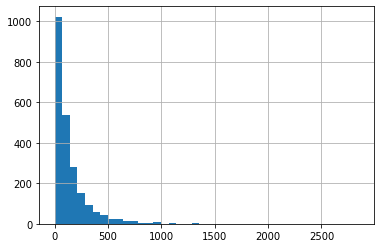

In [19]:
#@title **Choose the dataset you want to explore** { run: "auto", display-mode: "form" }
df = df_Alexa #@param ["df_Alexa", "df_Magazines"] {'type':'raw'}

# DataFrame head
display(df.head())

# Columns
display(Markdown('###Our dataframe have the following columns:'))
display(df.columns)

# Key descriptive elements
display(Markdown('###We can observe that'))
print("The total length of the dataset is {0}".format(df.shape[0]))
print('There are {0} different entries in the database'.format(len(df.review.unique())))
print('The mean length of an entry is {0}'.format(df.review.drop_duplicates().apply(len).mean()))


display(Markdown('## Repartition of the reviews lengths'))
# Repartition of the reviews lengths (characters)
display(Markdown("###Let's plot the distribution of the reviews lengths in term of characters"))
%matplotlib inline
display(df.review.drop_duplicates().apply(len).hist(bins=40))


## Lets look into positive and negative reviews

###Repartition of positive and negative reviews

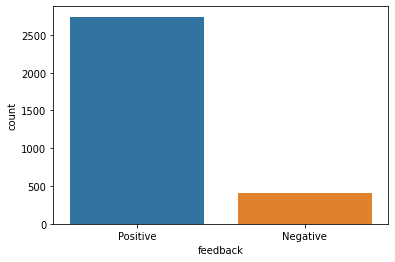

In [20]:
display(Markdown('## Lets look into positive and negative reviews'))
display(Markdown('###Repartition of positive and negative reviews'))
df['feedback'] = ['Positive' if x > 3 else 'Negative' for x in df['rating']]
sns.countplot(x = 'feedback' ,data = df, label = 'Count')

###Repartition of reviews by rating

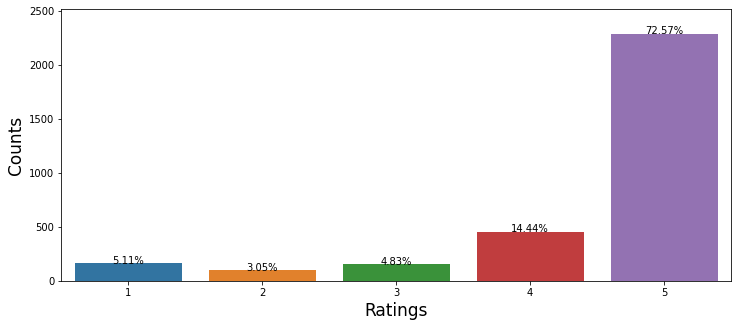

In [21]:
display(Markdown('###Repartition of reviews by rating'))
total = len(df)
ax1 = plt.figure(figsize=(12,5))

hist = sns.countplot(x='rating', data=df)
hist.set_xlabel("Ratings", fontsize=17)
hist.set_ylabel("Counts", fontsize=17)
sizes = []
for p in hist.patches:
    height = p.get_height()
    sizes.append(height)
    hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 
hist.set_ylim(0, max(sizes) * 1.1)
display(hist)

## Word cloud for negative and positive reviews

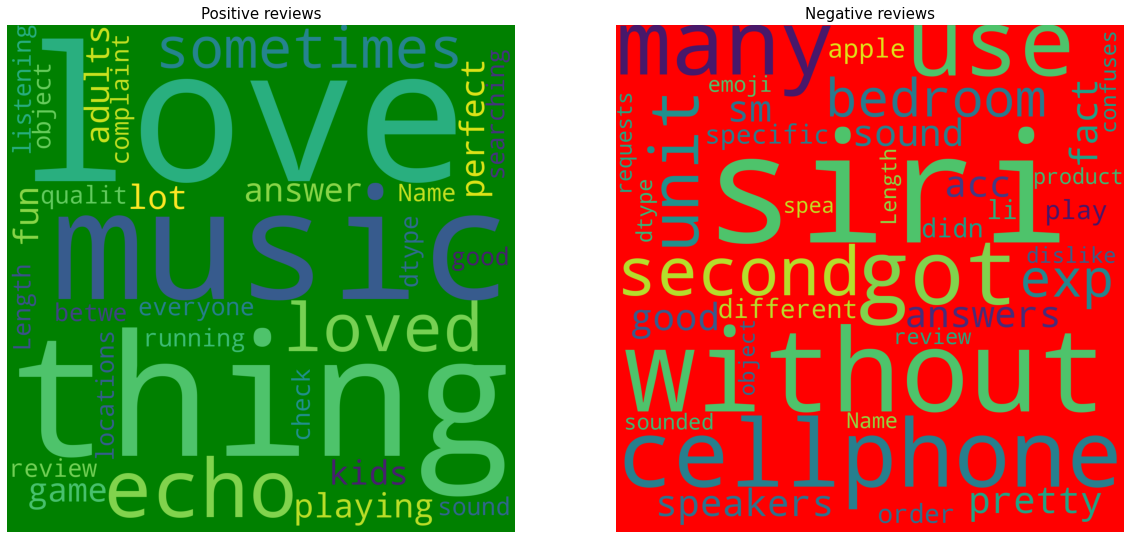

In [22]:
display(Markdown('## Word cloud for negative and positive reviews'))

positive = df[df['feedback'] == 'Positive']
negative = df[df['feedback'] == 'Negative'] 


plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fast')


cloud_positive = WordCloud(background_color = 'green', width = 1500, height = 1500).generate(str(positive['review']))

cloud_negative = WordCloud(background_color = 'red', width = 1500, height = 1500).generate(str(negative['review']))


plt.subplot(1, 2, 1)
plt.title('Positive reviews', fontsize = 15)
plt.imshow(cloud_positive)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Negative reviews', fontsize = 15)
plt.imshow(cloud_negative)
plt.axis('off')

plt.show()

### Repartition of length for positive reviews

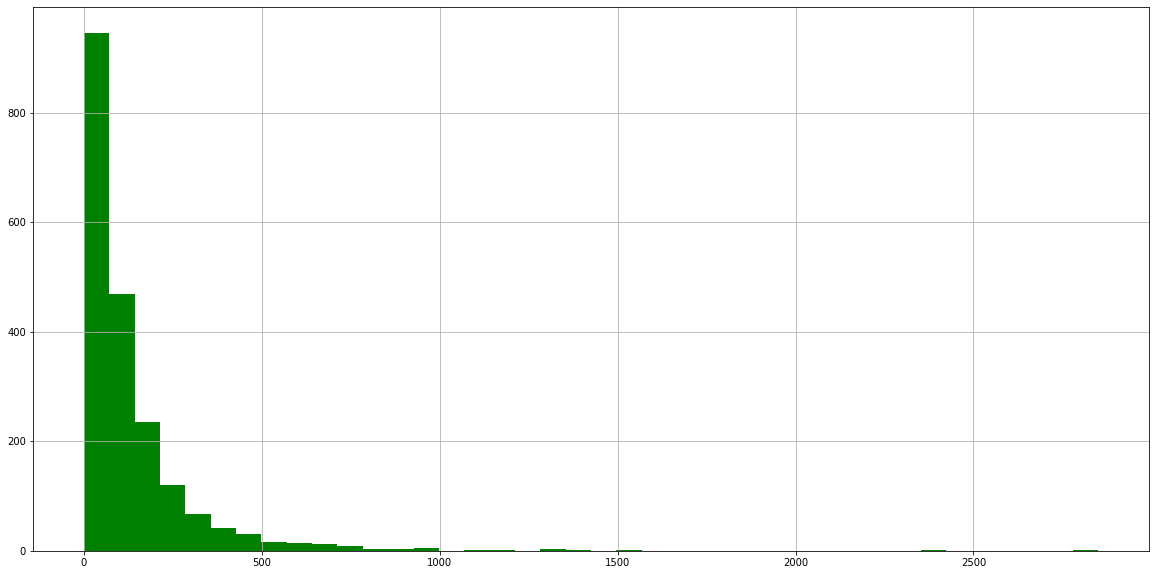

In [23]:
display(Markdown('### Repartition of length for positive reviews'))
positive.review.drop_duplicates().apply(len).hist(bins=40, color='green')

### Repartition of length for negative reviews

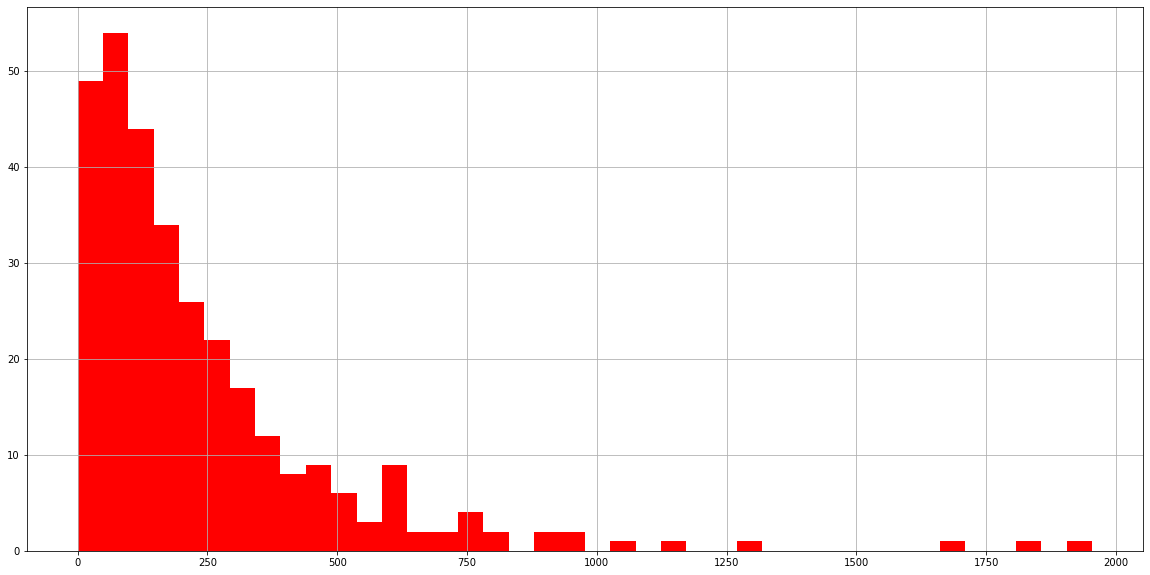

In [24]:
display(Markdown('### Repartition of length for negative reviews'))
negative.review.drop_duplicates().apply(len).hist(bins=40, color='red')

### Mean length by rating

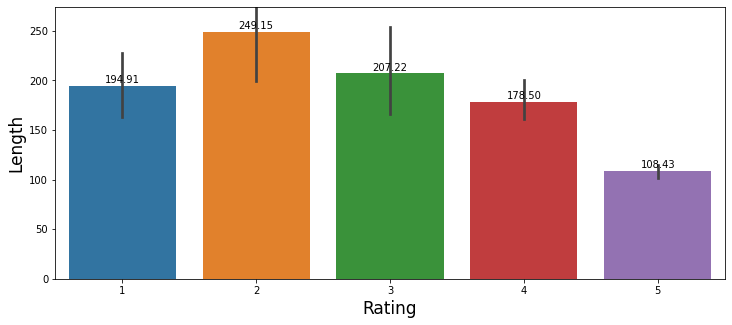

In [25]:
display(Markdown('### Mean length by rating'))

df['length'] = df.review.apply(len)

total = len(df)
ax1 = plt.figure(figsize=(12,5))

hist = sns.barplot(x='rating',y='length', data=df)
hist.set_xlabel("Rating", fontsize=17)
hist.set_ylabel("Length", fontsize=17)
sizes = []
for p in hist.patches:
    height = p.get_height()
    sizes.append(height)
    hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height),
            ha="center", fontsize=10) 
hist.set_ylim(0, max(sizes) * 1.1)
display(hist)

## **Magazines reviews**

,rating,review,tokens
0,4,"i'm old, and so is my computer. any advice th...","[i'm, old, ,, and, so, is, my, computer, ., an..."
1,5,"there's nothing to say, but if you want a real...","[there's, nothing, to, say, ,, but, if, you, w..."
2,1,if you're the kind of man who looks at himself...,"[if, you're, the, kind, of, man, who, looks, a..."
3,1,nothing to it. just an advertisement. little...,"[nothing, to, it, ., just, an, advertisement, ..."
4,5,when pc magazine ceased publication of their p...,"[when, pc, magazine, ceased, publication, of, ..."


###Our dataframe have the following columns:

Index(['rating', 'review', 'tokens'], dtype='object')

###We can observe that

The total length of the dataset is 2374
There are 1861 different entries in the database
The mean length of an entry is 371.69693713057495


## Repartition of the reviews lengths

###Let's plot the distribution of the reviews lengths in term of characters

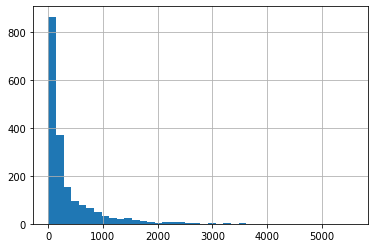

In [26]:
#@title **Choose the dataset you want to explore** { run: "auto", display-mode: "form" }
df = df_Magazines #@param ["df_Alexa", "df_Magazines"] {'type':'raw'}

# DataFrame head
display(df.head())

# Columns
display(Markdown('###Our dataframe have the following columns:'))
display(df.columns)

# Key descriptive elements
display(Markdown('###We can observe that'))
print("The total length of the dataset is {0}".format(df.shape[0]))
print('There are {0} different entries in the database'.format(len(df.review.unique())))
print('The mean length of an entry is {0}'.format(df.review.drop_duplicates().apply(len).mean()))


display(Markdown('## Repartition of the reviews lengths'))
# Repartition of the reviews lengths (characters)
display(Markdown("###Let's plot the distribution of the reviews lengths in term of characters"))
%matplotlib inline
display(df.review.drop_duplicates().apply(len).hist(bins=40))


## Lets look into positive and negative reviews

###Repartition of positive and negative reviews

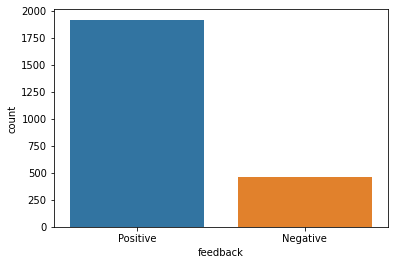

In [27]:
display(Markdown('## Lets look into positive and negative reviews'))
display(Markdown('###Repartition of positive and negative reviews'))
df['feedback'] = ['Positive' if x > 3 else 'Negative' for x in df['rating']]
sns.countplot(x = 'feedback' ,data = df, label = 'Count')

###Repartition of reviews by rating

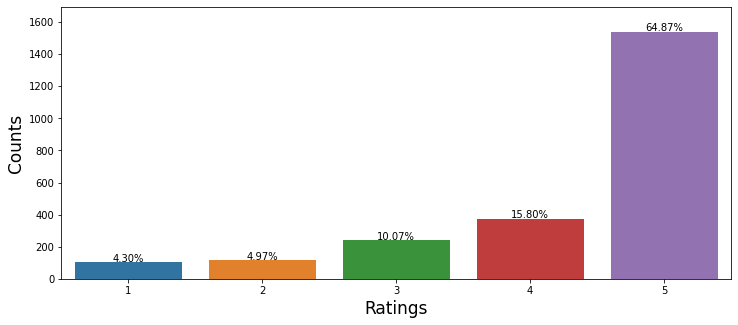

In [28]:
display(Markdown('###Repartition of reviews by rating'))
total = len(df)
ax1 = plt.figure(figsize=(12,5))

hist = sns.countplot(x='rating', data=df)
hist.set_xlabel("Ratings", fontsize=17)
hist.set_ylabel("Counts", fontsize=17)
sizes = []
for p in hist.patches:
    height = p.get_height()
    sizes.append(height)
    hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 
hist.set_ylim(0, max(sizes) * 1.1)
display(hist)

## Word cloud for negative and positive reviews

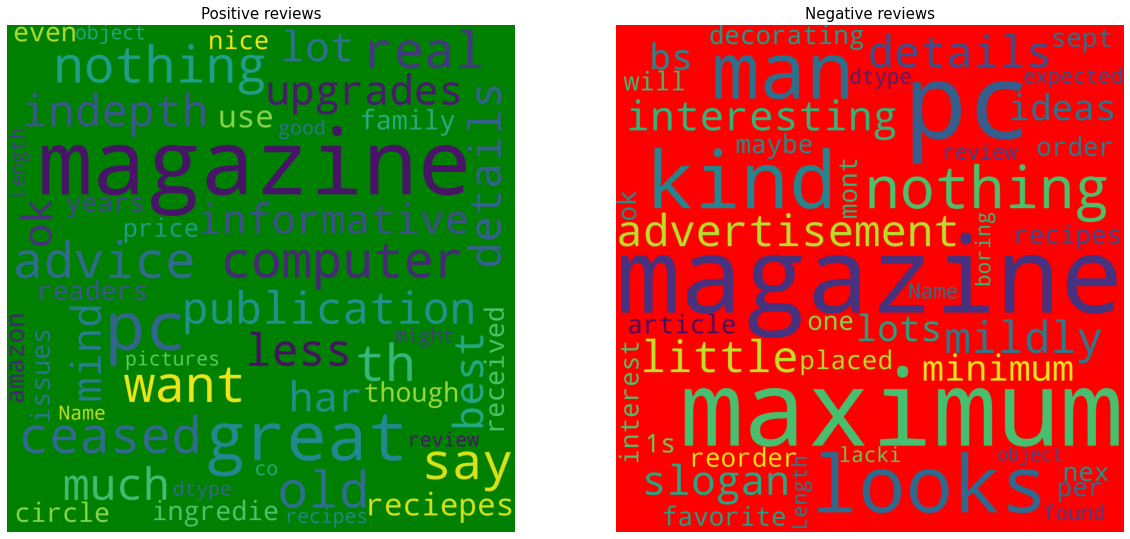

In [29]:
display(Markdown('## Word cloud for negative and positive reviews'))

positive = df[df['feedback'] == 'Positive']
negative = df[df['feedback'] == 'Negative'] 


plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fast')


cloud_positive = WordCloud(background_color = 'green', width = 1500, height = 1500).generate(str(positive['review']))

cloud_negative = WordCloud(background_color = 'red', width = 1500, height = 1500).generate(str(negative['review']))


plt.subplot(1, 2, 1)
plt.title('Positive reviews', fontsize = 15)
plt.imshow(cloud_positive)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Negative reviews', fontsize = 15)
plt.imshow(cloud_negative)
plt.axis('off')

plt.show()

### Repartition of length for positive reviews

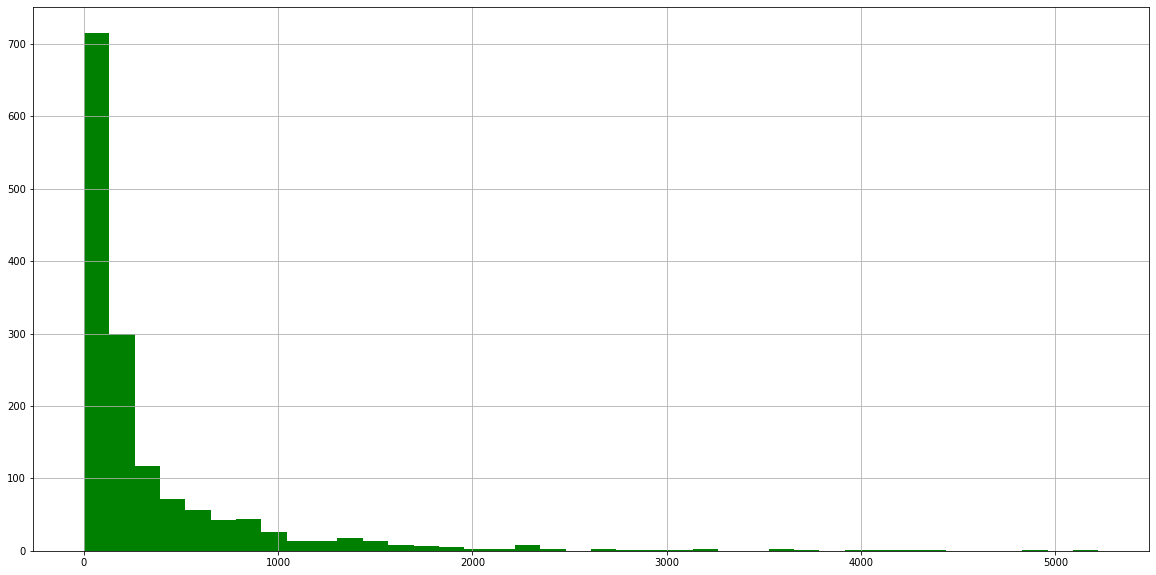

In [30]:
display(Markdown('### Repartition of length for positive reviews'))
positive.review.drop_duplicates().apply(len).hist(bins=40, color='green')

### Repartition of length for negative reviews

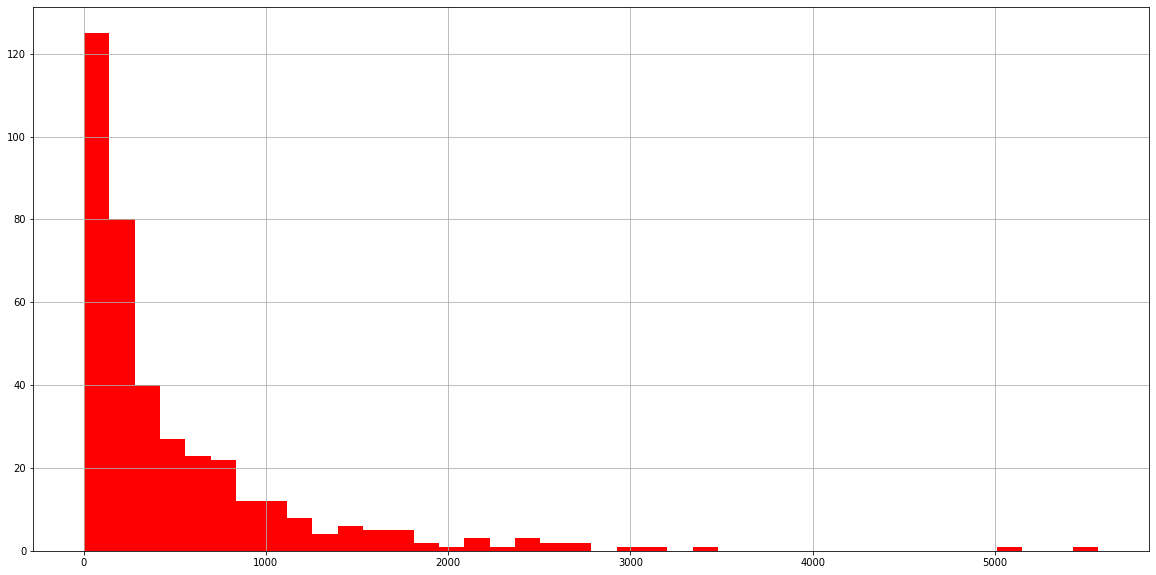

In [31]:
display(Markdown('### Repartition of length for negative reviews'))
negative.review.drop_duplicates().apply(len).hist(bins=40, color='red')

### Mean length by rating

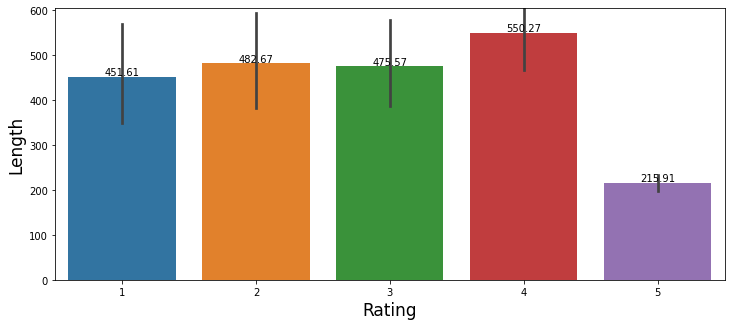

In [32]:
display(Markdown('### Mean length by rating'))

df['length'] = df.review.apply(len)

total = len(df)
ax1 = plt.figure(figsize=(12,5))

hist = sns.barplot(x='rating',y='length', data=df)
hist.set_xlabel("Rating", fontsize=17)
hist.set_ylabel("Length", fontsize=17)
sizes = []
for p in hist.patches:
    height = p.get_height()
    sizes.append(height)
    hist.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height),
            ha="center", fontsize=10) 
hist.set_ylim(0, max(sizes) * 1.1)
display(hist)

# **Best model computation**

In [ ]:
# Define a dataframe to store the accuracies for each model
score_df = pd.DataFrame(columns=['Name','Accuracy Score','F1 Score','Weighted Accuracy','Confusion matrix','Parameters'])

## **Finding the best model using neural networks and BERT**

### **Load Magazines training and validation data**

In [ ]:
### Uncomment to create train and validation data ###

MagazinesDataset = EmbeddingDataset(df = df_Magazines, word_vocab = pretrained_vocab, fixed_size  = 50)

training_dataloader, validation_batch = prepare_training(MagazinesDataset)

pickle_to_drive(training_dataloader, 
                name = "training_dataloader.pickle",
                file_id = "1X62_b4qXHI6yz-KYXOdANNC910P1Ifsl")
pickle_to_drive(validation_batch,
                name = "validation_batch.pickle",
                file_id = "1qLALY2OGqwtSb_4Wkq4bIo2Nywhvzxb4")

Uploaded file training_dataloader.pickle with file_id 1X62_b4qXHI6yz-KYXOdANNC910P1Ifsl
Uploaded file validation_batch.pickle with file_id 1qLALY2OGqwtSb_4Wkq4bIo2Nywhvzxb4


In [ ]:
training_dataloader = load_pickle_from_drive(file_id = "1X62_b4qXHI6yz-KYXOdANNC910P1Ifsl")
validation_batch = load_pickle_from_drive(file_id = "1qLALY2OGqwtSb_4Wkq4bIo2Nywhvzxb4")

Downloaded file training_dataloader.pickle with file_id 1X62_b4qXHI6yz-KYXOdANNC910P1Ifsl
Downloaded file validation_batch.pickle with file_id 1qLALY2OGqwtSb_4Wkq4bIo2Nywhvzxb4


### **SimpleClassificationNN**

#### **Train & choose hypermarameters**

In [ ]:

# best_SimpleClassificationNN, best_SimpleClassificationNN_hyperparams = optimize_hyperparameters_on_grid(model_args_dict = {"hidden_dim":[10, 30, 60, 100, 200], 
#                                                                              "output_dim":[2]},
#                                                                training_loop_args_dict= {"dataloader":training_dataloader,
#                                                                                     "loss_function":[torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([2, 1])),
#                                                                                                      torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([4, 1])),
#                                                                                                      torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([10, 1]))],
#                                                                                     "validation_batch":[validation_batch],
#                                                                                     "accuracy_func":accuracy_of_torch_model,
#                                                                                     "optimizer":"Adam",
#                                                                                     "optimizer_args":{"lr":0.01},
#                                                                                     "scheduler":"ReduceLROnPlateau",
#                                                                                     "scheduler_args":{"factor":0.01, "patience":10},
#                                                                                     "epochs":200,
#                                                                                     "early_stopping_steps":21,
#                                                                                     "device":"cpu"},
#                                                                model_type = SimpleClassificationNN,
#                                                                n_trials = 1)



# state_dict_to_save = get_model_state_dict_copy_excluding_ebd(best_SimpleClassificationNN)
# pickle_to_drive(state_dict_to_save, name =  "best_SimpleClassificationNN_state_dict.pickle",
#                 file_id = "1y-l1qwgIrVfzY7kPh8-CHwL2JcciKsIL")
# pickle_to_drive(best_SimpleClassificationNN_hyperparams,
#                 name = "best_SimpleClassificationNN_hyperparams.pickle",
#                 file_id = "1muWpzctKkT5DS7Kv2SQbERH7iqrKgkDb")

Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 54.90it/s]

Training loss: 0.554323  [  825/ 2137]
LR = 0.01
Validation loss = 0.5904645919799805 | Validation accuracy = 0.8185654282569885



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 79.93it/s] 

Training loss: 0.531854  [  825/ 2137]
LR = 0.01
Validation loss = 0.5489420294761658 | Validation accuracy = 0.8396624326705933



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 79.11it/s] 

Training loss: 0.500248  [  825/ 2137]
LR = 0.01
Validation loss = 0.5337183475494385 | Validation accuracy = 0.8396624326705933



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 78.20it/s] 

Training loss: 0.489298  [  825/ 2137]
LR = 0.01
Validation loss = 0.5087529420852661 | Validation accuracy = 0.8481012582778931



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 79.65it/s] 

Training loss: 0.543119  [  825/ 2137]
LR = 0.01
Validation loss = 0.5028948187828064 | Validation accuracy = 0.8481012582778931



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 77.19it/s] 

Training loss: 0.415855  [  825/ 2137]
LR = 0.01
Validation loss = 0.4977551996707916 | Validation accuracy = 0.8396624326705933



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 75.72it/s] 

Training loss: 0.483674  [  825/ 2137]
LR = 0.01
Validation loss = 0.5080487728118896 | Validation accuracy = 0.8691983222961426



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 80.47it/s] 

Training loss: 0.541094  [  825/ 2137]
LR = 0.01
Validation loss = 0.4928673505783081 | Validation accuracy = 0.8607594966888428



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 79.66it/s] 

Training loss: 0.424835  [  825/ 2137]
LR = 0.01
Validation loss = 0.4864271283149719 | Validation accuracy = 0.8481012582778931



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 77.85it/s] 

Training loss: 0.542585  [  825/ 2137]
LR = 0.01
Validation loss = 0.47837042808532715 | Validation accuracy = 0.8354430198669434



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 80.22it/s] 

Training loss: 0.412965  [  825/ 2137]
LR = 0.01
Validation loss = 0.48074936866760254 | Validation accuracy = 0.8312236070632935



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 77.60it/s] 

Training loss: 0.534409  [  825/ 2137]
LR = 0.01
Validation loss = 0.4773741066455841 | Validation accuracy = 0.8691983222961426



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 81.59it/s] 

Training loss: 0.435959  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47615039348602295 | Validation accuracy = 0.8649789094924927



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 79.93it/s] 

Training loss: 0.480808  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47560787200927734 | Validation accuracy = 0.8691983222961426



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 75.80it/s] 

Training loss: 0.420610  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4754226803779602 | Validation accuracy = 0.8691983222961426



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 80.39it/s] 

Training loss: 0.497508  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4750487506389618 | Validation accuracy = 0.8649789094924927



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 74.74it/s] 

Training loss: 0.422554  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47506996989250183 | Validation accuracy = 0.8649789094924927



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 72.54it/s] 

Training loss: 0.497619  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4750237762928009 | Validation accuracy = 0.8649789094924927



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 76.86it/s] 

Training loss: 0.489321  [  825/ 2137]
LR = 0.0001
Validation loss = 0.475052148103714 | Validation accuracy = 0.8649789094924927



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 73.39it/s] 

Training loss: 0.389775  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47503745555877686 | Validation accuracy = 0.8649789094924927



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 74.40it/s] 

Training loss: 0.489039  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47503477334976196 | Validation accuracy = 0.8649789094924927



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 78.78it/s] 

Training loss: 0.426694  [  825/ 2137]
LR = 0.0001
Validation loss = 0.474986732006073 | Validation accuracy = 0.8649789094924927



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 77.14it/s] 

Training loss: 0.477642  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47503602504730225 | Validation accuracy = 0.8649789094924927



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 78.10it/s] 

Training loss: 0.485118  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4750349223613739 | Validation accuracy = 0.8649789094924927



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 78.43it/s] 

Training loss: 0.557345  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4750325083732605 | Validation accuracy = 0.8649789094924927



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 76.37it/s] 

Training loss: 0.539217  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.475032240152359 | Validation accuracy = 0.8649789094924927



Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 75.77it/s] 

Training loss: 0.349644  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47503289580345154 | Validation accuracy = 0.8649789094924927



Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 76.49it/s] 

Training loss: 0.458936  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4750312566757202 | Validation accuracy = 0.8649789094924927
Early stopping after epoch 27
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 80.10it/s] 

Training loss: 0.591187  [  825/ 2137]
LR = 0.01
Validation loss = 0.5938684344291687 | Validation accuracy = 0.6835442781448364



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 81.47it/s] 

Training loss: 0.527381  [  825/ 2137]
LR = 0.01
Validation loss = 0.5561659336090088 | Validation accuracy = 0.7383966445922852



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 82.50it/s] 

Training loss: 0.508152  [  825/ 2137]
LR = 0.01
Validation loss = 0.5378367900848389 | Validation accuracy = 0.8312236070632935



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 77.51it/s] 

Training loss: 0.517279  [  825/ 2137]
LR = 0.01
Validation loss = 0.5149148106575012 | Validation accuracy = 0.7805907130241394



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 61.39it/s] 

Training loss: 0.613648  [  825/ 2137]
LR = 0.01
Validation loss = 0.5309013724327087 | Validation accuracy = 0.8565400838851929



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 80.01it/s] 

Training loss: 0.445779  [  825/ 2137]
LR = 0.01
Validation loss = 0.4976290464401245 | Validation accuracy = 0.8185654282569885



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 75.73it/s] 

Training loss: 0.497594  [  825/ 2137]
LR = 0.01
Validation loss = 0.5077033638954163 | Validation accuracy = 0.8438818454742432



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 76.79it/s] 

Training loss: 0.445835  [  825/ 2137]
LR = 0.01
Validation loss = 0.5037145018577576 | Validation accuracy = 0.7510548233985901



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 80.16it/s] 

Training loss: 0.470402  [  825/ 2137]
LR = 0.01
Validation loss = 0.49417194724082947 | Validation accuracy = 0.7848101258277893



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 77.50it/s] 

Training loss: 0.488412  [  825/ 2137]
LR = 0.01
Validation loss = 0.49958860874176025 | Validation accuracy = 0.8143460154533386



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 78.94it/s] 

Training loss: 0.419261  [  825/ 2137]
LR = 0.01
Validation loss = 0.5091367363929749 | Validation accuracy = 0.8438818454742432



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 76.27it/s] 

Training loss: 0.471462  [  825/ 2137]
LR = 0.01
Validation loss = 0.4938931167125702 | Validation accuracy = 0.7848101258277893



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 72.06it/s] 

Training loss: 0.507880  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49154070019721985 | Validation accuracy = 0.8016877770423889



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 73.50it/s] 

Training loss: 0.644486  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4908383786678314 | Validation accuracy = 0.8059071898460388



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 77.70it/s] 

Training loss: 0.425202  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4911539852619171 | Validation accuracy = 0.8143460154533386



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 75.14it/s] 

Training loss: 0.395018  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4916217029094696 | Validation accuracy = 0.8185654282569885



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 76.74it/s] 

Training loss: 0.432832  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4917928874492645 | Validation accuracy = 0.8185654282569885



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 74.59it/s] 

Training loss: 0.576410  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49197790026664734 | Validation accuracy = 0.8227847814559937



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 74.18it/s] 

Training loss: 0.488048  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49182140827178955 | Validation accuracy = 0.8185654282569885



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 77.29it/s] 

Training loss: 0.490570  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49196067452430725 | Validation accuracy = 0.8227847814559937



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 77.35it/s] 

Training loss: 0.363570  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49194979667663574 | Validation accuracy = 0.8227847814559937



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 74.73it/s] 

Training loss: 0.394004  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4922972619533539 | Validation accuracy = 0.8227847814559937



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 77.52it/s] 

Training loss: 0.439301  [  825/ 2137]
LR = 0.0001
Validation loss = 0.492119699716568 | Validation accuracy = 0.8227847814559937



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 77.61it/s] 

Training loss: 0.382058  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.49211570620536804 | Validation accuracy = 0.8227847814559937



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 78.86it/s] 

Training loss: 0.475774  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4921172261238098 | Validation accuracy = 0.8227847814559937



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 76.69it/s] 

Training loss: 0.626298  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4921168088912964 | Validation accuracy = 0.8227847814559937
Early stopping after epoch 25
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 76.76it/s] 

Training loss: 0.568886  [  825/ 2137]
LR = 0.01
Validation loss = 0.5700000524520874 | Validation accuracy = 0.3164556920528412



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 76.68it/s] 

Training loss: 0.658988  [  825/ 2137]
LR = 0.01
Validation loss = 0.5470167994499207 | Validation accuracy = 0.37552741169929504



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 81.70it/s] 

Training loss: 0.539463  [  825/ 2137]
LR = 0.01
Validation loss = 0.5361696481704712 | Validation accuracy = 0.5063291192054749



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 77.85it/s] 

Training loss: 0.697013  [  825/ 2137]
LR = 0.01
Validation loss = 0.5294272899627686 | Validation accuracy = 0.5443037748336792



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 80.15it/s] 

Training loss: 0.567440  [  825/ 2137]
LR = 0.01
Validation loss = 0.5166983008384705 | Validation accuracy = 0.48523205518722534



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 77.27it/s] 

Training loss: 0.504069  [  825/ 2137]
LR = 0.01
Validation loss = 0.5124501585960388 | Validation accuracy = 0.6413502097129822



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 74.97it/s] 

Training loss: 0.398508  [  825/ 2137]
LR = 0.01
Validation loss = 0.5003092288970947 | Validation accuracy = 0.5316455960273743



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 76.76it/s] 

Training loss: 0.431364  [  825/ 2137]
LR = 0.01
Validation loss = 0.4964410066604614 | Validation accuracy = 0.649789035320282



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 76.06it/s] 

Training loss: 0.493898  [  825/ 2137]
LR = 0.01
Validation loss = 0.4913477599620819 | Validation accuracy = 0.6793248653411865



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 75.70it/s] 

Training loss: 0.516265  [  825/ 2137]
LR = 0.01
Validation loss = 0.4845315217971802 | Validation accuracy = 0.6202531456947327



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 79.43it/s] 

Training loss: 0.817369  [  825/ 2137]
LR = 0.01
Validation loss = 0.48455810546875 | Validation accuracy = 0.700421929359436



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 79.97it/s] 

Training loss: 0.445714  [  825/ 2137]
LR = 0.01
Validation loss = 0.4798106253147125 | Validation accuracy = 0.7130801677703857



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 74.98it/s] 

Training loss: 0.384142  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47727829217910767 | Validation accuracy = 0.6962025165557861



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 80.23it/s] 

Training loss: 0.560943  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4753354489803314 | Validation accuracy = 0.6835442781448364



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 77.20it/s] 

Training loss: 0.428006  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4749121069908142 | Validation accuracy = 0.6835442781448364



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 76.12it/s] 

Training loss: 0.399282  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4741503596305847 | Validation accuracy = 0.6919831037521362



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 78.73it/s] 

Training loss: 0.398490  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47399598360061646 | Validation accuracy = 0.6919831037521362



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 75.35it/s] 

Training loss: 0.444169  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4737602472305298 | Validation accuracy = 0.6919831037521362



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 77.25it/s] 

Training loss: 0.455592  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47363072633743286 | Validation accuracy = 0.6919831037521362



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 75.58it/s] 

Training loss: 0.499592  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4733988344669342 | Validation accuracy = 0.6919831037521362



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 76.84it/s] 

Training loss: 0.396747  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4734022319316864 | Validation accuracy = 0.6919831037521362



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 76.18it/s] 

Training loss: 0.463660  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47342342138290405 | Validation accuracy = 0.6919831037521362



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 74.68it/s] 

Training loss: 0.408476  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4733401834964752 | Validation accuracy = 0.6919831037521362



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 80.41it/s] 

Training loss: 0.486057  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4733375012874603 | Validation accuracy = 0.6919831037521362



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 77.12it/s] 

Training loss: 0.455749  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47333452105522156 | Validation accuracy = 0.6919831037521362



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 76.29it/s] 

Training loss: 0.474476  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4733351171016693 | Validation accuracy = 0.6919831037521362



Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 75.45it/s] 

Training loss: 0.514249  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4733346700668335 | Validation accuracy = 0.6919831037521362



Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 77.76it/s] 

Training loss: 0.467307  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4733351767063141 | Validation accuracy = 0.6919831037521362



Epoch 28 : 100%|██████████| 34/34 [00:00<00:00, 77.04it/s] 

Training loss: 0.465160  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4733351767063141 | Validation accuracy = 0.6919831037521362



Epoch 29 : 100%|██████████| 34/34 [00:00<00:00, 78.79it/s] 

Training loss: 0.438411  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47333407402038574 | Validation accuracy = 0.6919831037521362



Epoch 30 : 100%|██████████| 34/34 [00:00<00:00, 79.39it/s] 

Training loss: 0.458631  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47333747148513794 | Validation accuracy = 0.6919831037521362



Epoch 31 : 100%|██████████| 34/34 [00:00<00:00, 77.21it/s] 

Training loss: 0.475191  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47333279252052307 | Validation accuracy = 0.6919831037521362



Epoch 32 : 100%|██████████| 34/34 [00:00<00:00, 75.28it/s] 

Training loss: 0.389168  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4733288288116455 | Validation accuracy = 0.6919831037521362
Early stopping after epoch 32
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 76.45it/s] 

Training loss: 0.562522  [  825/ 2137]
LR = 0.01
Validation loss = 0.5725522041320801 | Validation accuracy = 0.8270041942596436



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 67.21it/s] 


Training loss: 0.519430  [  825/ 2137]
LR = 0.01
Validation loss = 0.5329819321632385 | Validation accuracy = 0.8396624326705933


Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 74.71it/s] 

Training loss: 0.515391  [  825/ 2137]
LR = 0.01
Validation loss = 0.5088701248168945 | Validation accuracy = 0.8481012582778931



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 80.76it/s] 

Training loss: 0.536160  [  825/ 2137]
LR = 0.01
Validation loss = 0.4923785924911499 | Validation accuracy = 0.8649789094924927



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 75.09it/s] 

Training loss: 0.421565  [  825/ 2137]
LR = 0.01
Validation loss = 0.49041301012039185 | Validation accuracy = 0.8354430198669434



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 75.71it/s] 

Training loss: 0.607208  [  825/ 2137]
LR = 0.01
Validation loss = 0.49097296595573425 | Validation accuracy = 0.8565400838851929



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 76.43it/s] 

Training loss: 0.400408  [  825/ 2137]
LR = 0.01
Validation loss = 0.5015603303909302 | Validation accuracy = 0.8649789094924927



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 78.42it/s] 

Training loss: 0.627325  [  825/ 2137]
LR = 0.01
Validation loss = 0.4811088442802429 | Validation accuracy = 0.8649789094924927



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 77.33it/s] 

Training loss: 0.468935  [  825/ 2137]
LR = 0.01
Validation loss = 0.4994935691356659 | Validation accuracy = 0.797468364238739



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 76.11it/s] 

Training loss: 0.482104  [  825/ 2137]
LR = 0.01
Validation loss = 0.47845903038978577 | Validation accuracy = 0.8691983222961426



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 74.00it/s] 

Training loss: 0.426087  [  825/ 2137]
LR = 0.01
Validation loss = 0.47716695070266724 | Validation accuracy = 0.8481012582778931



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 71.53it/s] 

Training loss: 0.367900  [  825/ 2137]
LR = 0.01
Validation loss = 0.4789538085460663 | Validation accuracy = 0.8438818454742432



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 74.17it/s] 

Training loss: 0.435059  [  825/ 2137]
LR = 0.01
Validation loss = 0.4766649305820465 | Validation accuracy = 0.8607594966888428



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 67.80it/s] 


Training loss: 0.487531  [  825/ 2137]
LR = 0.01
Validation loss = 0.4773450195789337 | Validation accuracy = 0.8481012582778931


Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 69.69it/s] 


Training loss: 0.343241  [  825/ 2137]
LR = 0.01
Validation loss = 0.4764242470264435 | Validation accuracy = 0.8691983222961426


Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 71.18it/s] 

Training loss: 0.480823  [  825/ 2137]
LR = 0.01
Validation loss = 0.4770151674747467 | Validation accuracy = 0.8438818454742432



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 70.10it/s] 


Training loss: 0.402622  [  825/ 2137]
LR = 0.01
Validation loss = 0.4859382212162018 | Validation accuracy = 0.8185654282569885


Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 68.26it/s] 


Training loss: 0.482576  [  825/ 2137]
LR = 0.01
Validation loss = 0.48382091522216797 | Validation accuracy = 0.852320671081543


Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 68.31it/s] 


Training loss: 0.457140  [  825/ 2137]
LR = 0.01
Validation loss = 0.4783395230770111 | Validation accuracy = 0.8481012582778931


Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 75.16it/s] 

Training loss: 0.364523  [  825/ 2137]
LR = 0.01
Validation loss = 0.4793318212032318 | Validation accuracy = 0.8649789094924927



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 76.65it/s] 

Training loss: 0.364855  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4767536520957947 | Validation accuracy = 0.8691983222961426



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 78.14it/s] 

Training loss: 0.410394  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47566086053848267 | Validation accuracy = 0.8481012582778931



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 81.74it/s] 

Training loss: 0.460738  [  825/ 2137]
LR = 0.0001
Validation loss = 0.475229412317276 | Validation accuracy = 0.8438818454742432



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 76.16it/s] 

Training loss: 0.442045  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4748857915401459 | Validation accuracy = 0.8481012582778931



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 77.21it/s] 

Training loss: 0.412800  [  825/ 2137]
LR = 0.0001
Validation loss = 0.474517285823822 | Validation accuracy = 0.8481012582778931



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 76.14it/s] 

Training loss: 0.402519  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4742812216281891 | Validation accuracy = 0.852320671081543



Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 72.32it/s] 

Training loss: 0.427752  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47410932183265686 | Validation accuracy = 0.852320671081543



Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 76.74it/s] 

Training loss: 0.375574  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47394847869873047 | Validation accuracy = 0.852320671081543



Epoch 28 : 100%|██████████| 34/34 [00:00<00:00, 75.45it/s] 

Training loss: 0.386331  [  825/ 2137]
LR = 0.0001
Validation loss = 0.473816454410553 | Validation accuracy = 0.8607594966888428



Epoch 29 : 100%|██████████| 34/34 [00:00<00:00, 75.25it/s] 

Training loss: 0.454515  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4736478626728058 | Validation accuracy = 0.8565400838851929



Epoch 30 : 100%|██████████| 34/34 [00:00<00:00, 74.31it/s] 

Training loss: 0.382716  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4735291600227356 | Validation accuracy = 0.8565400838851929
Early stopping after epoch 30
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 76.50it/s] 

Training loss: 0.589597  [  825/ 2137]
LR = 0.01
Validation loss = 0.5623536109924316 | Validation accuracy = 0.7257384061813354



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 74.15it/s] 

Training loss: 0.608411  [  825/ 2137]
LR = 0.01
Validation loss = 0.5271026492118835 | Validation accuracy = 0.8016877770423889



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 75.20it/s] 

Training loss: 0.526580  [  825/ 2137]
LR = 0.01
Validation loss = 0.5149796605110168 | Validation accuracy = 0.7637130618095398



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 77.10it/s] 

Training loss: 0.475914  [  825/ 2137]
LR = 0.01
Validation loss = 0.5016409158706665 | Validation accuracy = 0.8227847814559937



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 77.18it/s] 

Training loss: 0.380552  [  825/ 2137]
LR = 0.01
Validation loss = 0.4978868067264557 | Validation accuracy = 0.7805907130241394



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 78.80it/s] 

Training loss: 0.595449  [  825/ 2137]
LR = 0.01
Validation loss = 0.5048863887786865 | Validation accuracy = 0.8312236070632935



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 76.80it/s] 

Training loss: 0.483451  [  825/ 2137]
LR = 0.01
Validation loss = 0.514202356338501 | Validation accuracy = 0.852320671081543



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 74.58it/s] 

Training loss: 0.403003  [  825/ 2137]
LR = 0.01
Validation loss = 0.5059623718261719 | Validation accuracy = 0.8270041942596436



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 78.18it/s] 

Training loss: 0.503430  [  825/ 2137]
LR = 0.01
Validation loss = 0.490077406167984 | Validation accuracy = 0.8059071898460388



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 75.82it/s] 

Training loss: 0.389584  [  825/ 2137]
LR = 0.01
Validation loss = 0.4929753243923187 | Validation accuracy = 0.797468364238739



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 74.41it/s] 

Training loss: 0.438898  [  825/ 2137]
LR = 0.01
Validation loss = 0.5002686381340027 | Validation accuracy = 0.8059071898460388



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 73.45it/s] 

Training loss: 0.511994  [  825/ 2137]
LR = 0.01
Validation loss = 0.531872570514679 | Validation accuracy = 0.6582278609275818



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 74.66it/s] 

Training loss: 0.451711  [  825/ 2137]
LR = 0.01
Validation loss = 0.5045932531356812 | Validation accuracy = 0.8143460154533386



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 75.81it/s] 

Training loss: 0.375365  [  825/ 2137]
LR = 0.01
Validation loss = 0.5038281679153442 | Validation accuracy = 0.8059071898460388



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 76.98it/s] 

Training loss: 0.460234  [  825/ 2137]
LR = 0.01
Validation loss = 0.5088764429092407 | Validation accuracy = 0.8101266026496887



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 70.12it/s] 


Training loss: 0.539484  [  825/ 2137]
LR = 0.01
Validation loss = 0.5052777528762817 | Validation accuracy = 0.8101266026496887


Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 70.50it/s] 

Training loss: 0.536299  [  825/ 2137]
LR = 0.01
Validation loss = 0.508814811706543 | Validation accuracy = 0.8227847814559937



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 68.22it/s] 


Training loss: 0.438336  [  825/ 2137]
LR = 0.01
Validation loss = 0.48872292041778564 | Validation accuracy = 0.7890295386314392


Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 74.81it/s] 

Training loss: 0.618116  [  825/ 2137]
LR = 0.01
Validation loss = 0.51017826795578 | Validation accuracy = 0.8101266026496887



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 70.33it/s] 

Training loss: 0.518633  [  825/ 2137]
LR = 0.01
Validation loss = 0.4908985197544098 | Validation accuracy = 0.7932489514350891



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 71.64it/s] 

Training loss: 0.500440  [  825/ 2137]
LR = 0.01
Validation loss = 0.4969693720340729 | Validation accuracy = 0.7890295386314392



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 76.10it/s] 

Training loss: 0.541484  [  825/ 2137]
LR = 0.01
Validation loss = 0.49395352602005005 | Validation accuracy = 0.7932489514350891



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 71.86it/s] 

Training loss: 0.506283  [  825/ 2137]
LR = 0.01
Validation loss = 0.49995967745780945 | Validation accuracy = 0.7890295386314392



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 74.22it/s] 

Training loss: 0.476577  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5019668936729431 | Validation accuracy = 0.8059071898460388



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 77.02it/s] 

Training loss: 0.527078  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5033352375030518 | Validation accuracy = 0.8227847814559937



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 74.68it/s] 

Training loss: 0.426876  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5033847093582153 | Validation accuracy = 0.8227847814559937



Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 79.68it/s] 

Training loss: 0.446132  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5037764310836792 | Validation accuracy = 0.8270041942596436



Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 76.54it/s] 

Training loss: 0.453173  [  825/ 2137]
LR = 0.0001
Validation loss = 0.503844141960144 | Validation accuracy = 0.8270041942596436
Early stopping after epoch 27
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 73.11it/s] 

Training loss: 0.473587  [  825/ 2137]
LR = 0.01
Validation loss = 0.5534117817878723 | Validation accuracy = 0.37130802869796753



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 78.31it/s] 

Training loss: 0.548649  [  825/ 2137]
LR = 0.01
Validation loss = 0.5397799611091614 | Validation accuracy = 0.4135020971298218



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 75.76it/s] 

Training loss: 0.664445  [  825/ 2137]
LR = 0.01
Validation loss = 0.5100638270378113 | Validation accuracy = 0.5443037748336792



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 75.22it/s] 

Training loss: 0.455302  [  825/ 2137]
LR = 0.01
Validation loss = 0.503402590751648 | Validation accuracy = 0.6624472737312317



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 78.78it/s] 

Training loss: 0.489649  [  825/ 2137]
LR = 0.01
Validation loss = 0.4960342049598694 | Validation accuracy = 0.7046413421630859



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 74.28it/s] 

Training loss: 0.560576  [  825/ 2137]
LR = 0.01
Validation loss = 0.5261465907096863 | Validation accuracy = 0.4219409227371216



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 75.30it/s] 

Training loss: 0.400366  [  825/ 2137]
LR = 0.01
Validation loss = 0.469499796628952 | Validation accuracy = 0.594936728477478



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 79.11it/s] 

Training loss: 0.571722  [  825/ 2137]
LR = 0.01
Validation loss = 0.4574246406555176 | Validation accuracy = 0.7215189933776855



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 77.74it/s] 

Training loss: 0.382477  [  825/ 2137]
LR = 0.01
Validation loss = 0.4541855752468109 | Validation accuracy = 0.6751055121421814



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 76.53it/s] 

Training loss: 0.471588  [  825/ 2137]
LR = 0.01
Validation loss = 0.4764443635940552 | Validation accuracy = 0.7721518874168396



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 78.25it/s] 

Training loss: 0.433815  [  825/ 2137]
LR = 0.01
Validation loss = 0.44705432653427124 | Validation accuracy = 0.6919831037521362



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 75.61it/s] 

Training loss: 0.460490  [  825/ 2137]
LR = 0.01
Validation loss = 0.5270205140113831 | Validation accuracy = 0.8227847814559937



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 74.17it/s] 

Training loss: 0.483547  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4825475215911865 | Validation accuracy = 0.7848101258277893



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 74.68it/s] 

Training loss: 0.435931  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4654836356639862 | Validation accuracy = 0.75527423620224



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 72.78it/s] 

Training loss: 0.381250  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4603487253189087 | Validation accuracy = 0.7341772317886353



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 76.94it/s] 

Training loss: 0.425302  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4588561952114105 | Validation accuracy = 0.7299578189849854



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 75.26it/s] 

Training loss: 0.420565  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4600363075733185 | Validation accuracy = 0.7341772317886353



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 73.19it/s] 

Training loss: 0.463223  [  825/ 2137]
LR = 0.0001
Validation loss = 0.45981365442276 | Validation accuracy = 0.7341772317886353



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 72.36it/s] 

Training loss: 0.473981  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4590723514556885 | Validation accuracy = 0.7299578189849854



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 76.43it/s] 

Training loss: 0.523928  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4587109684944153 | Validation accuracy = 0.7299578189849854



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 70.74it/s] 

Training loss: 0.398786  [  825/ 2137]
LR = 0.0001
Validation loss = 0.46042025089263916 | Validation accuracy = 0.7341772317886353



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 74.29it/s] 

Training loss: 0.538982  [  825/ 2137]
LR = 0.0001
Validation loss = 0.45898085832595825 | Validation accuracy = 0.7299578189849854



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 74.89it/s] 

Training loss: 0.372024  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4593993127346039 | Validation accuracy = 0.7299578189849854



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 76.42it/s] 

Training loss: 0.442665  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.45941364765167236 | Validation accuracy = 0.7299578189849854



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 73.64it/s] 

Training loss: 0.419161  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4594098925590515 | Validation accuracy = 0.7299578189849854



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 75.45it/s] 

Training loss: 0.435135  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.45939791202545166 | Validation accuracy = 0.7299578189849854



Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 74.92it/s] 

Training loss: 0.397279  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.45939475297927856 | Validation accuracy = 0.7299578189849854



Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 74.07it/s] 

Training loss: 0.498306  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4593898355960846 | Validation accuracy = 0.7299578189849854



Epoch 28 : 100%|██████████| 34/34 [00:00<00:00, 73.64it/s] 

Training loss: 0.549837  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4594005048274994 | Validation accuracy = 0.7299578189849854



Epoch 29 : 100%|██████████| 34/34 [00:00<00:00, 77.05it/s] 

Training loss: 0.522039  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4594055712223053 | Validation accuracy = 0.7299578189849854



Epoch 30 : 100%|██████████| 34/34 [00:00<00:00, 75.27it/s] 

Training loss: 0.353311  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.45941177010536194 | Validation accuracy = 0.7299578189849854



Epoch 31 : 100%|██████████| 34/34 [00:00<00:00, 77.43it/s] 

Training loss: 0.403383  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4594148099422455 | Validation accuracy = 0.7299578189849854



Epoch 32 : 100%|██████████| 34/34 [00:00<00:00, 69.19it/s] 


Training loss: 0.347518  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.45942988991737366 | Validation accuracy = 0.7341772317886353
Early stopping after epoch 32
Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 71.96it/s] 

Training loss: 0.557889  [  825/ 2137]
LR = 0.01
Validation loss = 0.5569522976875305 | Validation accuracy = 0.8312236070632935



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 76.27it/s] 

Training loss: 0.574855  [  825/ 2137]
LR = 0.01
Validation loss = 0.5104706883430481 | Validation accuracy = 0.8438818454742432



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 76.58it/s] 

Training loss: 0.631816  [  825/ 2137]
LR = 0.01
Validation loss = 0.5050801038742065 | Validation accuracy = 0.8565400838851929



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 74.01it/s] 

Training loss: 0.428546  [  825/ 2137]
LR = 0.01
Validation loss = 0.481368750333786 | Validation accuracy = 0.8481012582778931



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 77.18it/s] 

Training loss: 0.588237  [  825/ 2137]
LR = 0.01
Validation loss = 0.5805114507675171 | Validation accuracy = 0.8312236070632935



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 77.14it/s] 

Training loss: 0.408104  [  825/ 2137]
LR = 0.01
Validation loss = 0.4872264266014099 | Validation accuracy = 0.852320671081543



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 72.99it/s] 

Training loss: 0.532713  [  825/ 2137]
LR = 0.01
Validation loss = 0.4833022356033325 | Validation accuracy = 0.8270041942596436



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 74.86it/s] 

Training loss: 0.416868  [  825/ 2137]
LR = 0.01
Validation loss = 0.48049816489219666 | Validation accuracy = 0.852320671081543



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 75.94it/s] 

Training loss: 0.535475  [  825/ 2137]
LR = 0.01
Validation loss = 0.5013168454170227 | Validation accuracy = 0.8649789094924927



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 76.91it/s] 

Training loss: 0.496999  [  825/ 2137]
LR = 0.01
Validation loss = 0.4833163917064667 | Validation accuracy = 0.8565400838851929



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 78.42it/s] 

Training loss: 0.403980  [  825/ 2137]
LR = 0.01
Validation loss = 0.4957680106163025 | Validation accuracy = 0.8691983222961426



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 73.61it/s] 

Training loss: 0.471791  [  825/ 2137]
LR = 0.01
Validation loss = 0.48989152908325195 | Validation accuracy = 0.8059071898460388



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 72.55it/s] 

Training loss: 0.418426  [  825/ 2137]
LR = 0.01
Validation loss = 0.4874804615974426 | Validation accuracy = 0.8481012582778931



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 75.85it/s] 

Training loss: 0.452807  [  825/ 2137]
LR = 0.01
Validation loss = 0.48547834157943726 | Validation accuracy = 0.8481012582778931



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 71.32it/s] 

Training loss: 0.388970  [  825/ 2137]
LR = 0.01
Validation loss = 0.4768996238708496 | Validation accuracy = 0.852320671081543



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 72.63it/s] 

Training loss: 0.506369  [  825/ 2137]
LR = 0.01
Validation loss = 0.5080764293670654 | Validation accuracy = 0.8565400838851929



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 77.34it/s] 

Training loss: 0.380572  [  825/ 2137]
LR = 0.01
Validation loss = 0.4901631772518158 | Validation accuracy = 0.8565400838851929



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 75.80it/s] 

Training loss: 0.361197  [  825/ 2137]
LR = 0.01
Validation loss = 0.48056676983833313 | Validation accuracy = 0.8354430198669434



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 73.82it/s] 

Training loss: 0.457587  [  825/ 2137]
LR = 0.01
Validation loss = 0.4818767011165619 | Validation accuracy = 0.8481012582778931



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 75.31it/s] 

Training loss: 0.494840  [  825/ 2137]
LR = 0.01
Validation loss = 0.5318083763122559 | Validation accuracy = 0.8481012582778931



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 74.41it/s] 

Training loss: 0.501637  [  825/ 2137]
LR = 0.01
Validation loss = 0.5029268264770508 | Validation accuracy = 0.8438818454742432



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 71.47it/s] 

Training loss: 0.409107  [  825/ 2137]
LR = 0.01
Validation loss = 0.48101505637168884 | Validation accuracy = 0.852320671081543



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 74.62it/s] 

Training loss: 0.372647  [  825/ 2137]
LR = 0.01
Validation loss = 0.5042481422424316 | Validation accuracy = 0.8396624326705933



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 75.40it/s] 

Training loss: 0.421333  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49613040685653687 | Validation accuracy = 0.8354430198669434



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 72.78it/s] 

Training loss: 0.353089  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4915992319583893 | Validation accuracy = 0.8396624326705933



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 73.21it/s] 

Training loss: 0.355511  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49123379588127136 | Validation accuracy = 0.8396624326705933



Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 74.71it/s] 

Training loss: 0.357473  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49179399013519287 | Validation accuracy = 0.8396624326705933



Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 72.81it/s] 

Training loss: 0.360990  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4907308518886566 | Validation accuracy = 0.8396624326705933



Epoch 28 : 100%|██████████| 34/34 [00:00<00:00, 74.97it/s] 

Training loss: 0.326154  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4902302324771881 | Validation accuracy = 0.8396624326705933



Epoch 29 : 100%|██████████| 34/34 [00:00<00:00, 73.28it/s] 

Training loss: 0.410496  [  825/ 2137]
LR = 0.0001
Validation loss = 0.491700142621994 | Validation accuracy = 0.8396624326705933



Epoch 30 : 100%|██████████| 34/34 [00:00<00:00, 73.07it/s] 

Training loss: 0.379291  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49063318967819214 | Validation accuracy = 0.8396624326705933



Epoch 31 : 100%|██████████| 34/34 [00:00<00:00, 74.07it/s] 

Training loss: 0.440748  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49102509021759033 | Validation accuracy = 0.8396624326705933
Early stopping after epoch 31
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 79.88it/s] 

Training loss: 0.702857  [  825/ 2137]
LR = 0.01
Validation loss = 0.5637610554695129 | Validation accuracy = 0.7341772317886353



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 76.26it/s] 

Training loss: 0.453251  [  825/ 2137]
LR = 0.01
Validation loss = 0.5490254759788513 | Validation accuracy = 0.8396624326705933



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 78.59it/s] 

Training loss: 0.563368  [  825/ 2137]
LR = 0.01
Validation loss = 0.5238521099090576 | Validation accuracy = 0.7172995805740356



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 77.91it/s] 

Training loss: 0.592275  [  825/ 2137]
LR = 0.01
Validation loss = 0.5003539323806763 | Validation accuracy = 0.7848101258277893



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 74.43it/s] 

Training loss: 0.492412  [  825/ 2137]
LR = 0.01
Validation loss = 0.497387558221817 | Validation accuracy = 0.8059071898460388



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 73.49it/s] 

Training loss: 0.492481  [  825/ 2137]
LR = 0.01
Validation loss = 0.49871402978897095 | Validation accuracy = 0.8185654282569885



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 75.15it/s] 

Training loss: 0.612493  [  825/ 2137]
LR = 0.01
Validation loss = 0.5078263878822327 | Validation accuracy = 0.7299578189849854



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 72.52it/s] 

Training loss: 0.401950  [  825/ 2137]
LR = 0.01
Validation loss = 0.4973539113998413 | Validation accuracy = 0.7805907130241394



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 73.26it/s] 

Training loss: 0.569357  [  825/ 2137]
LR = 0.01
Validation loss = 0.5037974715232849 | Validation accuracy = 0.8101266026496887



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 71.45it/s] 

Training loss: 0.454592  [  825/ 2137]
LR = 0.01
Validation loss = 0.5004210472106934 | Validation accuracy = 0.7426160573959351



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 69.87it/s] 


Training loss: 0.494360  [  825/ 2137]
LR = 0.01
Validation loss = 0.5012485384941101 | Validation accuracy = 0.75527423620224


Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 71.02it/s] 

Training loss: 0.449403  [  825/ 2137]
LR = 0.01
Validation loss = 0.4990347921848297 | Validation accuracy = 0.8143460154533386



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 74.83it/s] 

Training loss: 0.449380  [  825/ 2137]
LR = 0.01
Validation loss = 0.5100116729736328 | Validation accuracy = 0.8438818454742432



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 73.67it/s] 

Training loss: 0.344590  [  825/ 2137]
LR = 0.01
Validation loss = 0.5039480924606323 | Validation accuracy = 0.8312236070632935



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 75.52it/s] 

Training loss: 0.528991  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5008633136749268 | Validation accuracy = 0.8227847814559937



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 76.43it/s] 

Training loss: 0.437134  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5003316402435303 | Validation accuracy = 0.8227847814559937



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 72.60it/s] 

Training loss: 0.457755  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5010011792182922 | Validation accuracy = 0.8227847814559937



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 76.64it/s] 

Training loss: 0.473804  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5003343224525452 | Validation accuracy = 0.8227847814559937



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 74.79it/s] 

Training loss: 0.455518  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5009161829948425 | Validation accuracy = 0.8227847814559937



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 72.82it/s] 

Training loss: 0.373121  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5003432631492615 | Validation accuracy = 0.8227847814559937



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 76.08it/s] 

Training loss: 0.479828  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5002579092979431 | Validation accuracy = 0.8227847814559937



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 75.18it/s] 

Training loss: 0.436426  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4999796152114868 | Validation accuracy = 0.8227847814559937



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 71.75it/s] 

Training loss: 0.599973  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5001810789108276 | Validation accuracy = 0.8227847814559937



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 75.25it/s] 

Training loss: 0.417250  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5003869533538818 | Validation accuracy = 0.8227847814559937



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 73.76it/s] 

Training loss: 0.433798  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5002764463424683 | Validation accuracy = 0.8227847814559937



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 71.86it/s] 

Training loss: 0.406838  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5002740621566772 | Validation accuracy = 0.8227847814559937



Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 75.30it/s] 

Training loss: 0.374517  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5002782940864563 | Validation accuracy = 0.8227847814559937



Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 76.17it/s] 

Training loss: 0.395990  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5002734661102295 | Validation accuracy = 0.8227847814559937



Epoch 28 : 100%|██████████| 34/34 [00:00<00:00, 75.35it/s] 

Training loss: 0.417729  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5002763867378235 | Validation accuracy = 0.8227847814559937



Epoch 29 : 100%|██████████| 34/34 [00:00<00:00, 81.77it/s] 

Training loss: 0.379362  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5002795457839966 | Validation accuracy = 0.8227847814559937



Epoch 30 : 100%|██████████| 34/34 [00:00<00:00, 74.66it/s] 

Training loss: 0.415491  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.500277042388916 | Validation accuracy = 0.8227847814559937



Epoch 31 : 100%|██████████| 34/34 [00:00<00:00, 73.33it/s] 

Training loss: 0.469732  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5002726316452026 | Validation accuracy = 0.8227847814559937



Epoch 32 : 100%|██████████| 34/34 [00:00<00:00, 70.85it/s] 


Training loss: 0.554489  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5002692937850952 | Validation accuracy = 0.8227847814559937


Epoch 33 : 100%|██████████| 34/34 [00:00<00:00, 77.62it/s] 

Training loss: 0.406828  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.500271201133728 | Validation accuracy = 0.8227847814559937
Early stopping after epoch 33
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 72.47it/s] 

Training loss: 0.493778  [  825/ 2137]
LR = 0.01
Validation loss = 0.5442600846290588 | Validation accuracy = 0.39662447571754456



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 74.25it/s] 

Training loss: 0.424679  [  825/ 2137]
LR = 0.01
Validation loss = 0.5321930050849915 | Validation accuracy = 0.7172995805740356



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 78.69it/s] 

Training loss: 0.505895  [  825/ 2137]
LR = 0.01
Validation loss = 0.5350245833396912 | Validation accuracy = 0.4177215099334717



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 73.50it/s] 

Training loss: 0.470680  [  825/ 2137]
LR = 0.01
Validation loss = 0.5168123841285706 | Validation accuracy = 0.4641350209712982



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 76.99it/s] 

Training loss: 0.386967  [  825/ 2137]
LR = 0.01
Validation loss = 0.5088673233985901 | Validation accuracy = 0.49367088079452515



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 76.83it/s] 

Training loss: 0.418018  [  825/ 2137]
LR = 0.01
Validation loss = 0.4858793318271637 | Validation accuracy = 0.5485231876373291



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 73.75it/s] 

Training loss: 0.484474  [  825/ 2137]
LR = 0.01
Validation loss = 0.47639310359954834 | Validation accuracy = 0.5864979028701782



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 72.72it/s] 

Training loss: 0.443333  [  825/ 2137]
LR = 0.01
Validation loss = 0.47450193762779236 | Validation accuracy = 0.5864979028701782



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 73.06it/s] 

Training loss: 0.418385  [  825/ 2137]
LR = 0.01
Validation loss = 0.467537522315979 | Validation accuracy = 0.6329113841056824



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 73.31it/s] 

Training loss: 0.521549  [  825/ 2137]
LR = 0.01
Validation loss = 0.5361754894256592 | Validation accuracy = 0.7890295386314392



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 76.47it/s] 

Training loss: 0.448601  [  825/ 2137]
LR = 0.01
Validation loss = 0.4751830995082855 | Validation accuracy = 0.700421929359436



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 77.33it/s] 

Training loss: 0.417420  [  825/ 2137]
LR = 0.01
Validation loss = 0.4638404846191406 | Validation accuracy = 0.6582278609275818



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 78.75it/s] 

Training loss: 0.414314  [  825/ 2137]
LR = 0.0001
Validation loss = 0.46554848551750183 | Validation accuracy = 0.6751055121421814



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 78.67it/s] 

Training loss: 0.435939  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47023817896842957 | Validation accuracy = 0.7046413421630859



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 75.65it/s] 

Training loss: 0.431600  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47394147515296936 | Validation accuracy = 0.7088607549667358



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 73.13it/s] 

Training loss: 0.389336  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4739764332771301 | Validation accuracy = 0.7088607549667358



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 76.06it/s] 

Training loss: 0.391549  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47439640760421753 | Validation accuracy = 0.7088607549667358



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 74.66it/s] 

Training loss: 0.441680  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4754375219345093 | Validation accuracy = 0.7088607549667358



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 76.78it/s] 

Training loss: 0.403222  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47564008831977844 | Validation accuracy = 0.7088607549667358



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 77.02it/s] 

Training loss: 0.397457  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4746066927909851 | Validation accuracy = 0.7088607549667358



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 69.77it/s] 


Training loss: 0.490364  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4754248261451721 | Validation accuracy = 0.7088607549667358


Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 71.69it/s] 

Training loss: 0.587296  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4747832119464874 | Validation accuracy = 0.7088607549667358



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 74.11it/s] 

Training loss: 0.457589  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4755328893661499 | Validation accuracy = 0.7088607549667358



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 74.83it/s] 

Training loss: 0.428612  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47552981972694397 | Validation accuracy = 0.7088607549667358



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 75.33it/s] 

Training loss: 0.419416  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4755042493343353 | Validation accuracy = 0.7088607549667358



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 74.77it/s] 

Training loss: 0.426876  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47551026940345764 | Validation accuracy = 0.7088607549667358



Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 72.16it/s] 

Training loss: 0.448884  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47550737857818604 | Validation accuracy = 0.7088607549667358



Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 74.25it/s] 

Training loss: 0.546581  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4755207896232605 | Validation accuracy = 0.7088607549667358



Epoch 28 : 100%|██████████| 34/34 [00:00<00:00, 73.49it/s] 

Training loss: 0.438915  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4755098521709442 | Validation accuracy = 0.7088607549667358



Epoch 29 : 100%|██████████| 34/34 [00:00<00:00, 71.88it/s] 

Training loss: 0.435058  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47550350427627563 | Validation accuracy = 0.7088607549667358



Epoch 30 : 100%|██████████| 34/34 [00:00<00:00, 73.93it/s] 

Training loss: 0.518424  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47549930214881897 | Validation accuracy = 0.7088607549667358
Early stopping after epoch 30
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 76.21it/s] 

Training loss: 0.487348  [  825/ 2137]
LR = 0.01
Validation loss = 0.5513242483139038 | Validation accuracy = 0.8227847814559937



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 71.24it/s] 


Training loss: 0.554248  [  825/ 2137]
LR = 0.01
Validation loss = 0.508172869682312 | Validation accuracy = 0.8481012582778931


Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 70.41it/s] 


Training loss: 0.581993  [  825/ 2137]
LR = 0.01
Validation loss = 0.5073190331459045 | Validation accuracy = 0.8649789094924927


Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 74.15it/s] 

Training loss: 0.459388  [  825/ 2137]
LR = 0.01
Validation loss = 0.49989500641822815 | Validation accuracy = 0.797468364238739



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 73.30it/s] 

Training loss: 0.529298  [  825/ 2137]
LR = 0.01
Validation loss = 0.473825603723526 | Validation accuracy = 0.8691983222961426



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 70.38it/s] 

Training loss: 0.414289  [  825/ 2137]
LR = 0.01
Validation loss = 0.5026102066040039 | Validation accuracy = 0.797468364238739



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 70.32it/s] 


Training loss: 0.520184  [  825/ 2137]
LR = 0.01
Validation loss = 0.47905421257019043 | Validation accuracy = 0.8354430198669434


Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 75.42it/s] 

Training loss: 0.539520  [  825/ 2137]
LR = 0.01
Validation loss = 0.4822377860546112 | Validation accuracy = 0.8227847814559937



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 73.68it/s] 

Training loss: 0.492707  [  825/ 2137]
LR = 0.01
Validation loss = 0.5310356616973877 | Validation accuracy = 0.8481012582778931



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 72.93it/s] 

Training loss: 0.443305  [  825/ 2137]
LR = 0.01
Validation loss = 0.4749451279640198 | Validation accuracy = 0.8481012582778931



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 73.42it/s] 

Training loss: 0.372445  [  825/ 2137]
LR = 0.01
Validation loss = 0.4762256443500519 | Validation accuracy = 0.8734177350997925



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 69.65it/s] 


Training loss: 0.480919  [  825/ 2137]
LR = 0.01
Validation loss = 0.4694874584674835 | Validation accuracy = 0.8691983222961426


Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 71.96it/s] 

Training loss: 0.487923  [  825/ 2137]
LR = 0.01
Validation loss = 0.4732901155948639 | Validation accuracy = 0.852320671081543



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 73.34it/s] 

Training loss: 0.470160  [  825/ 2137]
LR = 0.01
Validation loss = 0.4735768139362335 | Validation accuracy = 0.8649789094924927



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 72.91it/s] 

Training loss: 0.481777  [  825/ 2137]
LR = 0.01
Validation loss = 0.5016270279884338 | Validation accuracy = 0.8565400838851929



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 71.77it/s] 

Training loss: 0.438049  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47795701026916504 | Validation accuracy = 0.8565400838851929



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 74.06it/s] 

Training loss: 0.386827  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47193360328674316 | Validation accuracy = 0.8565400838851929



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 69.86it/s] 


Training loss: 0.398725  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47139889001846313 | Validation accuracy = 0.8565400838851929


Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 74.13it/s] 

Training loss: 0.504901  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47129008173942566 | Validation accuracy = 0.8565400838851929



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 74.29it/s] 

Training loss: 0.384541  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47144702076911926 | Validation accuracy = 0.8565400838851929



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 65.58it/s]


Training loss: 0.398537  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47163674235343933 | Validation accuracy = 0.8565400838851929


Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 68.93it/s] 


Training loss: 0.414737  [  825/ 2137]
LR = 0.0001
Validation loss = 0.471012681722641 | Validation accuracy = 0.8565400838851929


Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 68.98it/s] 


Training loss: 0.450634  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4710533618927002 | Validation accuracy = 0.8565400838851929


Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 68.47it/s] 

Training loss: 0.428587  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4711255133152008 | Validation accuracy = 0.8565400838851929



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 68.59it/s] 


Training loss: 0.390389  [  825/ 2137]
LR = 0.0001
Validation loss = 0.471347451210022 | Validation accuracy = 0.8565400838851929


Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 74.65it/s] 

Training loss: 0.500944  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4720052182674408 | Validation accuracy = 0.8607594966888428



Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 67.93it/s] 


Training loss: 0.562870  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4719986915588379 | Validation accuracy = 0.8607594966888428


Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 71.08it/s] 


Training loss: 0.373698  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4719885289669037 | Validation accuracy = 0.8607594966888428


Epoch 28 : 100%|██████████| 34/34 [00:00<00:00, 71.39it/s] 

Training loss: 0.421560  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47198185324668884 | Validation accuracy = 0.8607594966888428



Epoch 29 : 100%|██████████| 34/34 [00:00<00:00, 66.26it/s] 


Training loss: 0.400245  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4719710946083069 | Validation accuracy = 0.8607594966888428


Epoch 30 : 100%|██████████| 34/34 [00:00<00:00, 69.72it/s] 

Training loss: 0.344398  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.47195637226104736 | Validation accuracy = 0.8607594966888428



Epoch 31 : 100%|██████████| 34/34 [00:00<00:00, 69.04it/s] 


Training loss: 0.427219  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4719579517841339 | Validation accuracy = 0.8607594966888428
Early stopping after epoch 31
Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 68.72it/s] 


Training loss: 0.750395  [  825/ 2137]
LR = 0.01
Validation loss = 0.5622435212135315 | Validation accuracy = 0.7426160573959351


Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 68.09it/s] 


Training loss: 0.571066  [  825/ 2137]
LR = 0.01
Validation loss = 0.5179833173751831 | Validation accuracy = 0.7594936490058899


Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 73.41it/s] 

Training loss: 0.614550  [  825/ 2137]
LR = 0.01
Validation loss = 0.49788418412208557 | Validation accuracy = 0.8227847814559937



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 72.02it/s] 

Training loss: 0.502088  [  825/ 2137]
LR = 0.01
Validation loss = 0.5675775408744812 | Validation accuracy = 0.8481012582778931



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 74.84it/s] 

Training loss: 0.438946  [  825/ 2137]
LR = 0.01
Validation loss = 0.5020556449890137 | Validation accuracy = 0.8059071898460388



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 69.85it/s] 


Training loss: 0.503515  [  825/ 2137]
LR = 0.01
Validation loss = 0.5126843452453613 | Validation accuracy = 0.8270041942596436


Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 70.58it/s] 


Training loss: 0.546110  [  825/ 2137]
LR = 0.01
Validation loss = 0.5090510249137878 | Validation accuracy = 0.8438818454742432


Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 75.17it/s] 

Training loss: 0.583257  [  825/ 2137]
LR = 0.01
Validation loss = 0.502865731716156 | Validation accuracy = 0.8354430198669434



Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 73.65it/s] 

Training loss: 0.480680  [  825/ 2137]
LR = 0.01
Validation loss = 0.5122094750404358 | Validation accuracy = 0.7172995805740356



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 74.10it/s] 

Training loss: 0.442884  [  825/ 2137]
LR = 0.01
Validation loss = 0.496051549911499 | Validation accuracy = 0.7890295386314392



Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 71.36it/s] 

Training loss: 0.561280  [  825/ 2137]
LR = 0.01
Validation loss = 0.505065381526947 | Validation accuracy = 0.8312236070632935



Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 72.67it/s] 

Training loss: 0.532421  [  825/ 2137]
LR = 0.01
Validation loss = 0.5363601446151733 | Validation accuracy = 0.6666666865348816



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 73.55it/s] 

Training loss: 0.469432  [  825/ 2137]
LR = 0.01
Validation loss = 0.5089741349220276 | Validation accuracy = 0.8059071898460388



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 73.83it/s] 

Training loss: 0.485981  [  825/ 2137]
LR = 0.01
Validation loss = 0.5319997668266296 | Validation accuracy = 0.8481012582778931



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 72.45it/s] 

Training loss: 0.390779  [  825/ 2137]
LR = 0.01
Validation loss = 0.5039383172988892 | Validation accuracy = 0.8185654282569885



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 72.94it/s] 

Training loss: 0.681160  [  825/ 2137]
LR = 0.01
Validation loss = 0.5027199983596802 | Validation accuracy = 0.8016877770423889



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 75.11it/s] 

Training loss: 0.533360  [  825/ 2137]
LR = 0.01
Validation loss = 0.49969586730003357 | Validation accuracy = 0.7763713002204895



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 72.85it/s] 

Training loss: 0.617375  [  825/ 2137]
LR = 0.01
Validation loss = 0.5818665027618408 | Validation accuracy = 0.8481012582778931



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 72.93it/s] 

Training loss: 0.392160  [  825/ 2137]
LR = 0.01
Validation loss = 0.49455735087394714 | Validation accuracy = 0.7848101258277893



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 70.23it/s] 


Training loss: 0.399482  [  825/ 2137]
LR = 0.01
Validation loss = 0.4930194914340973 | Validation accuracy = 0.8101266026496887


Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 75.14it/s] 

Training loss: 0.459738  [  825/ 2137]
LR = 0.01
Validation loss = 0.49094587564468384 | Validation accuracy = 0.7721518874168396



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 71.35it/s] 


Training loss: 0.487571  [  825/ 2137]
LR = 0.01
Validation loss = 0.4890073239803314 | Validation accuracy = 0.8016877770423889


Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 71.10it/s] 


Training loss: 0.598041  [  825/ 2137]
LR = 0.01
Validation loss = 0.4964580237865448 | Validation accuracy = 0.8101266026496887


Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 74.06it/s] 

Training loss: 0.478384  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49650099873542786 | Validation accuracy = 0.8101266026496887



Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 72.67it/s] 

Training loss: 0.525012  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4964035451412201 | Validation accuracy = 0.8143460154533386
Early stopping after epoch 24
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 74.21it/s] 

Training loss: 0.539173  [  825/ 2137]
LR = 0.01
Validation loss = 0.5248567461967468 | Validation accuracy = 0.5485231876373291



Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 71.93it/s] 

Training loss: 0.426939  [  825/ 2137]
LR = 0.01
Validation loss = 0.5607911348342896 | Validation accuracy = 0.3628692030906677



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 70.81it/s] 


Training loss: 0.656945  [  825/ 2137]
LR = 0.01
Validation loss = 0.5268141031265259 | Validation accuracy = 0.6666666865348816


Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 71.30it/s] 


Training loss: 0.390614  [  825/ 2137]
LR = 0.01
Validation loss = 0.5063366889953613 | Validation accuracy = 0.6329113841056824


Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 73.59it/s] 

Training loss: 0.642637  [  825/ 2137]
LR = 0.01
Validation loss = 0.5410382747650146 | Validation accuracy = 0.4177215099334717



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 71.49it/s] 

Training loss: 0.457964  [  825/ 2137]
LR = 0.01
Validation loss = 0.5180939435958862 | Validation accuracy = 0.5822784900665283



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 73.06it/s] 

Training loss: 0.518068  [  825/ 2137]
LR = 0.01
Validation loss = 0.5016060471534729 | Validation accuracy = 0.6751055121421814



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 69.71it/s] 


Training loss: 0.388038  [  825/ 2137]
LR = 0.01
Validation loss = 0.4905168116092682 | Validation accuracy = 0.700421929359436


Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 73.62it/s] 

Training loss: 0.381348  [  825/ 2137]
LR = 0.01
Validation loss = 0.4849347770214081 | Validation accuracy = 0.6582278609275818



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 69.93it/s] 


Training loss: 0.429244  [  825/ 2137]
LR = 0.01
Validation loss = 0.49505728483200073 | Validation accuracy = 0.7594936490058899


Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 71.73it/s] 


Training loss: 0.545341  [  825/ 2137]
LR = 0.01
Validation loss = 0.4669231176376343 | Validation accuracy = 0.700421929359436


Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 76.42it/s] 

Training loss: 0.426708  [  825/ 2137]
LR = 0.01
Validation loss = 0.5035766363143921 | Validation accuracy = 0.5400843620300293



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 72.94it/s] 

Training loss: 0.392823  [  825/ 2137]
LR = 0.01
Validation loss = 0.4986853003501892 | Validation accuracy = 0.746835470199585



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 72.60it/s] 

Training loss: 0.470519  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4914296567440033 | Validation accuracy = 0.7510548233985901



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 69.09it/s] 


Training loss: 0.406740  [  825/ 2137]
LR = 0.0001
Validation loss = 0.48720410466194153 | Validation accuracy = 0.7215189933776855


Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 70.19it/s] 

Training loss: 0.442177  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4862159788608551 | Validation accuracy = 0.7172995805740356



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 69.39it/s] 


Training loss: 0.344848  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4864477515220642 | Validation accuracy = 0.7172995805740356


Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 69.84it/s] 


Training loss: 0.421475  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4860198199748993 | Validation accuracy = 0.7172995805740356


Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 71.85it/s] 

Training loss: 0.415671  [  825/ 2137]
LR = 0.0001
Validation loss = 0.486528605222702 | Validation accuracy = 0.7215189933776855



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 70.57it/s] 


Training loss: 0.413285  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4857560694217682 | Validation accuracy = 0.7130801677703857


Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 68.31it/s] 


Training loss: 0.590676  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4859173595905304 | Validation accuracy = 0.7172995805740356


Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 73.11it/s] 

Training loss: 0.413798  [  825/ 2137]
LR = 0.0001
Validation loss = 0.48694831132888794 | Validation accuracy = 0.7257384061813354



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 69.56it/s] 


Training loss: 0.475450  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4860655665397644 | Validation accuracy = 0.7257384061813354


Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 69.38it/s] 


Training loss: 0.374804  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4864407777786255 | Validation accuracy = 0.7257384061813354


Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 69.44it/s] 


Training loss: 0.359337  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4864261746406555 | Validation accuracy = 0.7257384061813354


Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 67.78it/s] 


Training loss: 0.402904  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4864237904548645 | Validation accuracy = 0.7257384061813354


Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 69.07it/s] 


Training loss: 0.404880  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.48642364144325256 | Validation accuracy = 0.7257384061813354


Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 71.92it/s] 

Training loss: 0.356790  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.48642003536224365 | Validation accuracy = 0.7257384061813354



Epoch 28 : 100%|██████████| 34/34 [00:00<00:00, 68.99it/s] 


Training loss: 0.444167  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.48642468452453613 | Validation accuracy = 0.7257384061813354


Epoch 29 : 100%|██████████| 34/34 [00:00<00:00, 70.87it/s] 


Training loss: 0.566512  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4864300489425659 | Validation accuracy = 0.7257384061813354


Epoch 30 : 100%|██████████| 34/34 [00:00<00:00, 71.74it/s] 

Training loss: 0.473636  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4864417016506195 | Validation accuracy = 0.7257384061813354
Early stopping after epoch 30
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 69.37it/s] 


Training loss: 0.645587  [  825/ 2137]
LR = 0.01
Validation loss = 0.6060844659805298 | Validation accuracy = 0.8227847814559937


Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 70.46it/s] 


Training loss: 0.527547  [  825/ 2137]
LR = 0.01
Validation loss = 0.6126221418380737 | Validation accuracy = 0.8185654282569885


Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 67.54it/s] 


Training loss: 0.750762  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 72.32it/s] 

Training loss: 0.700358  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 72.78it/s] 

Training loss: 0.750762  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937



Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 67.83it/s] 


Training loss: 0.646595  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 68.19it/s] 


Training loss: 0.842673  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 68.81it/s] 


Training loss: 0.589124  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 72.49it/s] 

Training loss: 0.646595  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937



Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 69.65it/s] 


Training loss: 0.527547  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 68.16it/s] 


Training loss: 0.798110  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 73.00it/s] 

Training loss: 0.646595  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 69.90it/s] 


Training loss: 0.589124  [  825/ 2137]
LR = 0.01
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 69.48it/s] 


Training loss: 0.589124  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 72.87it/s] 

Training loss: 0.527547  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 73.76it/s] 

Training loss: 0.700359  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937



Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 71.51it/s] 

Training loss: 0.390185  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937



Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 68.79it/s] 


Training loss: 0.798110  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 66.70it/s] 

Training loss: 0.700358  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 64.68it/s]

Training loss: 0.589124  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 64.91it/s]


Training loss: 0.646595  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937


Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 63.37it/s]

Training loss: 0.589124  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6143370270729065 | Validation accuracy = 0.8227847814559937
Early stopping after epoch 21
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 69.13it/s] 


Training loss: 0.519787  [  825/ 2137]
LR = 0.01
Validation loss = 0.543006181716919 | Validation accuracy = 0.7299578189849854


Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 70.88it/s] 

Training loss: 0.586468  [  825/ 2137]
LR = 0.01
Validation loss = 0.539671778678894 | Validation accuracy = 0.7046413421630859



Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 68.67it/s] 


Training loss: 0.600927  [  825/ 2137]
LR = 0.01
Validation loss = 0.5472100377082825 | Validation accuracy = 0.6371307969093323


Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 67.46it/s] 

Training loss: 0.572374  [  825/ 2137]
LR = 0.01
Validation loss = 0.5195614099502563 | Validation accuracy = 0.7172995805740356



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 67.82it/s] 


Training loss: 0.648034  [  825/ 2137]
LR = 0.01
Validation loss = 0.5058011412620544 | Validation accuracy = 0.7215189933776855


Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 66.30it/s]

Training loss: 0.401215  [  825/ 2137]
LR = 0.01
Validation loss = 0.5272578001022339 | Validation accuracy = 0.8565400838851929



Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 72.98it/s] 

Training loss: 0.455345  [  825/ 2137]
LR = 0.01
Validation loss = 0.4922560453414917 | Validation accuracy = 0.8101266026496887



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 68.38it/s] 


Training loss: 0.431725  [  825/ 2137]
LR = 0.01
Validation loss = 0.5003077983856201 | Validation accuracy = 0.746835470199585


Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 68.62it/s] 


Training loss: 0.532165  [  825/ 2137]
LR = 0.01
Validation loss = 0.5017516016960144 | Validation accuracy = 0.8143460154533386


Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 69.41it/s] 


Training loss: 0.455391  [  825/ 2137]
LR = 0.01
Validation loss = 0.49189111590385437 | Validation accuracy = 0.7932489514350891


Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 68.89it/s] 


Training loss: 0.506518  [  825/ 2137]
LR = 0.01
Validation loss = 0.49648523330688477 | Validation accuracy = 0.7932489514350891


Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 70.23it/s] 


Training loss: 0.402409  [  825/ 2137]
LR = 0.01
Validation loss = 0.5036342144012451 | Validation accuracy = 0.8354430198669434


Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 69.87it/s] 


Training loss: 0.414302  [  825/ 2137]
LR = 0.01
Validation loss = 0.4925222396850586 | Validation accuracy = 0.8227847814559937


Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 70.02it/s] 


Training loss: 0.515724  [  825/ 2137]
LR = 0.01
Validation loss = 0.4942462146282196 | Validation accuracy = 0.75527423620224


Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 72.96it/s] 

Training loss: 0.522274  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4918694496154785 | Validation accuracy = 0.7932489514350891



Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 70.77it/s] 


Training loss: 0.471751  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49799400568008423 | Validation accuracy = 0.8185654282569885


Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 70.32it/s] 


Training loss: 0.377124  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49914100766181946 | Validation accuracy = 0.8227847814559937


Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 67.30it/s] 

Training loss: 0.401285  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4994083642959595 | Validation accuracy = 0.8227847814559937



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 65.92it/s] 


Training loss: 0.468472  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4987887442111969 | Validation accuracy = 0.8227847814559937


Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 65.66it/s] 

Training loss: 0.414869  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49949994683265686 | Validation accuracy = 0.8227847814559937



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 72.41it/s] 

Training loss: 0.431947  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49941495060920715 | Validation accuracy = 0.8227847814559937



Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 66.22it/s] 


Training loss: 0.548533  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4992205500602722 | Validation accuracy = 0.8227847814559937


Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 64.97it/s]

Training loss: 0.356364  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4991426467895508 | Validation accuracy = 0.8227847814559937



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 69.71it/s] 


Training loss: 0.673759  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4991217851638794 | Validation accuracy = 0.8227847814559937


Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 70.11it/s] 


Training loss: 0.473304  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49969032406806946 | Validation accuracy = 0.8227847814559937


Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 68.08it/s] 


Training loss: 0.494248  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4996785521507263 | Validation accuracy = 0.8227847814559937


Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 64.72it/s] 

Training loss: 0.489855  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4996715486049652 | Validation accuracy = 0.8227847814559937
Early stopping after epoch 26
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:00<00:00, 69.88it/s] 


Training loss: 0.527099  [  825/ 2137]
LR = 0.01
Validation loss = 0.5357921719551086 | Validation accuracy = 0.4683544337749481


Epoch 1 : 100%|██████████| 34/34 [00:00<00:00, 70.35it/s] 


Training loss: 0.428214  [  825/ 2137]
LR = 0.01
Validation loss = 0.5161679983139038 | Validation accuracy = 0.48523205518722534


Epoch 2 : 100%|██████████| 34/34 [00:00<00:00, 73.53it/s] 

Training loss: 0.575819  [  825/ 2137]
LR = 0.01
Validation loss = 0.5125108957290649 | Validation accuracy = 0.48523205518722534



Epoch 3 : 100%|██████████| 34/34 [00:00<00:00, 72.08it/s] 

Training loss: 0.674199  [  825/ 2137]
LR = 0.01
Validation loss = 0.5566050410270691 | Validation accuracy = 0.3670886158943176



Epoch 4 : 100%|██████████| 34/34 [00:00<00:00, 68.38it/s] 


Training loss: 0.410644  [  825/ 2137]
LR = 0.01
Validation loss = 0.5228848457336426 | Validation accuracy = 0.7679324746131897


Epoch 5 : 100%|██████████| 34/34 [00:00<00:00, 69.28it/s] 


Training loss: 0.825334  [  825/ 2137]
LR = 0.01
Validation loss = 0.5356021523475647 | Validation accuracy = 0.4135020971298218


Epoch 6 : 100%|██████████| 34/34 [00:00<00:00, 72.40it/s] 

Training loss: 0.402949  [  825/ 2137]
LR = 0.01
Validation loss = 0.4974917471408844 | Validation accuracy = 0.6962025165557861



Epoch 7 : 100%|██████████| 34/34 [00:00<00:00, 69.34it/s] 


Training loss: 0.541288  [  825/ 2137]
LR = 0.01
Validation loss = 0.5117446184158325 | Validation accuracy = 0.7510548233985901


Epoch 8 : 100%|██████████| 34/34 [00:00<00:00, 68.82it/s] 


Training loss: 0.527330  [  825/ 2137]
LR = 0.01
Validation loss = 0.47865262627601624 | Validation accuracy = 0.6624472737312317


Epoch 9 : 100%|██████████| 34/34 [00:00<00:00, 69.84it/s] 


Training loss: 0.596991  [  825/ 2137]
LR = 0.01
Validation loss = 0.4773533344268799 | Validation accuracy = 0.700421929359436


Epoch 10 : 100%|██████████| 34/34 [00:00<00:00, 70.34it/s] 


Training loss: 0.421565  [  825/ 2137]
LR = 0.01
Validation loss = 0.4767599105834961 | Validation accuracy = 0.6751055121421814


Epoch 11 : 100%|██████████| 34/34 [00:00<00:00, 72.46it/s] 

Training loss: 0.548669  [  825/ 2137]
LR = 0.01
Validation loss = 0.5872591137886047 | Validation accuracy = 0.8227847814559937



Epoch 12 : 100%|██████████| 34/34 [00:00<00:00, 72.24it/s] 

Training loss: 0.577743  [  825/ 2137]
LR = 0.01
Validation loss = 0.4703690707683563 | Validation accuracy = 0.6919831037521362



Epoch 13 : 100%|██████████| 34/34 [00:00<00:00, 67.93it/s] 

Training loss: 0.444842  [  825/ 2137]
LR = 0.01
Validation loss = 0.49956634640693665 | Validation accuracy = 0.75527423620224



Epoch 14 : 100%|██████████| 34/34 [00:00<00:00, 70.11it/s] 


Training loss: 0.511104  [  825/ 2137]
LR = 0.01
Validation loss = 0.5259537696838379 | Validation accuracy = 0.4430379867553711


Epoch 15 : 100%|██████████| 34/34 [00:00<00:00, 68.90it/s] 


Training loss: 0.803770  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5220904350280762 | Validation accuracy = 0.4514767825603485


Epoch 16 : 100%|██████████| 34/34 [00:00<00:00, 69.80it/s] 


Training loss: 0.642545  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5154418349266052 | Validation accuracy = 0.4683544337749481


Epoch 17 : 100%|██████████| 34/34 [00:00<00:00, 67.45it/s] 

Training loss: 0.542181  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5072424411773682 | Validation accuracy = 0.49367088079452515



Epoch 18 : 100%|██████████| 34/34 [00:00<00:00, 64.95it/s] 

Training loss: 0.541771  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49703702330589294 | Validation accuracy = 0.5147679448127747



Epoch 19 : 100%|██████████| 34/34 [00:00<00:00, 65.39it/s]

Training loss: 0.390148  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4824906587600708 | Validation accuracy = 0.5654008388519287



Epoch 20 : 100%|██████████| 34/34 [00:00<00:00, 66.42it/s] 


Training loss: 0.444551  [  825/ 2137]
LR = 0.0001
Validation loss = 0.46842721104621887 | Validation accuracy = 0.6244725584983826


Epoch 21 : 100%|██████████| 34/34 [00:00<00:00, 65.67it/s] 

Training loss: 0.435824  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4681538939476013 | Validation accuracy = 0.6877636909484863



Epoch 22 : 100%|██████████| 34/34 [00:00<00:00, 65.69it/s]

Training loss: 0.456808  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4855380356311798 | Validation accuracy = 0.6919831037521362



Epoch 23 : 100%|██████████| 34/34 [00:00<00:00, 68.14it/s] 


Training loss: 0.399712  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4917566776275635 | Validation accuracy = 0.7130801677703857


Epoch 24 : 100%|██████████| 34/34 [00:00<00:00, 66.19it/s]

Training loss: 0.443964  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49387699365615845 | Validation accuracy = 0.7299578189849854



Epoch 25 : 100%|██████████| 34/34 [00:00<00:00, 67.86it/s] 


Training loss: 0.552254  [  825/ 2137]
LR = 0.0001
Validation loss = 0.49272799491882324 | Validation accuracy = 0.7257384061813354


Epoch 26 : 100%|██████████| 34/34 [00:00<00:00, 66.84it/s] 

Training loss: 0.407540  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.49274778366088867 | Validation accuracy = 0.7257384061813354



Epoch 27 : 100%|██████████| 34/34 [00:00<00:00, 67.63it/s] 


Training loss: 0.369634  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.492754727602005 | Validation accuracy = 0.7257384061813354


Epoch 28 : 100%|██████████| 34/34 [00:00<00:00, 67.57it/s] 


Training loss: 0.586757  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.49275583028793335 | Validation accuracy = 0.7257384061813354


Epoch 29 : 100%|██████████| 34/34 [00:00<00:00, 65.04it/s]

Training loss: 0.460497  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4927690327167511 | Validation accuracy = 0.7257384061813354



Epoch 30 : 100%|██████████| 34/34 [00:00<00:00, 66.10it/s] 

Training loss: 0.457055  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4927683174610138 | Validation accuracy = 0.7257384061813354



Epoch 31 : 100%|██████████| 34/34 [00:00<00:00, 69.48it/s] 


Training loss: 0.417106  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.49276459217071533 | Validation accuracy = 0.7257384061813354


Epoch 32 : 100%|██████████| 34/34 [00:00<00:00, 64.51it/s]


Training loss: 0.487540  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4927726984024048 | Validation accuracy = 0.7257384061813354
Early stopping after epoch 32
Best model performance 0.8734177350997925
Uploaded file best_SimpleClassificationNN_state_dict.pickle with file_id 1y-l1qwgIrVfzY7kPh8-CHwL2JcciKsIL
Uploaded file best_SimpleClassificationNN_hyperparams.pickle with file_id 1muWpzctKkT5DS7Kv2SQbERH7iqrKgkDb


#### Load model & display results

In [ ]:
best_SimpleClassificationNN_hyperparams = load_pickle_from_drive(file_id = "1muWpzctKkT5DS7Kv2SQbERH7iqrKgkDb")
best_SimpleClassificationNN_state_dict = load_pickle_from_drive(file_id = "1y-l1qwgIrVfzY7kPh8-CHwL2JcciKsIL")
include_ebd_in_state_dict(best_SimpleClassificationNN_state_dict)

best_SimpleClassificationNN = SimpleClassificationNN(**best_SimpleClassificationNN_hyperparams)
best_SimpleClassificationNN.load_state_dict(best_SimpleClassificationNN_state_dict)


soft_predictions = best_SimpleClassificationNN(validation_batch[0])
predictions = torch.max(soft_predictions, 1)[1]

predictions_list = list(map(int, predictions))
true_labels = list(map(int, validation_batch[1]))


Downloaded file best_SimpleClassificationNN_hyperparams.pickle with file_id 1muWpzctKkT5DS7Kv2SQbERH7iqrKgkDb
Downloaded file best_SimpleClassificationNN_state_dict.pickle with file_id 1y-l1qwgIrVfzY7kPh8-CHwL2JcciKsIL


Accuracy: 0.8270042194092827
Weighted Accuracy: 0.4562704681178964
F1 Score: 0.8894878706199462


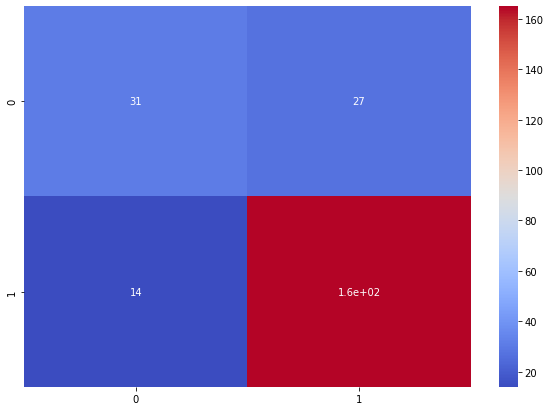

In [ ]:
print('Accuracy:',accuracy_score(true_labels,predictions_list))
print('Weighted Accuracy:',weighted_accuracy_scorer(true_labels,predictions_list))
print('F1 Score:',f1_score(true_labels,predictions_list))

# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'SimpleClassificationNN','Accuracy Score':accuracy_score(true_labels,predictions_list),'F1 Score':f1_score(true_labels,predictions_list),'Weighted Accuracy':weighted_accuracy_scorer(true_labels,predictions_list),'Confusion matrix':confusion_matrix(true_labels,predictions_list)}, ignore_index = True)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
generate_confusion_matrix(true_labels,predictions_list)

### **LSTM**

#### Train & choose hyperparameters

In [ ]:

# best_LSTM, best_LSTM_hyperparams = optimize_hyperparameters_on_grid(model_args_dict = {"hidden_dim":[1, 10, 20],
#                                                                 "n_tokens" :50,
#                                                                              "output_dim":2},
#                                                                training_loop_args_dict= {"dataloader":training_dataloader,
#                                                                                     "loss_function":[torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([2, 1])),
#                                                                                                      torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([4, 1])),
#                                                                                                      torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([10, 1]))],
#                                                                                     "validation_batch":[validation_batch],
#                                                                                     "accuracy_func":accuracy_of_torch_model,
#                                                                                     "optimizer":"Adam",
#                                                                                     "optimizer_args":{"lr":0.01},
#                                                                                     "scheduler":"ReduceLROnPlateau",
#                                                                                     "scheduler_args":{"factor":0.01, "patience":10},
#                                                                                     "epochs":200,
#                                                                                     "early_stopping_steps":15,
#                                                                                     "device":"cpu"},
#                                                                model_type = MyLSTM,
#                                                                n_trials = 1)


# state_dict_to_save = get_model_state_dict_copy_excluding_ebd(best_LSTM)
# pickle_to_drive(state_dict_to_save, 
#                 name =  "best_LSTM_state_dict.pickle",
#                 file_id = "1rJviVOSsQDQLqoQ8XKGwjGdNiir6O6Ca")
# pickle_to_drive(best_LSTM_hyperparams,
#                 name = "best_LSTM_hyperparams",
#                 file_id = "1RQSzpvdJd7cK65Q8ky1_c8wcwzWum2J6")



Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:01<00:00, 22.76it/s]

Training loss: 0.697349  [  825/ 2137]
LR = 0.01
Validation loss = 0.61351078748703 | Validation accuracy = 0.8227847814559937



Epoch 1 : 100%|██████████| 34/34 [00:01<00:00, 23.02it/s]

Training loss: 0.592218  [  825/ 2137]
LR = 0.01
Validation loss = 0.6121450066566467 | Validation accuracy = 0.8227847814559937



Epoch 2 : 100%|██████████| 34/34 [00:01<00:00, 23.64it/s]

Training loss: 0.747554  [  825/ 2137]
LR = 0.01
Validation loss = 0.6126478910446167 | Validation accuracy = 0.8227847814559937



Epoch 3 : 100%|██████████| 34/34 [00:01<00:00, 23.62it/s]

Training loss: 0.546328  [  825/ 2137]
LR = 0.01
Validation loss = 0.6044614315032959 | Validation accuracy = 0.8227847814559937



Epoch 4 : 100%|██████████| 34/34 [00:01<00:00, 23.35it/s]

Training loss: 0.656674  [  825/ 2137]
LR = 0.01
Validation loss = 0.5988479852676392 | Validation accuracy = 0.8227847814559937



Epoch 5 : 100%|██████████| 34/34 [00:01<00:00, 23.08it/s]

Training loss: 0.623955  [  825/ 2137]
LR = 0.01
Validation loss = 0.5907045006752014 | Validation accuracy = 0.8227847814559937



Epoch 6 : 100%|██████████| 34/34 [00:01<00:00, 23.51it/s]

Training loss: 0.724063  [  825/ 2137]
LR = 0.01
Validation loss = 0.5677856802940369 | Validation accuracy = 0.8227847814559937



Epoch 7 : 100%|██████████| 34/34 [00:01<00:00, 23.76it/s]

Training loss: 0.503331  [  825/ 2137]
LR = 0.01
Validation loss = 0.5496505498886108 | Validation accuracy = 0.8312236070632935



Epoch 8 : 100%|██████████| 34/34 [00:01<00:00, 22.70it/s]

Training loss: 0.525688  [  825/ 2137]
LR = 0.01
Validation loss = 0.5516417622566223 | Validation accuracy = 0.7383966445922852



Epoch 9 : 100%|██████████| 34/34 [00:01<00:00, 23.06it/s]

Training loss: 0.477536  [  825/ 2137]
LR = 0.01
Validation loss = 0.5475862622261047 | Validation accuracy = 0.7805907130241394



Epoch 10 : 100%|██████████| 34/34 [00:01<00:00, 23.31it/s]

Training loss: 0.509620  [  825/ 2137]
LR = 0.01
Validation loss = 0.531356692314148 | Validation accuracy = 0.8185654282569885



Epoch 11 : 100%|██████████| 34/34 [00:01<00:00, 23.44it/s]

Training loss: 0.451091  [  825/ 2137]
LR = 0.01
Validation loss = 0.5263742208480835 | Validation accuracy = 0.8227847814559937



Epoch 12 : 100%|██████████| 34/34 [00:01<00:00, 23.66it/s]

Training loss: 0.543285  [  825/ 2137]
LR = 0.01
Validation loss = 0.5322732329368591 | Validation accuracy = 0.8185654282569885



Epoch 13 : 100%|██████████| 34/34 [00:01<00:00, 23.65it/s]

Training loss: 0.438327  [  825/ 2137]
LR = 0.01
Validation loss = 0.5190643072128296 | Validation accuracy = 0.8312236070632935



Epoch 14 : 100%|██████████| 34/34 [00:01<00:00, 23.22it/s]

Training loss: 0.489311  [  825/ 2137]
LR = 0.01
Validation loss = 0.5123944878578186 | Validation accuracy = 0.8438818454742432



Epoch 15 : 100%|██████████| 34/34 [00:01<00:00, 23.92it/s]

Training loss: 0.510551  [  825/ 2137]
LR = 0.01
Validation loss = 0.5177711248397827 | Validation accuracy = 0.8227847814559937



Epoch 16 : 100%|██████████| 34/34 [00:01<00:00, 24.03it/s]

Training loss: 0.454779  [  825/ 2137]
LR = 0.01
Validation loss = 0.516229510307312 | Validation accuracy = 0.8185654282569885



Epoch 17 : 100%|██████████| 34/34 [00:01<00:00, 24.08it/s]

Training loss: 0.497156  [  825/ 2137]
LR = 0.01
Validation loss = 0.5152381062507629 | Validation accuracy = 0.8312236070632935



Epoch 18 : 100%|██████████| 34/34 [00:01<00:00, 23.83it/s]

Training loss: 0.346532  [  825/ 2137]
LR = 0.01
Validation loss = 0.5059247016906738 | Validation accuracy = 0.8270041942596436



Epoch 19 : 100%|██████████| 34/34 [00:01<00:00, 24.07it/s]

Training loss: 0.467396  [  825/ 2137]
LR = 0.01
Validation loss = 0.49628588557243347 | Validation accuracy = 0.8438818454742432



Epoch 20 : 100%|██████████| 34/34 [00:01<00:00, 23.98it/s]

Training loss: 0.608928  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4959031045436859 | Validation accuracy = 0.8438818454742432



Epoch 21 : 100%|██████████| 34/34 [00:01<00:00, 23.64it/s]

Training loss: 0.451065  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4968903660774231 | Validation accuracy = 0.8438818454742432



Epoch 22 : 100%|██████████| 34/34 [00:01<00:00, 23.84it/s]

Training loss: 0.487512  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4988216757774353 | Validation accuracy = 0.8481012582778931



Epoch 23 : 100%|██████████| 34/34 [00:01<00:00, 24.11it/s]

Training loss: 0.439505  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5021515488624573 | Validation accuracy = 0.8312236070632935



Epoch 24 : 100%|██████████| 34/34 [00:01<00:00, 23.83it/s]

Training loss: 0.509701  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5036637783050537 | Validation accuracy = 0.8270041942596436



Epoch 25 : 100%|██████████| 34/34 [00:01<00:00, 23.95it/s]

Training loss: 0.559636  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5047856569290161 | Validation accuracy = 0.8270041942596436



Epoch 26 : 100%|██████████| 34/34 [00:01<00:00, 22.86it/s]

Training loss: 0.351960  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5057010054588318 | Validation accuracy = 0.8270041942596436



Epoch 27 : 100%|██████████| 34/34 [00:01<00:00, 23.32it/s]

Training loss: 0.416893  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5060127377510071 | Validation accuracy = 0.8270041942596436



Epoch 28 : 100%|██████████| 34/34 [00:01<00:00, 23.14it/s]

Training loss: 0.495370  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5060825943946838 | Validation accuracy = 0.8270041942596436



Epoch 29 : 100%|██████████| 34/34 [00:01<00:00, 23.39it/s]

Training loss: 0.419813  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5061362385749817 | Validation accuracy = 0.8270041942596436



Epoch 30 : 100%|██████████| 34/34 [00:01<00:00, 23.22it/s]

Training loss: 0.436503  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5060865879058838 | Validation accuracy = 0.8270041942596436



Epoch 31 : 100%|██████████| 34/34 [00:01<00:00, 23.30it/s]

Training loss: 0.435977  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5060862898826599 | Validation accuracy = 0.8270041942596436



Epoch 32 : 100%|██████████| 34/34 [00:01<00:00, 22.54it/s]

Training loss: 0.451116  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5060865879058838 | Validation accuracy = 0.8270041942596436



Epoch 33 : 100%|██████████| 34/34 [00:01<00:00, 23.57it/s]

Training loss: 0.422110  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5060862898826599 | Validation accuracy = 0.8270041942596436



Epoch 34 : 100%|██████████| 34/34 [00:01<00:00, 23.47it/s]

Training loss: 0.491154  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5060865879058838 | Validation accuracy = 0.8270041942596436



Epoch 35 : 100%|██████████| 34/34 [00:01<00:00, 23.04it/s]

Training loss: 0.508795  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5060867071151733 | Validation accuracy = 0.8270041942596436



Epoch 36 : 100%|██████████| 34/34 [00:01<00:00, 23.10it/s]

Training loss: 0.438133  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5060861706733704 | Validation accuracy = 0.8270041942596436



Epoch 37 : 100%|██████████| 34/34 [00:01<00:00, 23.42it/s]


Training loss: 0.476582  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5060865879058838 | Validation accuracy = 0.8270041942596436
Early stopping after epoch 37
Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:01<00:00, 22.87it/s]

Training loss: 0.682664  [  825/ 2137]
LR = 0.01
Validation loss = 0.6910713911056519 | Validation accuracy = 0.8227847814559937



Epoch 1 : 100%|██████████| 34/34 [00:01<00:00, 22.52it/s]

Training loss: 0.690663  [  825/ 2137]
LR = 0.01
Validation loss = 0.6915342807769775 | Validation accuracy = 0.8227847814559937



Epoch 2 : 100%|██████████| 34/34 [00:01<00:00, 22.95it/s]

Training loss: 0.692827  [  825/ 2137]
LR = 0.01
Validation loss = 0.6883331537246704 | Validation accuracy = 0.8227847814559937



Epoch 3 : 100%|██████████| 34/34 [00:01<00:00, 22.85it/s]

Training loss: 0.636575  [  825/ 2137]
LR = 0.01
Validation loss = 0.5919417142868042 | Validation accuracy = 0.7299578189849854



Epoch 4 : 100%|██████████| 34/34 [00:01<00:00, 22.48it/s]

Training loss: 0.469966  [  825/ 2137]
LR = 0.01
Validation loss = 0.582030177116394 | Validation accuracy = 0.746835470199585



Epoch 5 : 100%|██████████| 34/34 [00:01<00:00, 22.40it/s]

Training loss: 0.713192  [  825/ 2137]
LR = 0.01
Validation loss = 0.6128265261650085 | Validation accuracy = 0.8143460154533386



Epoch 6 : 100%|██████████| 34/34 [00:01<00:00, 22.55it/s]

Training loss: 0.609410  [  825/ 2137]
LR = 0.01
Validation loss = 0.5678760409355164 | Validation accuracy = 0.6835442781448364



Epoch 7 : 100%|██████████| 34/34 [00:01<00:00, 22.77it/s]

Training loss: 0.439450  [  825/ 2137]
LR = 0.01
Validation loss = 0.5493307113647461 | Validation accuracy = 0.7299578189849854



Epoch 8 : 100%|██████████| 34/34 [00:01<00:00, 22.89it/s]

Training loss: 0.472588  [  825/ 2137]
LR = 0.01
Validation loss = 0.5399090647697449 | Validation accuracy = 0.797468364238739



Epoch 9 : 100%|██████████| 34/34 [00:01<00:00, 23.17it/s]

Training loss: 0.540381  [  825/ 2137]
LR = 0.01
Validation loss = 0.5419061183929443 | Validation accuracy = 0.8227847814559937



Epoch 10 : 100%|██████████| 34/34 [00:01<00:00, 22.82it/s]

Training loss: 0.457644  [  825/ 2137]
LR = 0.01
Validation loss = 0.539811372756958 | Validation accuracy = 0.7848101258277893



Epoch 11 : 100%|██████████| 34/34 [00:01<00:00, 22.82it/s]

Training loss: 0.489875  [  825/ 2137]
LR = 0.01
Validation loss = 0.5287653207778931 | Validation accuracy = 0.7848101258277893



Epoch 12 : 100%|██████████| 34/34 [00:01<00:00, 23.68it/s]

Training loss: 0.540905  [  825/ 2137]
LR = 0.01
Validation loss = 0.5427486300468445 | Validation accuracy = 0.7088607549667358



Epoch 13 : 100%|██████████| 34/34 [00:01<00:00, 23.64it/s]

Training loss: 0.444530  [  825/ 2137]
LR = 0.01
Validation loss = 0.5437025427818298 | Validation accuracy = 0.7594936490058899



Epoch 14 : 100%|██████████| 34/34 [00:01<00:00, 22.78it/s]

Training loss: 0.535837  [  825/ 2137]
LR = 0.01
Validation loss = 0.5449744462966919 | Validation accuracy = 0.7172995805740356



Epoch 15 : 100%|██████████| 34/34 [00:01<00:00, 23.01it/s]

Training loss: 0.384456  [  825/ 2137]
LR = 0.01
Validation loss = 0.5549067854881287 | Validation accuracy = 0.7426160573959351
Early stopping after epoch 15
Using device cpu
Size of validation batch = 237



Epoch 0 : 100%|██████████| 34/34 [00:01<00:00, 22.53it/s]

Training loss: 0.556293  [  825/ 2137]
LR = 0.01
Validation loss = 0.6274351477622986 | Validation accuracy = 0.17721518874168396



Epoch 1 : 100%|██████████| 34/34 [00:01<00:00, 22.41it/s]

Training loss: 0.714337  [  825/ 2137]
LR = 0.01
Validation loss = 0.6252188682556152 | Validation accuracy = 0.17721518874168396



Epoch 2 : 100%|██████████| 34/34 [00:01<00:00, 22.50it/s]

Training loss: 0.528458  [  825/ 2137]
LR = 0.01
Validation loss = 0.6257466077804565 | Validation accuracy = 0.17721518874168396



Epoch 3 : 100%|██████████| 34/34 [00:01<00:00, 22.68it/s]

Training loss: 0.809073  [  825/ 2137]
LR = 0.01
Validation loss = 0.6249266862869263 | Validation accuracy = 0.17721518874168396



Epoch 4 : 100%|██████████| 34/34 [00:01<00:00, 22.87it/s]

Training loss: 0.655855  [  825/ 2137]
LR = 0.01
Validation loss = 0.6065223217010498 | Validation accuracy = 0.3670886158943176



Epoch 5 : 100%|██████████| 34/34 [00:01<00:00, 22.63it/s]

Training loss: 0.531373  [  825/ 2137]
LR = 0.01
Validation loss = 0.5646568536758423 | Validation accuracy = 0.3206751048564911



Epoch 6 : 100%|██████████| 34/34 [00:01<00:00, 22.13it/s]

Training loss: 0.460318  [  825/ 2137]
LR = 0.01
Validation loss = 0.5397104024887085 | Validation accuracy = 0.5316455960273743



Epoch 7 : 100%|██████████| 34/34 [00:01<00:00, 22.87it/s]

Training loss: 0.456348  [  825/ 2137]
LR = 0.01
Validation loss = 0.5122325420379639 | Validation accuracy = 0.5991561412811279



Epoch 8 : 100%|██████████| 34/34 [00:01<00:00, 23.03it/s]

Training loss: 0.462023  [  825/ 2137]
LR = 0.01
Validation loss = 0.5220178365707397 | Validation accuracy = 0.6413502097129822



Epoch 9 : 100%|██████████| 34/34 [00:01<00:00, 22.59it/s]

Training loss: 0.398516  [  825/ 2137]
LR = 0.01
Validation loss = 0.5185940861701965 | Validation accuracy = 0.6118143200874329



Epoch 10 : 100%|██████████| 34/34 [00:01<00:00, 22.73it/s]

Training loss: 0.513295  [  825/ 2137]
LR = 0.01
Validation loss = 0.5659390091896057 | Validation accuracy = 0.6666666865348816



Epoch 11 : 100%|██████████| 34/34 [00:01<00:00, 21.74it/s]

Training loss: 0.551608  [  825/ 2137]
LR = 0.01
Validation loss = 0.580671489238739 | Validation accuracy = 0.7130801677703857



Epoch 12 : 100%|██████████| 34/34 [00:01<00:00, 21.59it/s]

Training loss: 0.418417  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5637734532356262 | Validation accuracy = 0.7046413421630859



Epoch 13 : 100%|██████████| 34/34 [00:01<00:00, 22.16it/s]

Training loss: 0.446380  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5545065999031067 | Validation accuracy = 0.6962025165557861



Epoch 14 : 100%|██████████| 34/34 [00:01<00:00, 22.43it/s]

Training loss: 0.405921  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5492035746574402 | Validation accuracy = 0.6919831037521362



Epoch 15 : 100%|██████████| 34/34 [00:01<00:00, 22.11it/s]

Training loss: 0.494548  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5414497256278992 | Validation accuracy = 0.6835442781448364



Epoch 16 : 100%|██████████| 34/34 [00:01<00:00, 22.34it/s]

Training loss: 0.500023  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5344255566596985 | Validation accuracy = 0.6835442781448364



Epoch 17 : 100%|██████████| 34/34 [00:01<00:00, 21.82it/s]

Training loss: 0.542703  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5319090485572815 | Validation accuracy = 0.6835442781448364



Epoch 18 : 100%|██████████| 34/34 [00:01<00:00, 22.66it/s]

Training loss: 0.390054  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5305530428886414 | Validation accuracy = 0.6793248653411865



Epoch 19 : 100%|██████████| 34/34 [00:01<00:00, 22.45it/s]

Training loss: 0.402761  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5299707651138306 | Validation accuracy = 0.6751055121421814



Epoch 20 : 100%|██████████| 34/34 [00:01<00:00, 22.33it/s]

Training loss: 0.462651  [  825/ 2137]
LR = 0.0001
Validation loss = 0.528801441192627 | Validation accuracy = 0.6708860993385315



Epoch 21 : 100%|██████████| 34/34 [00:01<00:00, 22.89it/s]

Training loss: 0.346072  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5286402106285095 | Validation accuracy = 0.6708860993385315



Epoch 22 : 100%|██████████| 34/34 [00:01<00:00, 22.84it/s]

Training loss: 0.477607  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5283369421958923 | Validation accuracy = 0.6708860993385315



Epoch 23 : 100%|██████████| 34/34 [00:01<00:00, 22.40it/s]

Training loss: 0.545623  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5283342003822327 | Validation accuracy = 0.6708860993385315



Epoch 24 : 100%|██████████| 34/34 [00:01<00:00, 22.55it/s]

Training loss: 0.453933  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5283284783363342 | Validation accuracy = 0.6708860993385315



Epoch 25 : 100%|██████████| 34/34 [00:01<00:00, 22.83it/s]

Training loss: 0.417918  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5283318161964417 | Validation accuracy = 0.6708860993385315



Epoch 26 : 100%|██████████| 34/34 [00:01<00:00, 22.74it/s]


Training loss: 0.425187  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5283289551734924 | Validation accuracy = 0.6708860993385315
Early stopping after epoch 26
Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:02<00:00, 16.41it/s]

Training loss: 0.462640  [  825/ 2137]
LR = 0.01
Validation loss = 0.6122352480888367 | Validation accuracy = 0.8227847814559937



Epoch 1 : 100%|██████████| 34/34 [00:02<00:00, 16.40it/s]

Training loss: 0.556476  [  825/ 2137]
LR = 0.01
Validation loss = 0.5951709747314453 | Validation accuracy = 0.8227847814559937



Epoch 2 : 100%|██████████| 34/34 [00:02<00:00, 16.85it/s]

Training loss: 0.569583  [  825/ 2137]
LR = 0.01
Validation loss = 0.6049209833145142 | Validation accuracy = 0.6582278609275818



Epoch 3 : 100%|██████████| 34/34 [00:02<00:00, 16.73it/s]


Training loss: 0.600798  [  825/ 2137]
LR = 0.01
Validation loss = 0.5875611305236816 | Validation accuracy = 0.8227847814559937


Epoch 4 : 100%|██████████| 34/34 [00:02<00:00, 16.44it/s]

Training loss: 0.584435  [  825/ 2137]
LR = 0.01
Validation loss = 0.5691050887107849 | Validation accuracy = 0.8143460154533386



Epoch 5 : 100%|██████████| 34/34 [00:02<00:00, 16.36it/s]

Training loss: 0.450817  [  825/ 2137]
LR = 0.01
Validation loss = 0.5707436203956604 | Validation accuracy = 0.7763713002204895



Epoch 6 : 100%|██████████| 34/34 [00:02<00:00, 16.33it/s]

Training loss: 0.539098  [  825/ 2137]
LR = 0.01
Validation loss = 0.5506318807601929 | Validation accuracy = 0.7890295386314392



Epoch 7 : 100%|██████████| 34/34 [00:02<00:00, 16.63it/s]

Training loss: 0.623552  [  825/ 2137]
LR = 0.01
Validation loss = 0.537162721157074 | Validation accuracy = 0.8101266026496887



Epoch 8 : 100%|██████████| 34/34 [00:02<00:00, 16.75it/s]

Training loss: 0.609456  [  825/ 2137]
LR = 0.01
Validation loss = 0.5360624194145203 | Validation accuracy = 0.8227847814559937



Epoch 9 : 100%|██████████| 34/34 [00:02<00:00, 16.65it/s]

Training loss: 0.572714  [  825/ 2137]
LR = 0.01
Validation loss = 0.5379047989845276 | Validation accuracy = 0.8312236070632935



Epoch 10 : 100%|██████████| 34/34 [00:02<00:00, 16.54it/s]


Training loss: 0.649226  [  825/ 2137]
LR = 0.01
Validation loss = 0.5441518425941467 | Validation accuracy = 0.8354430198669434


Epoch 11 : 100%|██████████| 34/34 [00:02<00:00, 16.57it/s]

Training loss: 0.504106  [  825/ 2137]
LR = 0.01
Validation loss = 0.5432393550872803 | Validation accuracy = 0.8270041942596436



Epoch 12 : 100%|██████████| 34/34 [00:02<00:00, 16.61it/s]

Training loss: 0.552606  [  825/ 2137]
LR = 0.01
Validation loss = 0.5566986799240112 | Validation accuracy = 0.7890295386314392



Epoch 13 : 100%|██████████| 34/34 [00:02<00:00, 16.32it/s]

Training loss: 0.468705  [  825/ 2137]
LR = 0.01
Validation loss = 0.5527313351631165 | Validation accuracy = 0.7637130618095398



Epoch 14 : 100%|██████████| 34/34 [00:02<00:00, 16.28it/s]

Training loss: 0.513765  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5405693054199219 | Validation accuracy = 0.797468364238739



Epoch 15 : 100%|██████████| 34/34 [00:02<00:00, 16.92it/s]

Training loss: 0.380155  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5403702259063721 | Validation accuracy = 0.797468364238739



Epoch 16 : 100%|██████████| 34/34 [00:02<00:00, 16.63it/s]

Training loss: 0.421122  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5407463312149048 | Validation accuracy = 0.8016877770423889



Epoch 17 : 100%|██████████| 34/34 [00:02<00:00, 16.68it/s]

Training loss: 0.402590  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5393766760826111 | Validation accuracy = 0.8059071898460388



Epoch 18 : 100%|██████████| 34/34 [00:02<00:00, 16.69it/s]


Training loss: 0.437985  [  825/ 2137]
LR = 0.0001
Validation loss = 0.537659764289856 | Validation accuracy = 0.8101266026496887


Epoch 19 : 100%|██████████| 34/34 [00:02<00:00, 16.54it/s]

Training loss: 0.456267  [  825/ 2137]
LR = 0.0001
Validation loss = 0.533760666847229 | Validation accuracy = 0.8143460154533386



Epoch 20 : 100%|██████████| 34/34 [00:02<00:00, 16.90it/s]

Training loss: 0.444822  [  825/ 2137]
LR = 0.0001
Validation loss = 0.533536970615387 | Validation accuracy = 0.8143460154533386



Epoch 21 : 100%|██████████| 34/34 [00:02<00:00, 16.54it/s]

Training loss: 0.347630  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5346788763999939 | Validation accuracy = 0.8143460154533386



Epoch 22 : 100%|██████████| 34/34 [00:02<00:00, 16.34it/s]

Training loss: 0.435881  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5326836109161377 | Validation accuracy = 0.8143460154533386



Epoch 23 : 100%|██████████| 34/34 [00:02<00:00, 16.81it/s]


Training loss: 0.348221  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5315285325050354 | Validation accuracy = 0.8143460154533386


Epoch 24 : 100%|██████████| 34/34 [00:02<00:00, 16.99it/s]

Training loss: 0.407297  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5307037234306335 | Validation accuracy = 0.8143460154533386



Epoch 25 : 100%|██████████| 34/34 [00:02<00:00, 16.77it/s]


Training loss: 0.583860  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5306931138038635 | Validation accuracy = 0.8143460154533386
Early stopping after epoch 25
Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:02<00:00, 15.92it/s]

Training loss: 0.680597  [  825/ 2137]
LR = 0.01
Validation loss = 0.6666489839553833 | Validation accuracy = 0.5907173156738281



Epoch 1 : 100%|██████████| 34/34 [00:02<00:00, 16.29it/s]

Training loss: 0.510565  [  825/ 2137]
LR = 0.01
Validation loss = 0.5665613412857056 | Validation accuracy = 0.7637130618095398



Epoch 2 : 100%|██████████| 34/34 [00:02<00:00, 16.63it/s]

Training loss: 0.667180  [  825/ 2137]
LR = 0.01
Validation loss = 0.5562395453453064 | Validation accuracy = 0.7805907130241394



Epoch 3 : 100%|██████████| 34/34 [00:02<00:00, 16.52it/s]

Training loss: 0.435022  [  825/ 2137]
LR = 0.01
Validation loss = 0.525874137878418 | Validation accuracy = 0.7383966445922852



Epoch 4 : 100%|██████████| 34/34 [00:02<00:00, 16.44it/s]

Training loss: 0.496279  [  825/ 2137]
LR = 0.01
Validation loss = 0.5640299916267395 | Validation accuracy = 0.6666666865348816



Epoch 5 : 100%|██████████| 34/34 [00:02<00:00, 16.13it/s]


Training loss: 0.576398  [  825/ 2137]
LR = 0.01
Validation loss = 0.5329654216766357 | Validation accuracy = 0.6835442781448364


Epoch 6 : 100%|██████████| 34/34 [00:02<00:00, 16.40it/s]

Training loss: 0.624887  [  825/ 2137]
LR = 0.01
Validation loss = 0.539995551109314 | Validation accuracy = 0.6877636909484863



Epoch 7 : 100%|██████████| 34/34 [00:02<00:00, 16.61it/s]


Training loss: 0.680171  [  825/ 2137]
LR = 0.01
Validation loss = 0.5474950075149536 | Validation accuracy = 0.8185654282569885


Epoch 8 : 100%|██████████| 34/34 [00:02<00:00, 16.18it/s]

Training loss: 0.454024  [  825/ 2137]
LR = 0.01
Validation loss = 0.5266345143318176 | Validation accuracy = 0.8185654282569885



Epoch 9 : 100%|██████████| 34/34 [00:02<00:00, 16.34it/s]

Training loss: 0.443935  [  825/ 2137]
LR = 0.01
Validation loss = 0.5539665222167969 | Validation accuracy = 0.7172995805740356



Epoch 10 : 100%|██████████| 34/34 [00:02<00:00, 16.36it/s]


Training loss: 0.528696  [  825/ 2137]
LR = 0.01
Validation loss = 0.5304791331291199 | Validation accuracy = 0.852320671081543


Epoch 11 : 100%|██████████| 34/34 [00:02<00:00, 16.19it/s]

Training loss: 0.417576  [  825/ 2137]
LR = 0.01
Validation loss = 0.5271387696266174 | Validation accuracy = 0.7763713002204895



Epoch 12 : 100%|██████████| 34/34 [00:02<00:00, 16.02it/s]

Training loss: 0.491621  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5232546329498291 | Validation accuracy = 0.7932489514350891



Epoch 13 : 100%|██████████| 34/34 [00:02<00:00, 16.47it/s]

Training loss: 0.504492  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5206871628761292 | Validation accuracy = 0.8059071898460388



Epoch 14 : 100%|██████████| 34/34 [00:01<00:00, 17.29it/s]

Training loss: 0.410892  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5196585059165955 | Validation accuracy = 0.8101266026496887



Epoch 15 : 100%|██████████| 34/34 [00:02<00:00, 16.80it/s]


Training loss: 0.384383  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5195167660713196 | Validation accuracy = 0.8143460154533386


Epoch 16 : 100%|██████████| 34/34 [00:01<00:00, 17.15it/s]

Training loss: 0.351856  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5195465087890625 | Validation accuracy = 0.8143460154533386



Epoch 17 : 100%|██████████| 34/34 [00:01<00:00, 17.10it/s]

Training loss: 0.425176  [  825/ 2137]
LR = 0.0001
Validation loss = 0.519312858581543 | Validation accuracy = 0.8143460154533386



Epoch 18 : 100%|██████████| 34/34 [00:02<00:00, 16.67it/s]

Training loss: 0.363514  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5199871063232422 | Validation accuracy = 0.8185654282569885



Epoch 19 : 100%|██████████| 34/34 [00:02<00:00, 14.75it/s]

Training loss: 0.490988  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5207399129867554 | Validation accuracy = 0.8185654282569885



Epoch 20 : 100%|██████████| 34/34 [00:02<00:00, 15.72it/s]

Training loss: 0.515162  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5216952562332153 | Validation accuracy = 0.8185654282569885



Epoch 21 : 100%|██████████| 34/34 [00:02<00:00, 16.04it/s]

Training loss: 0.356390  [  825/ 2137]
LR = 0.0001
Validation loss = 0.522813081741333 | Validation accuracy = 0.8143460154533386



Epoch 22 : 100%|██████████| 34/34 [00:02<00:00, 16.16it/s]

Training loss: 0.379027  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5238305330276489 | Validation accuracy = 0.8143460154533386



Epoch 23 : 100%|██████████| 34/34 [00:02<00:00, 16.40it/s]

Training loss: 0.461300  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5238397121429443 | Validation accuracy = 0.8143460154533386



Epoch 24 : 100%|██████████| 34/34 [00:02<00:00, 16.27it/s]

Training loss: 0.318199  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5238516926765442 | Validation accuracy = 0.8143460154533386



Epoch 25 : 100%|██████████| 34/34 [00:02<00:00, 16.52it/s]


Training loss: 0.675299  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.5238568186759949 | Validation accuracy = 0.8143460154533386
Early stopping after epoch 25
Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:02<00:00, 16.24it/s]

Training loss: 0.848145  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 1 : 100%|██████████| 34/34 [00:02<00:00, 16.17it/s]

Training loss: 0.736339  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 2 : 100%|██████████| 34/34 [00:02<00:00, 16.10it/s]

Training loss: 0.553768  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 3 : 100%|██████████| 34/34 [00:02<00:00, 16.15it/s]

Training loss: 0.517807  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 4 : 100%|██████████| 34/34 [00:02<00:00, 15.92it/s]

Training loss: 0.598976  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 5 : 100%|██████████| 34/34 [00:02<00:00, 16.10it/s]

Training loss: 0.598976  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 6 : 100%|██████████| 34/34 [00:02<00:00, 16.09it/s]

Training loss: 0.598976  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 7 : 100%|██████████| 34/34 [00:02<00:00, 16.03it/s]


Training loss: 0.517807  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396


Epoch 8 : 100%|██████████| 34/34 [00:02<00:00, 16.14it/s]

Training loss: 1.019144  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 9 : 100%|██████████| 34/34 [00:02<00:00, 16.19it/s]

Training loss: 0.517807  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 10 : 100%|██████████| 34/34 [00:02<00:00, 15.92it/s]

Training loss: 0.517807  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 11 : 100%|██████████| 34/34 [00:02<00:00, 15.91it/s]

Training loss: 0.736339  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 12 : 100%|██████████| 34/34 [00:02<00:00, 16.24it/s]

Training loss: 0.736339  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 13 : 100%|██████████| 34/34 [00:02<00:00, 15.82it/s]


Training loss: 0.488519  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396


Epoch 14 : 100%|██████████| 34/34 [00:02<00:00, 16.20it/s]

Training loss: 0.736339  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 15 : 100%|██████████| 34/34 [00:02<00:00, 16.34it/s]


Training loss: 0.657524  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396
Early stopping after epoch 15
Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:02<00:00, 13.62it/s]

Training loss: 0.781739  [  825/ 2137]
LR = 0.01
Validation loss = 0.6384433507919312 | Validation accuracy = 0.6540084481239319



Epoch 1 : 100%|██████████| 34/34 [00:02<00:00, 13.76it/s]

Training loss: 0.552218  [  825/ 2137]
LR = 0.01
Validation loss = 0.5670329332351685 | Validation accuracy = 0.8101266026496887



Epoch 2 : 100%|██████████| 34/34 [00:02<00:00, 13.86it/s]

Training loss: 0.571346  [  825/ 2137]
LR = 0.01
Validation loss = 0.5218268036842346 | Validation accuracy = 0.8270041942596436



Epoch 3 : 100%|██████████| 34/34 [00:02<00:00, 12.00it/s]


Training loss: 0.560946  [  825/ 2137]
LR = 0.01
Validation loss = 0.5771498084068298 | Validation accuracy = 0.8354430198669434


Epoch 4 : 100%|██████████| 34/34 [00:05<00:00,  6.24it/s]

Training loss: 0.552862  [  825/ 2137]
LR = 0.01
Validation loss = 0.5419763922691345 | Validation accuracy = 0.7510548233985901



Epoch 5 : 100%|██████████| 34/34 [00:02<00:00, 13.66it/s]

Training loss: 0.483200  [  825/ 2137]
LR = 0.01
Validation loss = 0.534288763999939 | Validation accuracy = 0.7679324746131897



Epoch 6 : 100%|██████████| 34/34 [00:02<00:00, 13.82it/s]

Training loss: 0.568771  [  825/ 2137]
LR = 0.01
Validation loss = 0.5275763273239136 | Validation accuracy = 0.75527423620224



Epoch 7 : 100%|██████████| 34/34 [00:02<00:00, 13.82it/s]

Training loss: 0.480911  [  825/ 2137]
LR = 0.01
Validation loss = 0.49021872878074646 | Validation accuracy = 0.8059071898460388



Epoch 8 : 100%|██████████| 34/34 [00:02<00:00, 14.00it/s]

Training loss: 0.566206  [  825/ 2137]
LR = 0.01
Validation loss = 0.5048247575759888 | Validation accuracy = 0.8185654282569885



Epoch 9 : 100%|██████████| 34/34 [00:02<00:00, 14.23it/s]

Training loss: 0.362570  [  825/ 2137]
LR = 0.01
Validation loss = 0.4913482666015625 | Validation accuracy = 0.8354430198669434



Epoch 10 : 100%|██████████| 34/34 [00:02<00:00, 13.79it/s]

Training loss: 0.454141  [  825/ 2137]
LR = 0.01
Validation loss = 0.4773067235946655 | Validation accuracy = 0.8565400838851929



Epoch 11 : 100%|██████████| 34/34 [00:02<00:00, 14.04it/s]

Training loss: 0.377801  [  825/ 2137]
LR = 0.01
Validation loss = 0.48820677399635315 | Validation accuracy = 0.8227847814559937



Epoch 12 : 100%|██████████| 34/34 [00:02<00:00, 14.33it/s]

Training loss: 0.351721  [  825/ 2137]
LR = 0.0001
Validation loss = 0.48229920864105225 | Validation accuracy = 0.8396624326705933



Epoch 13 : 100%|██████████| 34/34 [00:02<00:00, 14.23it/s]

Training loss: 0.451553  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4743570387363434 | Validation accuracy = 0.852320671081543



Epoch 14 : 100%|██████████| 34/34 [00:02<00:00, 14.18it/s]

Training loss: 0.400072  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4714193046092987 | Validation accuracy = 0.852320671081543



Epoch 15 : 100%|██████████| 34/34 [00:02<00:00, 13.90it/s]

Training loss: 0.556745  [  825/ 2137]
LR = 0.0001
Validation loss = 0.47103527188301086 | Validation accuracy = 0.8607594966888428



Epoch 16 : 100%|██████████| 34/34 [00:02<00:00, 11.60it/s]

Training loss: 0.384717  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4706069231033325 | Validation accuracy = 0.8649789094924927



Epoch 17 : 100%|██████████| 34/34 [00:02<00:00, 14.25it/s]

Training loss: 0.387181  [  825/ 2137]
LR = 0.0001
Validation loss = 0.46946099400520325 | Validation accuracy = 0.8691983222961426



Epoch 18 : 100%|██████████| 34/34 [00:02<00:00, 14.17it/s]

Training loss: 0.521159  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4689612090587616 | Validation accuracy = 0.8649789094924927



Epoch 19 : 100%|██████████| 34/34 [00:02<00:00, 14.58it/s]

Training loss: 0.378610  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4688414931297302 | Validation accuracy = 0.8691983222961426



Epoch 20 : 100%|██████████| 34/34 [00:02<00:00, 13.87it/s]

Training loss: 0.348800  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4686359167098999 | Validation accuracy = 0.8691983222961426



Epoch 21 : 100%|██████████| 34/34 [00:02<00:00, 14.29it/s]

Training loss: 0.363003  [  825/ 2137]
LR = 0.0001
Validation loss = 0.4683772325515747 | Validation accuracy = 0.8691983222961426



Epoch 22 : 100%|██████████| 34/34 [00:02<00:00, 13.88it/s]

Training loss: 0.313410  [  825/ 2137]
LR = 0.0001
Validation loss = 0.46940043568611145 | Validation accuracy = 0.8691983222961426



Epoch 23 : 100%|██████████| 34/34 [00:02<00:00, 13.86it/s]

Training loss: 0.449235  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.46939873695373535 | Validation accuracy = 0.8691983222961426



Epoch 24 : 100%|██████████| 34/34 [00:02<00:00, 14.15it/s]

Training loss: 0.390593  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.46939635276794434 | Validation accuracy = 0.8691983222961426



Epoch 25 : 100%|██████████| 34/34 [00:02<00:00, 14.23it/s]

Training loss: 0.330019  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4693950116634369 | Validation accuracy = 0.8691983222961426



Epoch 26 : 100%|██████████| 34/34 [00:02<00:00, 14.13it/s]

Training loss: 0.418239  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.46939370036125183 | Validation accuracy = 0.8691983222961426



Epoch 27 : 100%|██████████| 34/34 [00:02<00:00, 14.40it/s]

Training loss: 0.313643  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4693925678730011 | Validation accuracy = 0.8691983222961426



Epoch 28 : 100%|██████████| 34/34 [00:02<00:00, 14.22it/s]

Training loss: 0.518902  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.46938905119895935 | Validation accuracy = 0.8691983222961426



Epoch 29 : 100%|██████████| 34/34 [00:02<00:00, 14.31it/s]

Training loss: 0.418072  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.46938812732696533 | Validation accuracy = 0.8691983222961426



Epoch 30 : 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]

Training loss: 0.487743  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.4693852365016937 | Validation accuracy = 0.8691983222961426



Epoch 31 : 100%|██████████| 34/34 [00:02<00:00, 14.39it/s]

Training loss: 0.391093  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.469382107257843 | Validation accuracy = 0.8691983222961426



Epoch 32 : 100%|██████████| 34/34 [00:02<00:00, 14.43it/s]


Training loss: 0.598864  [  825/ 2137]
LR = 1.0000000000000002e-06
Validation loss = 0.46938031911849976 | Validation accuracy = 0.8691983222961426
Early stopping after epoch 32
Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:02<00:00, 14.00it/s]

Training loss: 0.636596  [  825/ 2137]
LR = 0.01
Validation loss = 0.6629666686058044 | Validation accuracy = 0.5611814260482788



Epoch 1 : 100%|██████████| 34/34 [00:02<00:00, 14.40it/s]

Training loss: 0.512371  [  825/ 2137]
LR = 0.01
Validation loss = 0.5609714984893799 | Validation accuracy = 0.7721518874168396



Epoch 2 : 100%|██████████| 34/34 [00:02<00:00, 14.12it/s]

Training loss: 0.719067  [  825/ 2137]
LR = 0.01
Validation loss = 0.5336093902587891 | Validation accuracy = 0.7383966445922852



Epoch 3 : 100%|██████████| 34/34 [00:02<00:00, 14.41it/s]

Training loss: 0.468888  [  825/ 2137]
LR = 0.01
Validation loss = 0.4764661490917206 | Validation accuracy = 0.8438818454742432



Epoch 4 : 100%|██████████| 34/34 [00:02<00:00, 14.04it/s]

Training loss: 0.485599  [  825/ 2137]
LR = 0.01
Validation loss = 0.47470059990882874 | Validation accuracy = 0.8185654282569885



Epoch 5 : 100%|██████████| 34/34 [00:02<00:00, 14.36it/s]

Training loss: 0.359838  [  825/ 2137]
LR = 0.01
Validation loss = 0.46934306621551514 | Validation accuracy = 0.8649789094924927



Epoch 6 : 100%|██████████| 34/34 [00:02<00:00, 14.16it/s]

Training loss: 0.406907  [  825/ 2137]
LR = 0.01
Validation loss = 0.5264371633529663 | Validation accuracy = 0.7088607549667358



Epoch 7 : 100%|██████████| 34/34 [00:02<00:00, 14.40it/s]

Training loss: 0.466183  [  825/ 2137]
LR = 0.01
Validation loss = 0.5311758518218994 | Validation accuracy = 0.8607594966888428



Epoch 8 : 100%|██████████| 34/34 [00:02<00:00, 14.21it/s]

Training loss: 0.328239  [  825/ 2137]
LR = 0.01
Validation loss = 0.47472715377807617 | Validation accuracy = 0.8143460154533386



Epoch 9 : 100%|██████████| 34/34 [00:02<00:00, 14.07it/s]

Training loss: 0.361676  [  825/ 2137]
LR = 0.01
Validation loss = 0.5042092800140381 | Validation accuracy = 0.8607594966888428



Epoch 10 : 100%|██████████| 34/34 [00:02<00:00, 13.99it/s]

Training loss: 0.371551  [  825/ 2137]
LR = 0.01
Validation loss = 0.5067083239555359 | Validation accuracy = 0.8312236070632935



Epoch 11 : 100%|██████████| 34/34 [00:02<00:00, 13.67it/s]

Training loss: 0.374992  [  825/ 2137]
LR = 0.01
Validation loss = 0.5069179534912109 | Validation accuracy = 0.8607594966888428



Epoch 12 : 100%|██████████| 34/34 [00:02<00:00, 14.18it/s]

Training loss: 0.405160  [  825/ 2137]
LR = 0.0001
Validation loss = 0.504057765007019 | Validation accuracy = 0.8607594966888428



Epoch 13 : 100%|██████████| 34/34 [00:02<00:00, 14.21it/s]

Training loss: 0.365243  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5025042295455933 | Validation accuracy = 0.8607594966888428



Epoch 14 : 100%|██████████| 34/34 [00:02<00:00, 13.97it/s]

Training loss: 0.362047  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5007919669151306 | Validation accuracy = 0.8649789094924927



Epoch 15 : 100%|██████████| 34/34 [00:02<00:00, 14.01it/s]

Training loss: 0.315310  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5004478693008423 | Validation accuracy = 0.8649789094924927



Epoch 16 : 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]

Training loss: 0.395680  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5005925297737122 | Validation accuracy = 0.8649789094924927



Epoch 17 : 100%|██████████| 34/34 [00:02<00:00, 14.21it/s]

Training loss: 0.475934  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5007364749908447 | Validation accuracy = 0.8649789094924927



Epoch 18 : 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]

Training loss: 0.319231  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5009270906448364 | Validation accuracy = 0.8649789094924927



Epoch 19 : 100%|██████████| 34/34 [00:02<00:00, 14.37it/s]

Training loss: 0.471713  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5012799501419067 | Validation accuracy = 0.8649789094924927



Epoch 20 : 100%|██████████| 34/34 [00:02<00:00, 14.44it/s]


Training loss: 0.465482  [  825/ 2137]
LR = 0.0001
Validation loss = 0.5012474060058594 | Validation accuracy = 0.8649789094924927
Early stopping after epoch 20
Using device cpu
Size of validation batch = 237


Epoch 0 : 100%|██████████| 34/34 [00:02<00:00, 13.61it/s]

Training loss: 0.657524  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 1 : 100%|██████████| 34/34 [00:03<00:00, 11.25it/s]

Training loss: 0.657524  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 2 : 100%|██████████| 34/34 [00:03<00:00, 10.72it/s]

Training loss: 0.553768  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 3 : 100%|██████████| 34/34 [00:03<00:00, 10.60it/s]

Training loss: 0.736339  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 4 : 100%|██████████| 34/34 [00:03<00:00, 10.79it/s]

Training loss: 0.848145  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 5 : 100%|██████████| 34/34 [00:03<00:00, 10.67it/s]

Training loss: 0.488519  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 6 : 100%|██████████| 34/34 [00:03<00:00, 10.83it/s]

Training loss: 0.657524  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 7 : 100%|██████████| 34/34 [00:03<00:00, 10.63it/s]

Training loss: 0.736339  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 8 : 100%|██████████| 34/34 [00:03<00:00, 10.70it/s]

Training loss: 0.598976  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 9 : 100%|██████████| 34/34 [00:03<00:00, 10.62it/s]

Training loss: 0.736339  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 10 : 100%|██████████| 34/34 [00:03<00:00, 10.68it/s]

Training loss: 0.517807  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 11 : 100%|██████████| 34/34 [00:03<00:00, 10.63it/s]

Training loss: 0.657524  [  825/ 2137]
LR = 0.01
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 12 : 100%|██████████| 34/34 [00:03<00:00, 10.79it/s]

Training loss: 0.488519  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 13 : 100%|██████████| 34/34 [00:03<00:00, 10.86it/s]

Training loss: 0.657524  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 14 : 100%|██████████| 34/34 [00:03<00:00, 10.80it/s]

Training loss: 0.657524  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396



Epoch 15 : 100%|██████████| 34/34 [00:03<00:00, 10.80it/s]


Training loss: 0.553768  [  825/ 2137]
LR = 0.0001
Validation loss = 0.6303347945213318 | Validation accuracy = 0.17721518874168396
Early stopping after epoch 15
Best model performance 0.8691983222961426
Uploaded file best_LSTM_state_dict.pickle with file_id 1rJviVOSsQDQLqoQ8XKGwjGdNiir6O6Ca
Uploaded file best_LSTM_hyperparams with file_id 1RQSzpvdJd7cK65Q8ky1_c8wcwzWum2J6


#### Load model & display results

In [ ]:
include_ebd_in_state_dict(load_pickle_from_drive(file_id = "1rJviVOSsQDQLqoQ8XKGwjGdNiir6O6Ca"))

Downloaded file best_LSTM_state_dict.pickle with file_id 1rJviVOSsQDQLqoQ8XKGwjGdNiir6O6Ca


In [ ]:
best_LSTM_hyperparams = load_pickle_from_drive(file_id = "1RQSzpvdJd7cK65Q8ky1_c8wcwzWum2J6")
best_LSTM_state_dict = load_pickle_from_drive(file_id = "1rJviVOSsQDQLqoQ8XKGwjGdNiir6O6Ca")
include_ebd_in_state_dict(best_LSTM_state_dict)

best_LSTM = MyLSTM(**best_LSTM_hyperparams)
best_LSTM.load_state_dict(best_LSTM_state_dict)

soft_predictions = best_LSTM(validation_batch[0])
predictions = torch.max(soft_predictions, 1)[1]

predictions_list = list(map(int, predictions))
true_labels = list(map(int, validation_batch[1]))

Downloaded file best_LSTM_hyperparams with file_id 1RQSzpvdJd7cK65Q8ky1_c8wcwzWum2J6
Downloaded file best_LSTM_state_dict.pickle with file_id 1rJviVOSsQDQLqoQ8XKGwjGdNiir6O6Ca


Accuracy: 0.8945147679324894
Weighted Accuracy: 0.6855133885571181
F1 Score: 0.931129476584022


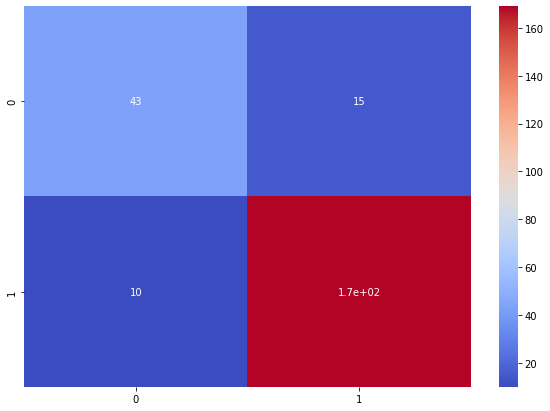

In [ ]:
print('Accuracy:',accuracy_score(true_labels,predictions_list))
print('Weighted Accuracy:',weighted_accuracy_scorer(true_labels,predictions_list))
print('F1 Score:',f1_score(true_labels,predictions_list))

# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'LSTM','Accuracy Score':accuracy_score(true_labels,predictions_list),'F1 Score':f1_score(true_labels,predictions_list),'Weighted Accuracy':weighted_accuracy_scorer(true_labels,predictions_list),'Confusion matrix':confusion_matrix(true_labels,predictions_list)}, ignore_index = True)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
generate_confusion_matrix(true_labels,predictions_list)

### BERT

#### Load BERT training and validation data

In [ ]:
### Uncomment to create BERT train and validation data ###

dataset_bert = BertDataset(df=df_Magazines, tokenizer=BertTokenizer)

train_dataloader_bert, validation_batch_bert = prepare_training(dataset_bert)

pickle_to_drive(train_dataloader_bert, 
                name = "train_dataloader_bert.pickle", 
                file_id = "1UWhDIr7JiafxFF2GLIGBYicyqkuPMKUW")
pickle_to_drive(validation_batch_bert, 
                name = "validation_batch_bert.pickle",
                file_id = "1l_s6yae0Twui16-oWITbcyVudDccwQpc")

Uploaded file train_dataloader_bert.pickle with file_id 1UWhDIr7JiafxFF2GLIGBYicyqkuPMKUW
Uploaded file validation_batch_bert.pickle with file_id 1l_s6yae0Twui16-oWITbcyVudDccwQpc


In [ ]:
train_dataloader_bert = load_pickle_from_drive(file_id = "1UWhDIr7JiafxFF2GLIGBYicyqkuPMKUW")
validation_batch_bert = load_pickle_from_drive(file_id = "1l_s6yae0Twui16-oWITbcyVudDccwQpc")

Downloaded file train_dataloader_bert.pickle with file_id 1UWhDIr7JiafxFF2GLIGBYicyqkuPMKUW
Downloaded file validation_batch_bert.pickle with file_id 1l_s6yae0Twui16-oWITbcyVudDccwQpc


#### Train BERT

In [ ]:
### Define model, optimizer, dataloader, validation batch and scheduler

# bert_model = transformers.AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels = 2)

# optimizer = torch.optim.AdamW(params = bert_model.parameters(), lr = 5e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, factor = 0.1, patience = 5)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [ ]:
### Train BERT

# num_epochs = 4


# progress_bar = tqdm.tqdm(range(num_epochs * len(train_dataloader_bert)))

# bert_model.train()
# for epoch in range(num_epochs):
#     losses_epoch = []
#     for batch in train_dataloader_bert:
#         outputs = bert_model(**batch)
#         loss = outputs[0]
#         losses_epoch.append(float(loss))
#         loss.backward()
#         optimizer.zero_grad()
#         optimizer.step()
#         scheduler.step(loss)
#         progress_bar.update(1)
#     print(f"Epoch {epoch} -- Training loss = {np.mean(losses_epoch)}")
#     current_accuracy = float(accuracy_bert(bert_model, validation_batch_bert))
#     print(f"Epoch {epoch} -- Validation accuracy = {current_accuracy}")
    
# bert_state_dict = bert_model.state_dict()
# pickle_to_drive(bert_state_dict, 
#                 name = "bert_state_dict",
#                 file_id = "1XjCTi_eX3MAVZ5xlByhaqMGHfyyzcHgU")


 25%|██▌       | 34/136 [02:22<06:00,  3.54s/it]

Epoch 0 -- Training loss = 0.6467006960335899
Epoch 0 -- Validation accuracy = 0.7890295386314392


 50%|█████     | 68/136 [05:00<04:15,  3.75s/it]

Epoch 1 -- Training loss = 0.6479125531280742
Epoch 1 -- Validation accuracy = 0.7426160573959351


 75%|███████▌  | 102/136 [07:31<02:02,  3.62s/it]

Epoch 2 -- Training loss = 0.6441822648048401
Epoch 2 -- Validation accuracy = 0.7679324746131897


100%|██████████| 136/136 [10:11<00:00,  3.74s/it]

Epoch 3 -- Training loss = 0.6458988838336047
Epoch 3 -- Validation accuracy = 0.7426160573959351
Uploaded file bert_state_dict with file_id 1XjCTi_eX3MAVZ5xlByhaqMGHfyyzcHgU


#### Evaluate BERT

In [ ]:
# load pretrained bert model
bert_model = transformers.AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels = 2)
# load bert parameters
bert_model.load_state_dict(load_pickle_from_drive(file_id = "1XjCTi_eX3MAVZ5xlByhaqMGHfyyzcHgU"))

soft_predictions = torch.FloatTensor(bert_model(**validation_batch_bert).logits)
predictions = torch.max(soft_predictions, 1).indices

predictions_list = list(map(int, predictions))
true_labels = list(map(int, validation_batch_bert["labels"]))

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Downloaded file bert_state_dict with file_id 1XjCTi_eX3MAVZ5xlByhaqMGHfyyzcHgU


Accuracy: 0.7721518987341772
Weighted Accuracy: -0.006737967914438592
F1 Score: 0.8708133971291865


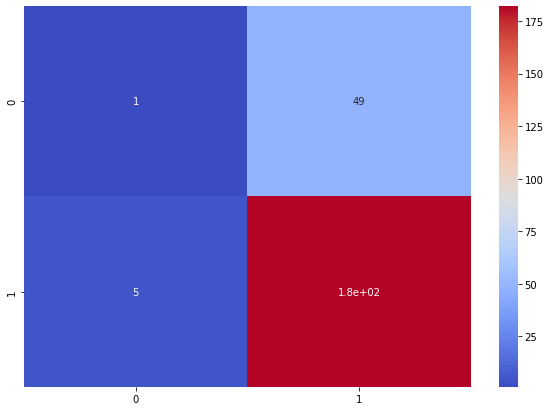

In [ ]:
print('Accuracy:',accuracy_score(true_labels,predictions_list))
print('Weighted Accuracy:',weighted_accuracy_scorer(true_labels,predictions_list))
print('F1 Score:',f1_score(true_labels,predictions_list))

# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'BERT','Accuracy Score':accuracy_score(true_labels,predictions_list),'F1 Score':f1_score(true_labels,predictions_list),'Weighted Accuracy':weighted_accuracy_scorer(true_labels,predictions_list),'Confusion matrix':confusion_matrix(true_labels,predictions_list)}, ignore_index = True)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
generate_confusion_matrix(true_labels,predictions_list)

## **Finding the best model for the sparse wordcount matrix classification problem**
In this part we will try to tune hyperparameters in several configurations in order to find the optimal method for our datasets. We will perform binary classification and multi-label classification (with 5 classes). We will test 3 different types of models:
*  Random Forest Classifiers
*  Linear Discrimination Analysis
*  Support Vector Classifiers

For each model we will observe different configurations:
*  Unweighted model
*  Weighted model
*  Rebalanced set
*  Limited number of features

In [17]:
# Processing the data
classif_type = 'bin'
df = df_Magazines
X, y = process_data(df = df, classif_type = classif_type)

In [ ]:
score_df = pd.read_excel('')

#### **Naive classification**
We first print the accruracy and weighted accuracy for random classification and "constant" classification

accuracy score: 0.6736842105263158
f1 score: 0.7989623865110247
weighted accuracy: -0.07025316455696196


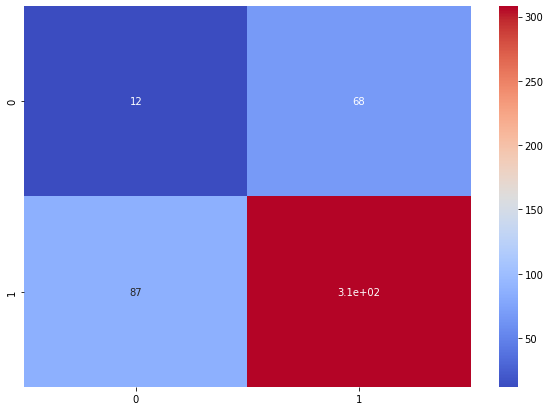

In [ ]:
# Random classification: we take the frequency of each class in the training set and classify each comment in the test set randomly while keeping the same frequency.
r = 0.8
X_train, y_train, X_test, y_test = split_train_test(X, y, r)
p = np.count_nonzero(y_train)/len(y_train)
y_pred = np.random.binomial(size = len(y_test), n = 1, p = p)


print('accuracy score:',accuracy_score(y_test,y_pred))
print('f1 score:',f1_score(y_test,y_pred))
print('weighted accuracy:',weighted_accuracy_scorer(y_test,y_pred))
# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'Random Naive','Accuracy Score':accuracy_score(y_test,y_pred),'F1 Score':f1_score(y_test,y_pred),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred)),'Confusion matrix':confusion_matrix(y_test,y_pred)}, ignore_index = True)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
generate_confusion_matrix(y_test,y_pred)

accuracy score: 0.8315789473684211
f1 score: 0.9080459770114944
weighted accuracy: 0.0


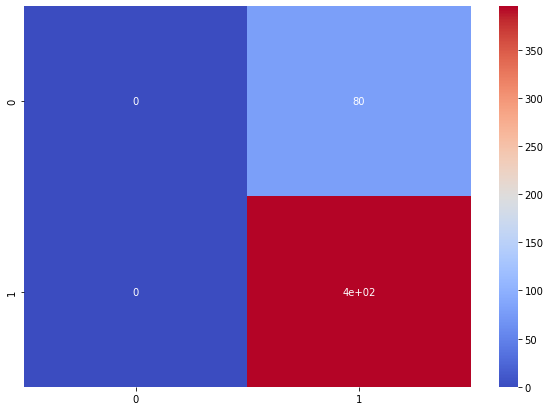

In [27]:
# Unique: all predictions are equal to 1
r = 0.8
X_train, y_train, X_test, y_test = split_train_test(X, y, r)
y_pred = np.ones(len(y_test))

print('accuracy score:',accuracy_score(y_test,y_pred))
print('f1 score:',f1_score(y_test,y_pred))
print('weighted accuracy:',weighted_accuracy_scorer(y_test,y_pred))
# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'Unique Prediction','Accuracy Score':accuracy_score(y_test,y_pred),'F1 Score':f1_score(y_test,y_pred),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred)),'Confusion matrix':confusion_matrix(y_test,y_pred)}, ignore_index = True)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
generate_confusion_matrix(y_test,y_pred)

### **Random Forest Classification**
In this part we want to test different settings for random forest classification on the available datasets.  
We will adjust several parameters and operate under different configurations:  


*   Number of trees and depth of each tree
*   Weights and rebalanced dataset
*   Number of features (restriction to the most frequent words)
*   Binary classification vs. 1-to-5 classification

In [34]:
# BERT occasionnally makes the notebook crash. We have stored accuracies values for the first models in an external file
score_df = pd.read_excel('NNModels.xlsx')
score_df

,Unnamed: 0,Name,Accuracy Score,F1 Score,Weighted Accuracy,Confusion matrix,Parameters
0,0,SimpleClassificationNN,0.827004,0.889488,0.456270,[[ 31 27]\n [ 14 165]],NaN
1,1,LSTM,0.894515,0.931129,0.685513,[[ 43 15]\n [ 10 169]],NaN
2,2,BERT,0.772152,0.870813,-0.006738,[[ 1 49]\n [ 5 182]],NaN
3,3,Random Naive,0.682105,0.806162,-0.080063,[[ 10 70]\n [ 81 314]],NaN


#### **Regular Random Forest Classification**

In [ ]:
### Run to directly create the optimal model
# Split between train et test set
r = 0.8
X_train, y_train, X_test, y_test = split_train_test(X, y, r)

param_dict = {'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
model = RandomForestClassifier(**param_dict)

In [37]:
### Don't run (grid search)

# Create a grid to tune the random forest hyperparameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Split between train et test set
r = 0.8
X_train, y_train, X_test, y_test = split_train_test(X, y, r)

In [39]:
### Don't run (grid search)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_model = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(rf_model, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, scoring = make_scorer(weighted_accuracy_scorer))
# Fit the random search model
model = clf_random.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  13.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  10.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  22.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  20.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  16.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  18.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20

In [42]:
# print optimal set of hyperparameters
rf_parameters = model.best_estimator_.get_params()
pprint(model.best_estimator_.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


accuracy score: 0.9094736842105263
f1 score: 0.947239263803681
weighted accuracy: 0.5522151898734178


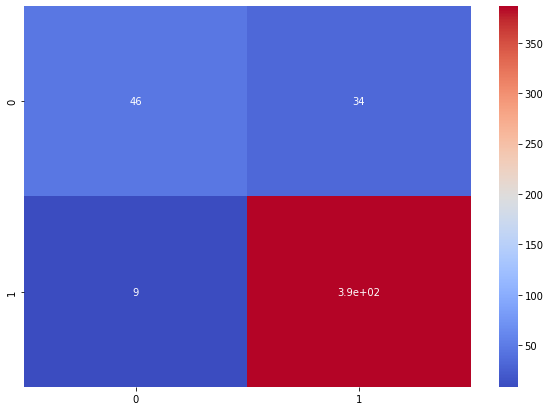

In [41]:
# Use the fitted model to make a predict on the test set
y_pred = model.predict(X_test)

print('accuracy score:',accuracy_score(y_test,y_pred))
print('f1 score:',f1_score(y_test,y_pred))
print('weighted accuracy:',weighted_accuracy_scorer(y_test,y_pred))
# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'RF','Accuracy Score':accuracy_score(y_test,y_pred),'F1 Score':f1_score(y_test,y_pred),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred)),'Confusion matrix':confusion_matrix(y_test,y_pred),'Parameters':rf_parameters}, ignore_index = True)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
generate_confusion_matrix(y_test,y_pred)

In the following parts, we will adapt the Random Forest model and explore other classification models to mitigate the classification error on negative reviews.

#### **Random Forest Classification using a rebalanced set**
Our datasets are heavily unbalanced. In this subpart, we use ```balance_dataset``` to balance the train set. We try several ratios for the optimal set of paramaters that we have found in the first part.





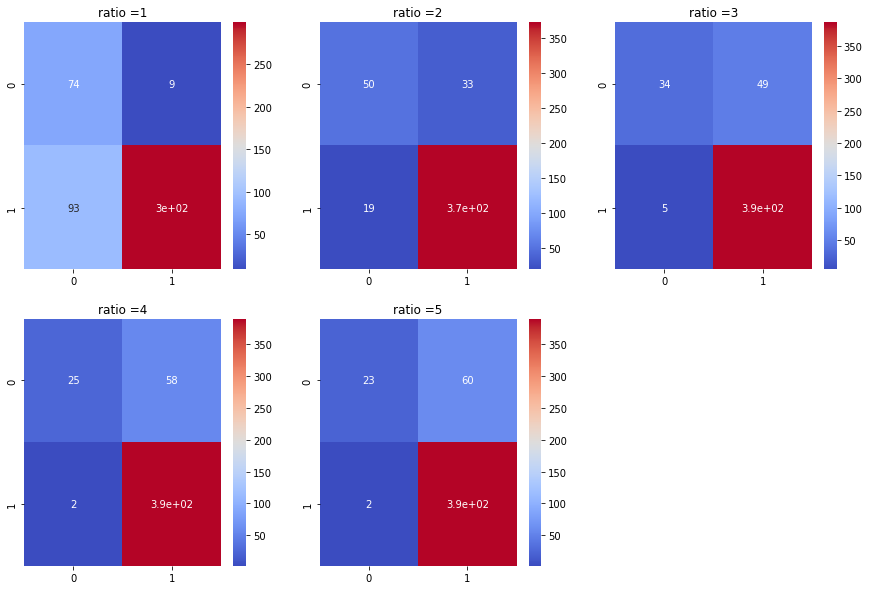

In [46]:
ratios = [1,2,3,4,5]
scores_b, f1_scores_b, weighted_accuracy_b = [], [], []


plt.figure(figsize = (15,10))
for ratio in ratios:
  X, y = process_data(df = df, classif_type = classif_type)
  clf_r = model.best_estimator_

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
  
  X_train, y_train = balance_dataset(X_train, y_train, max_min_ratio = ratio)
  clf_r.fit(X_train, y_train)
  y_pred = clf_r.predict(X_test)


  plt.subplot(int(sqrt(len(ratios))),1+int(sqrt(len(ratios))),ratio)
  generate_confusion_matrix(y_test,y_pred, title = "ratio ="+str(ratio))
  
  
  f1_scores_b.append(f1_score(y_test,y_pred))
  scores_b.append(accuracy_score(y_test,y_pred))
  weighted_accuracy_b.append(weighted_accuracy_s(confusion_matrix(y_test,y_pred)))

###**Balance ratio between classes vs. accuracy score**

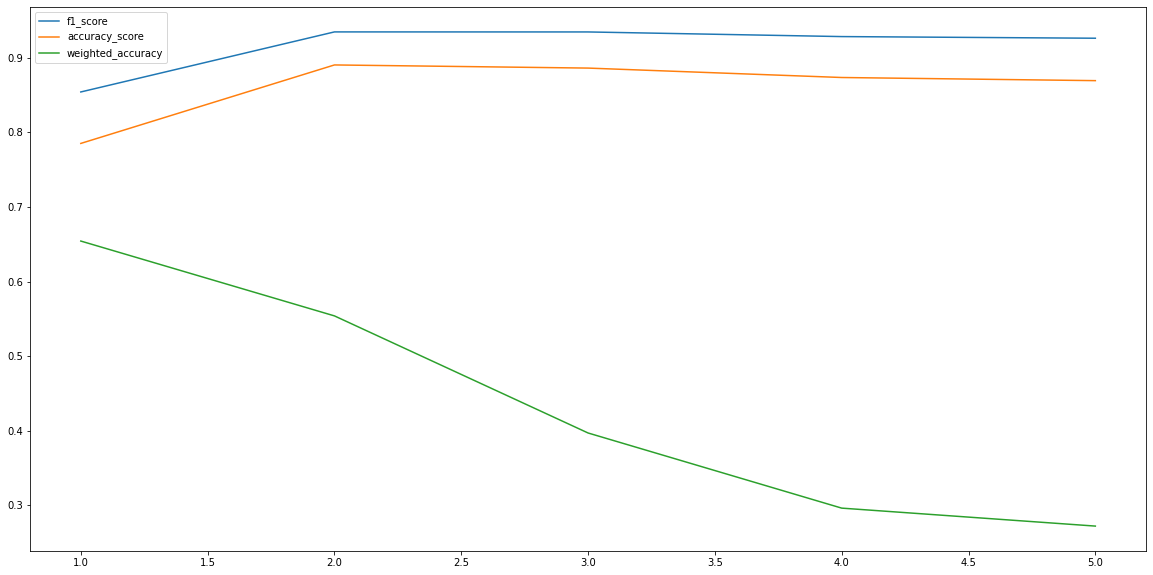

In [47]:
display(Markdown('###**Balance ratio between classes vs. accuracy score**'))

plt.plot(ratios,f1_scores_b, label = 'f1_score')
plt.plot(ratios,scores_b, label = 'accuracy_score')
plt.plot(ratios, weighted_accuracy_b, label ='weighted_accuracy')
plt.legend()
plt.show()

Ratio = 1
accuracy score: 0.7810526315789473
f1 score: 0.85014409221902
Weighted Accuracy: 0.6682136710105729


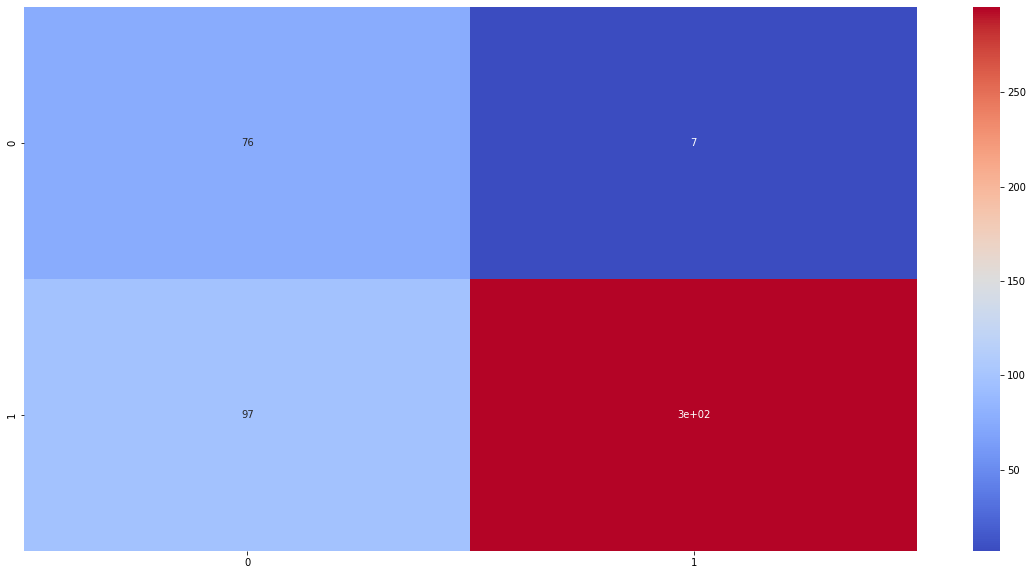

In [48]:
best_ratio = np.argmax(weighted_accuracy_b)+1

# Use the fitted model to make a predict on the test set
X, y = process_data(df = df, classif_type = classif_type)
clf_r = model.best_estimator_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
X_train, y_train = balance_dataset(X_train, y_train, max_min_ratio = best_ratio)
clf_r.fit(X_train, y_train)
y_pred_r = clf_r.predict(X_test)

print('Ratio =',best_ratio)
print('accuracy score:',accuracy_score(y_test,y_pred_r))
print('f1 score:',f1_score(y_test,y_pred_r))
print('Weighted Accuracy:',weighted_accuracy_s(confusion_matrix(y_test,y_pred_r)))
# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'RF (balance ratio = '+ str(best_ratio)+')','Accuracy Score':accuracy_score(y_test,y_pred_r),'F1 Score':f1_score(y_test,y_pred_r),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred_r)),'Confusion matrix':confusion_matrix(y_test,y_pred_r),'Parameters':clf_r.get_params()},ignore_index=True)

# Plot the confusion matrix
generate_confusion_matrix(y_test,y_pred_r)

Rebalancing the set increases the accuracy for negative reviews but at the expense of a larger error for positive reviews. Our weighted accuracy prioritizes models that correctly classify negative reviews.

#### **Random Forest Classification using weights**
Another solution for the unbalanced train set is to use a weighted model.

In [49]:
classif_type = 'bin'
weights = [i for i in range(50)]
scores_w, f1_scores_w = [], []
weighted_accuracy_w = []

for w in weights:
  X, y = process_data(df = df, classif_type = classif_type)

  clf_w = model.best_estimator_
  clf_w.set_params(class_weight={0: w, 1: 1})
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
  clf_w.fit(X_train, y_train)
  y_pred = clf_w.predict(X_test)
  f1_scores_w.append(f1_score(y_test,y_pred))
  scores_w.append(accuracy_score(y_test,y_pred))
  weighted_accuracy_w.append(confusion_matrix(y_test,y_pred))
  print('Weight:',w,' (',100*w/(len(weights)+1),'%)')

Weight: 0  ( 0.0 %)
Weight: 1  ( 1.9607843137254901 %)
Weight: 2  ( 3.9215686274509802 %)
Weight: 3  ( 5.882352941176471 %)
Weight: 4  ( 7.8431372549019605 %)
Weight: 5  ( 9.803921568627452 %)
Weight: 6  ( 11.764705882352942 %)
Weight: 7  ( 13.72549019607843 %)
Weight: 8  ( 15.686274509803921 %)
Weight: 9  ( 17.647058823529413 %)
Weight: 10  ( 19.607843137254903 %)
Weight: 11  ( 21.568627450980394 %)
Weight: 12  ( 23.529411764705884 %)
Weight: 13  ( 25.49019607843137 %)
Weight: 14  ( 27.45098039215686 %)
Weight: 15  ( 29.41176470588235 %)
Weight: 16  ( 31.372549019607842 %)
Weight: 17  ( 33.333333333333336 %)
Weight: 18  ( 35.294117647058826 %)
Weight: 19  ( 37.254901960784316 %)
Weight: 20  ( 39.21568627450981 %)
Weight: 21  ( 41.1764705882353 %)
Weight: 22  ( 43.13725490196079 %)
Weight: 23  ( 45.09803921568628 %)
Weight: 24  ( 47.05882352941177 %)
Weight: 25  ( 49.01960784313726 %)
Weight: 26  ( 50.98039215686274 %)
Weight: 27  ( 52.94117647058823 %)
Weight: 28  ( 54.90196078431372 

###**Weights between classes vs. accuracy score**

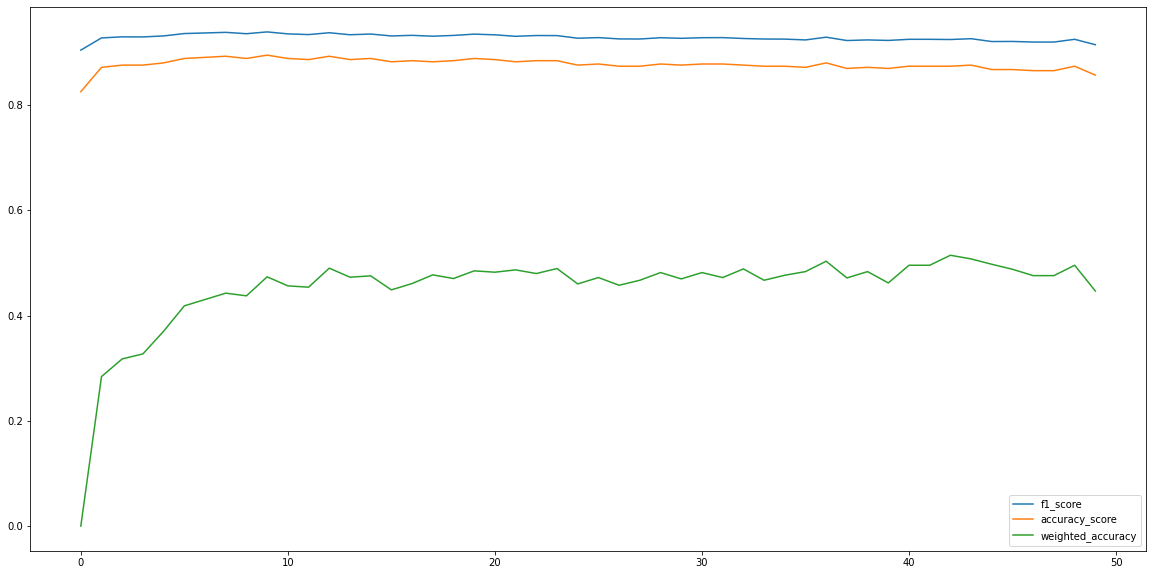

Optimal weight: 43


In [50]:
display(Markdown('###**Weights between classes vs. accuracy score**'))

weighted_accuracies = []
for i in range(len(weighted_accuracy_w)):
  weighted_accuracies.append(weighted_accuracy_s(weighted_accuracy_w[i]))

plt.plot(weights,f1_scores_w, label = 'f1_score')
plt.plot(weights,scores_w, label = 'accuracy_score')
plt.plot(weights,weighted_accuracies, label = 'weighted_accuracy')
plt.legend()
plt.show()
print('Optimal weight:',np.argmax(weighted_accuracies) + 1)

accuracy score: 0.8568421052631578
f1 score: 0.9152119700748129
weighted accuracy: 0.4181522006392918


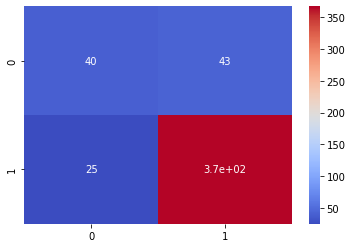

In [21]:
optimal_weight = np.argmax(weighted_accuracies) + 1 

# Use the fitted model to make a predict on the test set
X, y = process_data(df = df, classif_type = classif_type)
# clf_w = model.best_estimator_

# clf_w = RandomForestClassifier()
# clf_w.set_params(bootstrap = False, ccp_alpha = 0.0, class_weight = None, criterion = 'gini', max_depth =  None, max_features = 'sqrt', max_leaf_nodes = None, max_samples = None, min_impurity_decrease = 0.0,min_samples_leaf=  1,min_samples_split = 2,min_weight_fraction_leaf = 0.0,n_estimators =  400,n_jobs = None,oob_score= False,random_state = None,verbose = 0,warm_start = False)

clf_w.set_params(class_weight={0: optimal_weight, 1: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
clf_w.fit(X_train, y_train)
y_pred_w = clf_w.predict(X_test)


print('accuracy score:',accuracy_score(y_test,y_pred_w))
print('f1 score:',f1_score(y_test,y_pred_w))
print('weighted accuracy:',weighted_accuracy_scorer(y_test,y_pred_w))
# Append the scores to the score dataframe (to plot it at the end)
# score_df.append({'Name':'RF (weight = '+ optimal_weight,'Accuracy Score':accuracy_score(y_test,y_pred_w),'F1 Score':f1_score(y_test,y_pred_w)})

# Plot the confusion matrix
generate_confusion_matrix(y_test,y_pred_w)

We can perform another quick random search to tune the other parameters (random search result is directly implemented below to avoid training again)

In [22]:
# Create a grid to tune the random forest hyperparameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Split between train et test set
r = 0.8
X_train, y_train, X_test, y_test = split_train_test(X, y, r)

In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_model_w = RandomForestClassifier(class_weight={0: optimal_weight, 1: 1})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random_w = RandomizedSearchCV(rf_model_w, param_distributions = random_grid, n_iter = 50, cv = 2, verbose=2, random_state=42, scoring = make_scorer(weighted_accuracy_scorer))
# Fit the random search model
model_w = clf_random_w.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   8.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  17.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  23.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  17.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  15.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200

In [24]:
# print optimal set of hyperparameters (run if you perform grid search above)
pprint(model_w.best_estimator_.get_params())
param_grid = model_w.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': {0: 43, 1: 1},
 'criterion': 'gini',
 'max_depth': 110,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
### Run to get the optimal model

param_dict = {'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': {0: 43, 1: 1},
 'criterion': 'gini',
 'max_depth': 110,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
model_w = RandomForestClassifier(**param_dict)

accuracy score: 0.8126315789473684
f1 score: 0.8775790921595598
weighted accuracy: 0.6450949367088608


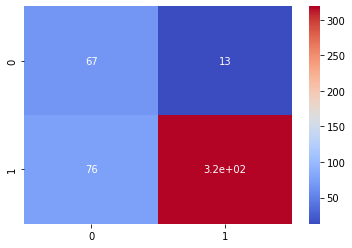

In [30]:
# Use the fitted model to make a predict on the test set
y_pred_w_optim = model_w.predict(X_test)

print('accuracy score:',accuracy_score(y_test,y_pred_w_optim))
print('f1 score:',f1_score(y_test,y_pred_w_optim))
print('weighted accuracy:',weighted_accuracy_scorer(y_test,y_pred_w_optim))
# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'RF (weights = '+str(optimal_weight)+')','Accuracy Score':accuracy_score(y_test,y_pred_w_optim),'F1 Score':f1_score(y_test,y_pred_w_optim),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred_w_optim)),'Confusion matrix':confusion_matrix(y_test,y_pred_w_optim),'Parameters':model_w.get_params()},ignore_index = True)

# Plot the confusion matrix
generate_confusion_matrix(y_test,y_pred_w_optim)

#### **Restricted number of features**
We will now train a weighted model processing the dataset with ```reduce_dataset``` function to train the Random Forest Classification on a restricted number of features. We split the data between positive reviews and negative reviews to identify the most important features for each class and restrict the features to those features.



In [33]:
### Run to tune the parameters

classif_type = 'bin'
n = 9
positive_features = [10*2**i for i in range(n)]
negative_features = [10*2**i for i in range(n)]
scores_f, f1_scores_f = np.zeros((n,n)), np.zeros((n,n))
weighted_accuracy_f = np.zeros((n,n))
confusion_matrix_matrix = {}

for i in range(len(positive_features)):
  for j in range(len(negative_features)):
    X, y = process_data(df = df, classif_type = classif_type)
    X = reduce_dataset(X, y, positive_limit = positive_features[i], negative_limit = negative_features[j])

    clf_restrict = RandomForestClassifier(**param_dict)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
    clf_restrict.fit(X_train, y_train)
    y_pred = clf_restrict.predict(X_test)
    f1_scores_f[i,j] = f1_score(y_test,y_pred)
    scores_f[i,j] = accuracy_score(y_test,y_pred)
    weighted_accuracy_f[i,j] = weighted_accuracy_s(confusion_matrix(y_test,y_pred))
    confusion_matrix_matrix[(positive_features[i],negative_features[j])] = confusion_matrix(y_test,y_pred)
    print('positive:',positive_features[i],'negative:',negative_features[j])

positive: 10 negative: 10
positive: 10 negative: 20
positive: 10 negative: 40
positive: 10 negative: 80
positive: 10 negative: 160
positive: 10 negative: 320
positive: 10 negative: 640
positive: 10 negative: 1280
positive: 10 negative: 2560
positive: 20 negative: 10
positive: 20 negative: 20
positive: 20 negative: 40
positive: 20 negative: 80
positive: 20 negative: 160
positive: 20 negative: 320
positive: 20 negative: 640
positive: 20 negative: 1280
positive: 20 negative: 2560
positive: 40 negative: 10
positive: 40 negative: 20
positive: 40 negative: 40
positive: 40 negative: 80
positive: 40 negative: 160
positive: 40 negative: 320
positive: 40 negative: 640
positive: 40 negative: 1280
positive: 40 negative: 2560
positive: 80 negative: 10
positive: 80 negative: 20
positive: 80 negative: 40
positive: 80 negative: 80
positive: 80 negative: 160
positive: 80 negative: 320
positive: 80 negative: 640
positive: 80 negative: 1280
positive: 80 negative: 2560
positive: 160 negative: 10
positive:

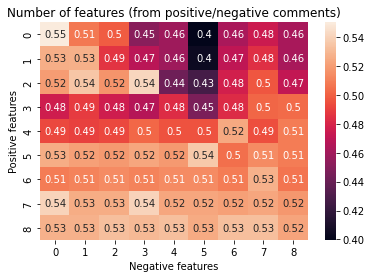

In [34]:
# Heatmap representation of the sizes vs scores
ax = sns.heatmap(weighted_accuracy_f, annot=True)
ax.set(xlabel='Negative features', ylabel='Positive features')
plt.title("Number of features (from positive/negative comments)",fontsize=12)

plt.savefig("visualize_positive_negative.png", bbox_inches='tight', dpi=100)

plt.show()

accuracy score: 0.8378947368421052
f1 score: 0.8988173455978975


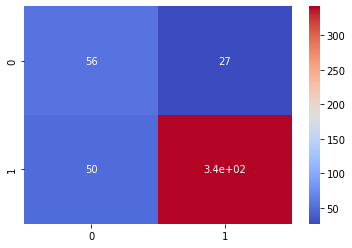

In [37]:
optimal_features =  [10*2**2,10*2**3]

# Use the fitted model to make a predict on the test set
X, y = process_data(df = df, classif_type = classif_type)
X = reduce_dataset(X, y, positive_limit = optimal_features[0], negative_limit = optimal_features[1])

clf_red = model_w.best_estimator_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
clf_red.fit(X_train, y_train)

y_pred_red = clf_red.predict(X_test)


print('accuracy score:',accuracy_score(y_test,y_pred_red))
print('f1 score:',f1_score(y_test,y_pred_red))
# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'RF (restriction = '+ str(optimal_features)+')','Accuracy Score':accuracy_score(y_test,y_pred_red),'F1 Score':f1_score(y_test,y_pred_red),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred_red)),'Confusion matrix':confusion_matrix(y_test,y_pred_red),'Parameters':model_w.best_estimator_.get_params()},ignore_index = True)

# Plot the confusion matrix
generate_confusion_matrix(y_test,y_pred_red)

### **Linear Discriminant Analysis**
We will now test LDA models to classify our dataset

accuracy score: 0.8694736842105263
weighted accuracy score: 0.6337025316455696


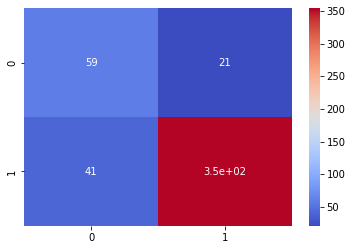

In [40]:
## LDA
classif_type = 'bin'
X, y = process_data(df = df, classif_type = classif_type)

# Split between train et test set
r = 0.8
X_train, y_train, X_test, y_test = split_train_test(X, y, r)

# Train the LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Compute accuracy and weighted accuracy
y_pred_lda = lda.predict(X_test)
print('accuracy score:',accuracy_score(y_test, y_pred_lda))
print('weighted accuracy score:',weighted_accuracy_scorer(y_test, y_pred_lda))

# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'LDA','Accuracy Score':accuracy_score(y_test,y_pred_lda),'F1 Score':f1_score(y_test,y_pred_lda),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred_lda)),'Confusion matrix':confusion_matrix(y_test,y_pred_lda)},ignore_index = True)


# Display confusion matrix
generate_confusion_matrix(y_test, y_pred_lda)

### **LDA with restricted number of features**

In [42]:
classif_type = 'bin'
n = 8
positive_features = [10*2**i for i in range(n)]
negative_features = [10*2**i for i in range(n)]
scores_f, f1_scores_f = np.zeros((n,n)), np.zeros((n,n))
weighted_accuracy_f = np.zeros((n,n))
confusion_matrix_matrix = {}

for i in range(len(positive_features)):
  for j in range(len(negative_features)):
    X, y = process_data(df = df, classif_type = classif_type)
    X = reduce_dataset(X, y, positive_limit = positive_features[i], negative_limit = negative_features[j])

    lda_restrict = LinearDiscriminantAnalysis()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
    lda_restrict.fit(X_train, y_train)
    y_pred = lda_restrict.predict(X_test)
    f1_scores_f[i,j] = f1_score(y_test,y_pred)
    scores_f[i,j] = accuracy_score(y_test,y_pred)
    weighted_accuracy_f[i,j] = weighted_accuracy_s(confusion_matrix(y_test,y_pred))
    confusion_matrix_matrix[(positive_features[i],negative_features[j])] = confusion_matrix(y_test,y_pred)
    print('positive:',positive_features[i],'negative:',negative_features[j])

positive: 10 negative: 10
positive: 10 negative: 20
positive: 10 negative: 40
positive: 10 negative: 80
positive: 10 negative: 160
positive: 10 negative: 320
positive: 10 negative: 640
positive: 10 negative: 1280
positive: 20 negative: 10
positive: 20 negative: 20
positive: 20 negative: 40
positive: 20 negative: 80
positive: 20 negative: 160
positive: 20 negative: 320
positive: 20 negative: 640
positive: 20 negative: 1280
positive: 40 negative: 10
positive: 40 negative: 20
positive: 40 negative: 40
positive: 40 negative: 80
positive: 40 negative: 160
positive: 40 negative: 320
positive: 40 negative: 640
positive: 40 negative: 1280
positive: 80 negative: 10
positive: 80 negative: 20
positive: 80 negative: 40
positive: 80 negative: 80
positive: 80 negative: 160
positive: 80 negative: 320
positive: 80 negative: 640
positive: 80 negative: 1280
positive: 160 negative: 10
positive: 160 negative: 20
positive: 160 negative: 40
positive: 160 negative: 80
positive: 160 negative: 160
positive: 16

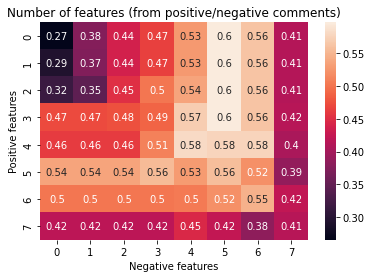

In [43]:
# Heatmap representation of the sizes vs scores
ax = sns.heatmap(weighted_accuracy_f, annot=True)
ax.set(xlabel='Negative features', ylabel='Positive features')
plt.title("Number of features (from positive/negative comments)",fontsize=12)

plt.savefig("visualize_positive_negative_lda.png", bbox_inches='tight', dpi=100)

plt.show()

accuracy score: 0.8947368421052632
f1 score: 0.9368686868686869
Weighted Accuracy: 0.5970309810671256


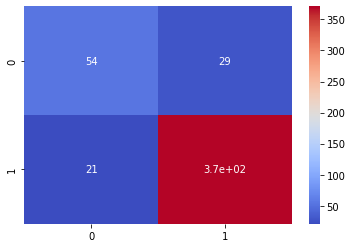

In [44]:
optimal_features =  [10*2**3,10*2**5]

# Use the fitted model to make a predict on the test set
X, y = process_data(df = df, classif_type = classif_type)
X = reduce_dataset(X, y, positive_limit = optimal_features[0], negative_limit = optimal_features[1])

lda_red = LinearDiscriminantAnalysis()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
lda_red.fit(X_train, y_train)

y_pred_red = lda_red.predict(X_test)


print('accuracy score:',accuracy_score(y_test,y_pred_red))
print('f1 score:',f1_score(y_test,y_pred_red))
print('Weighted Accuracy:',weighted_accuracy_s(confusion_matrix(y_test,y_pred_red)))
# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'LDA (restriction = '+ str(optimal_features)+')','Accuracy Score':accuracy_score(y_test,y_pred_red),'F1 Score':f1_score(y_test,y_pred_red),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred_red)),'Confusion matrix':confusion_matrix(y_test,y_pred_red)},ignore_index = True)

# Plot the confusion matrix
generate_confusion_matrix(y_test,y_pred_red)

### **Support Vector Classifier**

accuracy score: 0.9094736842105263
f1 score: 0.947239263803681
weighted accuracy score: 0.5522151898734178


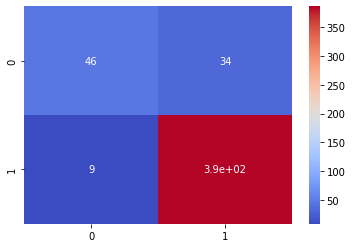

In [46]:
## SVC

# Process the data
classif_type = 'bin'
X, y = process_data(df = df, classif_type = classif_type)

# Split between train et test set
r = 0.8
X_train, y_train, X_test, y_test = split_train_test(X, y, r)

# Train the SVC
svc = svm.SVC()
svc.fit(X_train, y_train)

# Compute accuracy and weighted accuracy
y_pred_svc = svc.predict(X_test)
print('accuracy score:',accuracy_score(y_test, y_pred_svc))
print('f1 score:',f1_score(y_test, y_pred_svc))
print('weighted accuracy score:',weighted_accuracy_scorer(y_test, y_pred_svc))

# Display confusion matrix
generate_confusion_matrix(y_test, y_pred_svc)

We can perform some hyperparameter tuning

In [55]:
### Run to load the tuned model directly

param_dict = {'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}
svc_best = SVC(**param_dict)

In [48]:
### Don't run if tuned model has been already imported above

X, y = process_data(df = df, classif_type = classif_type)

param_grid = {'kernel': ('linear', 'rbf'),'C': [1, 10, 100], 'class_weight':['balanced', None]}
svc_model = SVC(gamma='scale')

svc_random = GridSearchCV(svc_model, param_grid = param_grid, cv = 2, scoring = make_scorer(weighted_accuracy_scorer))

model_svc = svc_random.fit(X, y)

svc_best = model_svc.best_estimator_

In [49]:
# print optimal set of hyperparameters
pprint(model_svc.best_estimator_.get_params())

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


accuracy score: 0.9452631578947368
f1 score: 0.9662337662337662
Weighted Accuracy: 0.9042721518987342


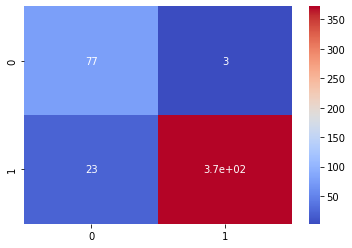

In [50]:
# Use the fitted model to make a predict on the test set
y_pred_svc = svc_best.predict(X_test)

print('accuracy score:',accuracy_score(y_test,y_pred_svc))
print('f1 score:',f1_score(y_test,y_pred_svc))
print('Weighted Accuracy:',weighted_accuracy_s(confusion_matrix(y_test,y_pred_svc)))
# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'SVC','Accuracy Score':accuracy_score(y_test,y_pred_svc),'F1 Score':f1_score(y_test,y_pred_svc),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred_svc)),'Confusion matrix':confusion_matrix(y_test,y_pred_svc)},ignore_index = True)

# Plot the confusion matrix
generate_confusion_matrix(y_test,y_pred_svc)

### **SVC with restricted number of features**

In [59]:
classif_type = 'bin'
n = 11
positive_features = [10*2**i for i in range(n)]
negative_features = [10*2**i for i in range(n)]
scores_f, f1_scores_f = np.zeros((n,n)), np.zeros((n,n))
weighted_accuracy_f = np.zeros((n,n))
confusion_matrix_matrix = {}

for i in range(len(positive_features)):
  for j in range(len(negative_features)):
    X, y = process_data(df = df, classif_type = classif_type)
    X = reduce_dataset(X, y, positive_limit = positive_features[i], negative_limit = negative_features[j])

    svc_restrict = SVC(**param_dict)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
    svc_restrict.fit(X_train, y_train)
    y_pred = svc_restrict.predict(X_test)
    f1_scores_f[i,j] = f1_score(y_test,y_pred)
    scores_f[i,j] = accuracy_score(y_test,y_pred)
    weighted_accuracy_f[i,j] = weighted_accuracy_s(confusion_matrix(y_test,y_pred))
    confusion_matrix_matrix[(positive_features[i],negative_features[j])] = confusion_matrix(y_test,y_pred)
    print('positive:',positive_features[i],'negative:',negative_features[j])

positive: 10 negative: 10
positive: 10 negative: 20
positive: 10 negative: 40
positive: 10 negative: 80
positive: 10 negative: 160
positive: 10 negative: 320
positive: 10 negative: 640
positive: 10 negative: 1280
positive: 10 negative: 2560
positive: 10 negative: 5120
positive: 10 negative: 10240
positive: 20 negative: 10
positive: 20 negative: 20
positive: 20 negative: 40
positive: 20 negative: 80
positive: 20 negative: 160
positive: 20 negative: 320
positive: 20 negative: 640
positive: 20 negative: 1280
positive: 20 negative: 2560
positive: 20 negative: 5120
positive: 20 negative: 10240
positive: 40 negative: 10
positive: 40 negative: 20
positive: 40 negative: 40
positive: 40 negative: 80
positive: 40 negative: 160
positive: 40 negative: 320
positive: 40 negative: 640
positive: 40 negative: 1280
positive: 40 negative: 2560
positive: 40 negative: 5120
positive: 40 negative: 10240
positive: 80 negative: 10
positive: 80 negative: 20
positive: 80 negative: 40
positive: 80 negative: 80
po

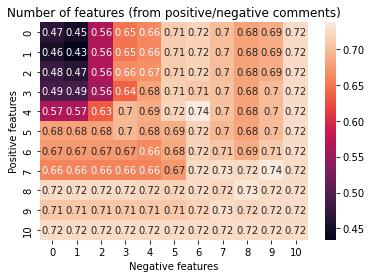

In [60]:
# Heatmap representation of the sizes vs scores
ax = sns.heatmap(weighted_accuracy_f, annot=True)
ax.set(xlabel='Negative features', ylabel='Positive features')
plt.title("Number of features (from positive/negative comments)",fontsize=12)

plt.savefig("visualize_positive_negative_lda.png", bbox_inches='tight', dpi=100)

plt.show()

accuracy score: 0.8926315789473684
f1 score: 0.9329829172141918
Weighted Accuracy: 0.7369375461027785


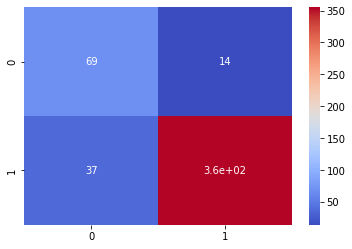

In [61]:
optimal_features =  [10*2**7,10*2**9]

# Use the fitted model to make a predict on the test set
X, y = process_data(df = df, classif_type = classif_type)
X = reduce_dataset(X, y, positive_limit = optimal_features[0], negative_limit = optimal_features[1])

svc_red = svc_best
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=None, random_state=101, shuffle=True, stratify=None)
svc_red.fit(X_train, y_train)

y_pred_red = svc_red.predict(X_test)


print('accuracy score:',accuracy_score(y_test,y_pred_red))
print('f1 score:',f1_score(y_test,y_pred_red))
print('Weighted Accuracy:',weighted_accuracy_s(confusion_matrix(y_test,y_pred_red)))
# Append the scores to the score dataframe (to plot it at the end)
score_df = score_df.append({'Name':'SVC (restriction = '+ str(optimal_features)+')','Accuracy Score':accuracy_score(y_test,y_pred_red),'F1 Score':f1_score(y_test,y_pred_red),'Weighted Accuracy':weighted_accuracy_s(confusion_matrix(y_test,y_pred_red)),'Confusion matrix':confusion_matrix(y_test,y_pred_red)},ignore_index = True)

# Plot the confusion matrix
generate_confusion_matrix(y_test,y_pred_red)

## **Conclusion**
We have used several methods to perform binary classification, let's plot the weighted accuracy, the f1 score and the accuracy for each model.

In [75]:
# Display the results
# score_df.to_excel('Accuracy.xlsx')
score_df = score_df.sort_values(by=['Weighted Accuracy'], ascending=False)
score_df

,Unnamed: 0,Unnamed: 0.1,Name,Accuracy Score,F1 Score,Weighted Accuracy,Confusion matrix,Parameters
11,NaN,NaN,SVC,0.945263,0.966234,0.904272,"[[77, 3], [23, 372]]",NaN
13,NaN,NaN,"SVC (restriction = [1280, 5120])",0.892632,0.932983,0.736938,"[[69, 14], [37, 355]]",NaN
1,1.0,1.0,LSTM,0.894515,0.931129,0.685513,[[ 43 15]\n [ 10 169]],NaN
5,5.0,5.0,RF (ratio = 1),0.781053,0.850144,0.668214,[[76 7] [97 300 ]],"{'bootstrap': False,\n 'ccp_alpha': 0.0,\n 'cl..."
7,NaN,NaN,RF (weights = 43),0.812632,0.877579,0.645095,"[[67, 13], [76, 319]]","{'cv': 2, 'error_score': nan, 'estimator__boot..."
9,NaN,NaN,LDA,0.869474,0.919481,0.633703,"[[59, 21], [41, 354]]",NaN
10,NaN,NaN,"LDA (restriction = [80, 320])",0.894737,0.936869,0.597031,"[[54, 29], [21, 371]]",NaN
4,4.0,4.0,RF,0.909474,0.947239,0.552215,[[ 46 34]\n [ 9 386]],"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."
8,NaN,NaN,"RF (restriction = [40, 80])",0.837895,0.898817,0.547148,"[[56, 27], [50, 342]]","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."
0,0.0,0.0,SimpleClassificationNN,0.827004,0.889488,0.456270,[[ 31 27]\n [ 14 165]],NaN


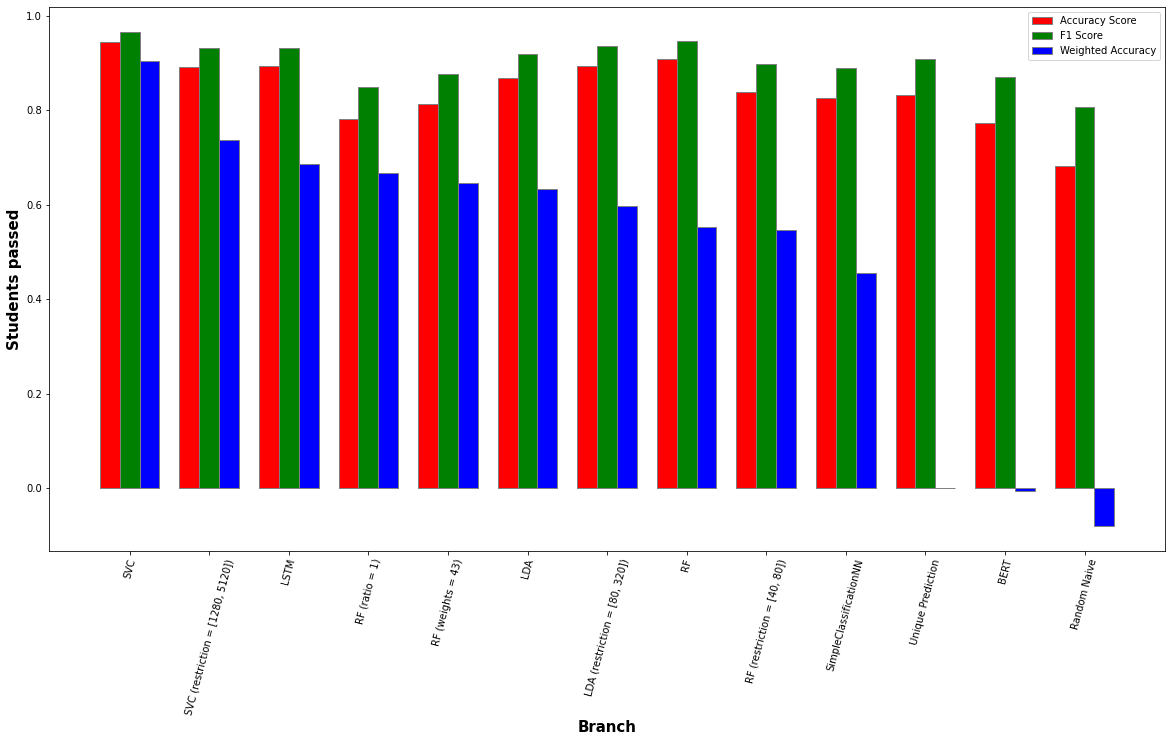

In [84]:
# Plot the results

plt.figure(figsize = (20,10))
barWidth = 0.25


x_axis = score_df.loc[:,"Name"]
y_axis_1 = score_df.loc[:,"Accuracy Score"]
y_axis_2 = score_df.loc[:,"F1 Score"]
y_axis_3 = score_df.loc[:,"Weighted Accuracy"]

# Set position of bar on X axis
br1 = np.arange(len(y_axis_1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, y_axis_1, color ='r', width = barWidth,
        edgecolor ='grey', label ='Accuracy Score')
plt.bar(br2, y_axis_2, color ='g', width = barWidth,
        edgecolor ='grey', label ='F1 Score')
plt.bar(br3, y_axis_3, color ='b', width = barWidth,
        edgecolor ='grey', label ='Weighted Accuracy')
 
# Adding Xticks
plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.ylabel('Students passed', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(y_axis_1))],
        x_axis)

plt.xticks(rotation=75)
 
plt.legend()
plt.show()

In [72]:
# Display the confusion matrix
for i in range(len(score_df.index)):
  print(score_df.iloc[i]['Name'])
  print(score_df.iloc[i]['Confusion matrix'])

SimpleClassificationNN
[[ 31  27]
 [ 14 165]]
LSTM
[[ 43  15]
 [ 10 169]]
BERT
[[  1  49]
 [  5 182]]
Random Naive
[[ 10  70]
 [ 81 314]]
RF
[[ 46  34]
 [  9 386]]
RF (ratio = 1)
[[76 7] [97 300 ]]
Unique Prediction
[[  0  80]
 [  0 395]]
RF (weights = 43)
[[ 67  13]
 [ 76 319]]
RF (restriction = [40, 80])
[[ 56  27]
 [ 50 342]]
LDA
[[ 59  21]
 [ 41 354]]
LDA (restriction = [80, 320])
[[ 54  29]
 [ 21 371]]
SVC
[[ 77   3]
 [ 23 372]]
SVC (restriction = [1280, 5120])
[[ 69  14]
 [ 37 355]]
